# Capstone 3: Making Predictions on Depletion of Five Natural Resources

## EDA: Capacity, Electricity Generation, Consumption, Production, and Reservoirs

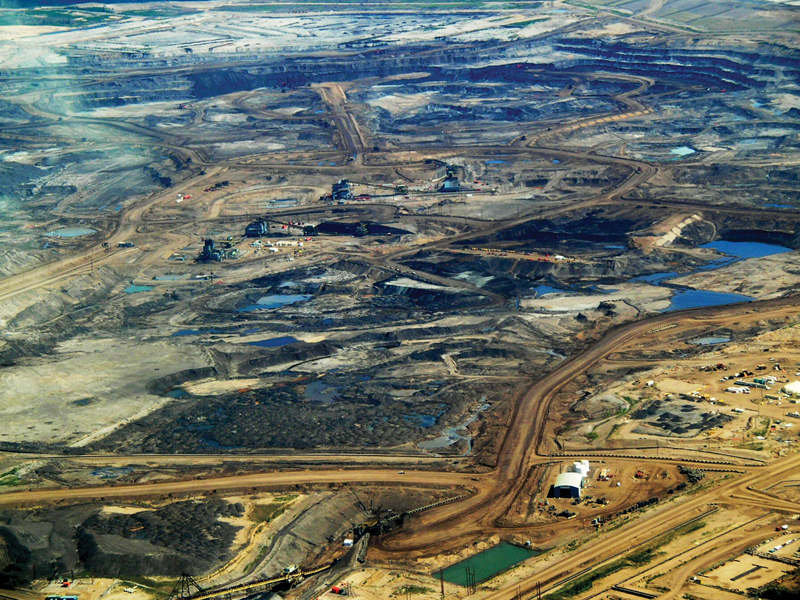

Environmentalism is defined as a concern about and action aimed at protecting the environment. The modern environmental movement started in late 19th century with concerns about protecting the rurals of Europe and the wilderness in the U.S., as well as the health consequences of pollution during the Industrial Revolution [Wikipedia](https://en.wikipedia.org/wiki/Environmentalism#:~:text=The%20movement%20in%20the%20United,Thoreau%20making%20key%20philosophical%20contributions.). Indeed, the Industrial Revolution provided the impetus for modernization. Historically, there have been four industrial revolutions: coal in 1765, gas in 1870, electronics and nuclear in 1969, and internet and renewable energy in 2000 [UpKeep](https://www.onupkeep.com/answers/maintenance-history/four-industrial-revolutions). Each of these revolutions caused great shifts in not only the job industry, lifestyles, and population growth, but impacted the environment tremendously.

This capstone project will discuss the direct and indirect effects of industrialization, modernization, and manufacturing on the availability and distribution of four essential natural resources: coal, oil, natural gas, fresh water, and phosphorus. The aim will be to provide predictive analytics for if and when these resources will be depleted. 

### Data Acquisition

**Sources:**

- https://data.un.org/
- https://www.eia.gov/outlooks/aeo/data/browser/
- https://edg.epa.gov/metadata/catalog/main/home.page
- https://sedac.ciesin.columbia.edu/data/sets/browse?facets=theme%3Aconservation
- https://marketplace.officialstatistics.org/
- https://www.kaggle.com/
- https://asb.opec.org/data/ASB_Data.php


### Imports

In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy.stats
import pandas.plotting
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from scipy.stats import norm
from matplotlib import pyplot as plt
%matplotlib notebook

from IPython import display
from ipywidgets import interact, widgets

import re
import mailbox
import csv

### Population

One of the biggest concerns in the modern world that is paramount is overpopulation. It affects everything (and not in a good way). Here I'll take a dataset from UNdata that shows an updated data of world population, surface area, and density.

In [154]:
path = r'C:\Users\yuvem\OneDrive\Documents\GitHub\Personal-Capstone-Projects\Estimating when four natural resources will be depleted\Datasets\SYB63_1_202105_Population, Surface Area and Density.csv'
world_pop_data = pd.read_csv(path, header=1)
world_pop_data.head()

Region/Country/Area                     Unnamed: 1  Year  \
0                    1  Total, all countries or areas  2005   
1                    1  Total, all countries or areas  2005   
2                    1  Total, all countries or areas  2005   
3                    1  Total, all countries or areas  2005   
4                    1  Total, all countries or areas  2005   

                                              Series      Value Footnotes  \
0           Population mid-year estimates (millions)  6541.9070       NaN   
1  Population mid-year estimates for males (milli...  3296.4853       NaN   
2  Population mid-year estimates for females (mil...  3245.4217       NaN   
3                  Sex ratio (males per 100 females)   101.5734       NaN   
4     Population aged 0 to 14 years old (percentage)    28.1425       NaN   

                                              Source  
0  United Nations Population Division, New York, ...  
1  United Nations Population Division, New York, ...  
2  United Nations Population Division, New York, ...  
3  United Nations Population Division, New York, ...  
4  United Nations Population Division, New York, ...

In [155]:
world_pop_data.rename({'Unnamed: 1':'Country'}, axis=1, inplace=True) # Rename 2nd column to 'Country'

In [302]:
# Gives preliminary view of the data
def brief_summary(df):
    print(df.head())
    print(df.isnull().sum()/len(df))
    print(df.info())
    print(df.describe())
    print(df.hist())

def normal_fit(df):
    # Sample std and mu
    sigma = np.std(df, ddof=1)
    mu = np.mean(df)
    # Plot
    x = np.linspace(np.min(df), np.max(df))
    plt.plot(x, norm.pdf(x, mu, sigma),
             label= '$\mathcal{N} ' + f'$( $\mu$ \\approx{round(mu)} , $\sigma$ \\approx {round(sigma)} )$')
    plt.hist(df, edgecolor='black', alpha=0.5, density=True)
    return plt.show()

In [157]:
#world_pop_data['Region/Country/Area'].unique()
#world_pop_data['Footnotes'].unique()
# Just dropping the Region/Country/Area column, keeping the Footnotes for now

In [158]:
# Check
world_pop_data = world_pop_data.drop(columns='Region/Country/Area')

In [159]:
#world_pop_data['Series'].unique()
# going to make separate dataset later for each Series

In [160]:
world_pop_data.isnull().sum()/len(world_pop_data)

Country      0.000000
Year         0.000000
Series       0.000000
Value        0.000000
Footnotes    0.866957
Source       0.000000
dtype: float64

In [161]:
world_pop_data['Year'].unique()

array([2005, 2010, 2017, 2019, 2000, 2016, 2001, 2011, 2015, 2006, 2014,
       2012, 2008, 2009, 2007, 2004, 2002, 2013, 2003], dtype=int64)

In [162]:
#world_pop_data['Country'].unique()
world_pop_data['Source'].unique()

array(['United Nations Population Division, New York, World Population Prospects: The 2019 Revision, last accessed June 2019.',
       'United Nations Population Division, New York, World Population Prospects: The 2019 Revision; supplemented by data from the United Nations Statistics Division, New York, Demographic Yearbook 2015 and Secretariat for the Pacific Community (SPC) for small countries or areas, last accessed June 2019.',
       'United Nations Statistics Division, New York, "Demographic Yearbook 2015" and the demographic statistics database, last accessed June 2017.'],
      dtype=object)

So the 'Source' column is not necessary for our analysis; however, it's good to record where this data come from so I'll do that now. 

**World Population Data: Sources:**
- United Nations Population Division, New York, World Population Prospects: The 2019 Revision, last accessed June 2019.
- United Nations Population Division, New York, World Population Prospects: The 2019 Revision; supplemented by data from the United Nations Statistics Division, New York, Demographic Yearbook 2015 and Secretariat for the Pacific Community (SPC) for small countries or areas, last accessed June 2019.
- United Nations Statistics Division, New York, "Demographic Yearbook 2015" and the demographic statistics database, last accessed June 2017.

Looks like these were all accessed online.

In [163]:
world_pop_data = world_pop_data.drop(columns='Source')
#world_pop_data.head()

In [164]:
world_pop_data.dtypes

Country       object
Year           int64
Series        object
Value        float64
Footnotes     object
dtype: object

In [165]:
# Data type conversions

# Country
world_pop_data['Country'] = world_pop_data['Country'].astype(pd.StringDtype())

# Series
world_pop_data['Series'] = world_pop_data['Series'].astype(pd.StringDtype())

# Value
world_pop_data['Value'] = world_pop_data['Value'].round(2)

In [166]:
world_pop_data.dtypes

Country       string
Year           int64
Series        string
Value        float64
Footnotes     object
dtype: object

                         Country  Year  \
0  Total, all countries or areas  2005   
1  Total, all countries or areas  2005   
2  Total, all countries or areas  2005   
3  Total, all countries or areas  2005   
4  Total, all countries or areas  2005   

                                              Series    Value Footnotes  
0           Population mid-year estimates (millions)  6541.91       NaN  
1  Population mid-year estimates for males (milli...  3296.49       NaN  
2  Population mid-year estimates for females (mil...  3245.42       NaN  
3                  Sex ratio (males per 100 females)   101.57       NaN  
4     Population aged 0 to 14 years old (percentage)    28.14       NaN  
Country      0.000000
Year         0.000000
Series       0.000000
Value        0.000000
Footnotes    0.866957
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7351 entries, 0 to 7350
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  

<IPython.core.display.Javascript object>


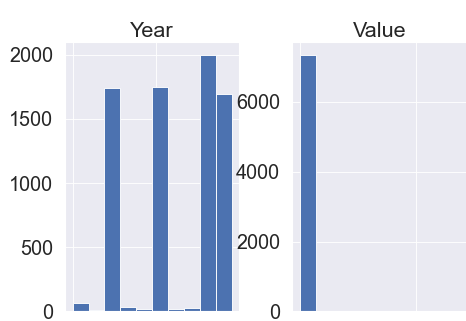

[[<AxesSubplot:title={'center':'Year'}>
  <AxesSubplot:title={'center':'Value'}>]]


In [167]:
brief_summary(world_pop_data)

#### Adding Continent Column

In [168]:
i = world_pop_data[((world_pop_data.Country == 'Total, all countries or areas'))].index # Find index for 'total, all countires or areas' so I can drop this
i

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
           dtype='int64')

In [169]:
world_pop_data[((world_pop_data.Country == 'Total, all countries or areas'))]

Country  Year  \
0   Total, all countries or areas  2005   
1   Total, all countries or areas  2005   
2   Total, all countries or areas  2005   
3   Total, all countries or areas  2005   
4   Total, all countries or areas  2005   
5   Total, all countries or areas  2005   
6   Total, all countries or areas  2005   
7   Total, all countries or areas  2010   
8   Total, all countries or areas  2010   
9   Total, all countries or areas  2010   
10  Total, all countries or areas  2010   
11  Total, all countries or areas  2010   
12  Total, all countries or areas  2010   
13  Total, all countries or areas  2010   
14  Total, all countries or areas  2017   
15  Total, all countries or areas  2017   
16  Total, all countries or areas  2017   
17  Total, all countries or areas  2017   
18  Total, all countries or areas  2017   
19  Total, all countries or areas  2017   
20  Total, all countries or areas  2017   
21  Total, all countries or areas  2017   
22  Total, all countries or areas  2019   
23  Total, all countries or areas  2019   
24  Total, all countries or areas  2019   
25  Total, all countries or areas  2019   
26  Total, all countries or areas  2019   
27  Total, all countries or areas  2019   
28  Total, all countries or areas  2019   

                                               Series      Value Footnotes  
0            Population mid-year estimates (millions)    6541.91       NaN  
1   Population mid-year estimates for males (milli...    3296.49       NaN  
2   Population mid-year estimates for females (mil...    3245.42       NaN  
3                   Sex ratio (males per 100 females)     101.57       NaN  
4      Population aged 0 to 14 years old (percentage)      28.14       NaN  
5          Population aged 60+ years old (percentage)      10.25       NaN  
6                                  Population density      50.29       NaN  
7            Population mid-year estimates (millions)    6956.82       NaN  
8   Population mid-year estimates for males (milli...    3507.70       NaN  
9   Population mid-year estimates for females (mil...    3449.12       NaN  
10                  Sex ratio (males per 100 females)     101.70       NaN  
11     Population aged 0 to 14 years old (percentage)      26.97       NaN  
12         Population aged 60+ years old (percentage)      10.98       NaN  
13                                 Population density      53.48       NaN  
14           Population mid-year estimates (millions)    7547.86       NaN  
15  Population mid-year estimates for males (milli...    3805.47       NaN  
16  Population mid-year estimates for females (mil...    3742.39       NaN  
17                  Sex ratio (males per 100 females)     101.69       NaN  
18     Population aged 0 to 14 years old (percentage)      25.89       NaN  
19         Population aged 60+ years old (percentage)      12.71       NaN  
20                                 Population density      58.02       NaN  
21                        Surface area (thousand km2)  136162.00       NaN  
22           Population mid-year estimates (millions)    7713.47       NaN  
23  Population mid-year estimates for males (milli...    3889.03       NaN  
24  Population mid-year estimates for females (mil...    3824.43       NaN  
25                  Sex ratio (males per 100 females)     101.69       NaN  
26     Population aged 0 to 14 years old (percentage)      25.61       NaN  
27         Population aged 60+ years old (percentage)      13.20       NaN  
28                                 Population density      59.29       NaN

In [170]:
world_pop_data2 = world_pop_data.drop(i) # Set new variable for this

In [171]:
world_pop_data2.head()

Country  Year                                             Series   Value  \
29  Africa  2005           Population mid-year estimates (millions)  916.15   
30  Africa  2005  Population mid-year estimates for males (milli...  456.65   
31  Africa  2005  Population mid-year estimates for females (mil...  459.51   
32  Africa  2005                  Sex ratio (males per 100 females)   99.38   
33  Africa  2005     Population aged 0 to 14 years old (percentage)   41.87   

   Footnotes  
29       NaN  
30       NaN  
31       NaN  
32       NaN  
33       NaN

In [172]:
africa = world_pop_data2[((world_pop_data2.Country == 'Africa'))]

In [173]:
asia = world_pop_data2[((world_pop_data2.Country == 'Asia'))]

In [174]:
africa_asia = africa.append(asia, ignore_index=True)

In [175]:
southamerica = world_pop_data2[((world_pop_data2.Country == 'South America'))]

In [176]:
europe = world_pop_data2[((world_pop_data2.Country == 'Europe'))]

In [177]:
southamer_euro = southamerica.append(europe, ignore_index=True)

In [178]:
oceania = world_pop_data2[((world_pop_data2.Country == 'Oceania'))]

In [179]:
northamerica = world_pop_data2[((world_pop_data2.Country == 'Northern America'))]

In [180]:
first_four = africa_asia.append(southamer_euro, ignore_index=True)

In [181]:
centralamerica = world_pop_data2[((world_pop_data2.Country == 'Central America'))]

In [182]:
australianewzeal = world_pop_data2[((world_pop_data2.Country == 'Australia and New Zealand'))]

In [183]:
northamer_oceania = oceania.append(northamerica, ignore_index=True)

In [184]:
centralamer_ausnewz = centralamerica.append(australianewzeal, ignore_index=True)

In [185]:
second_four = northamer_oceania.append(centralamer_ausnewz, ignore_index=True)

In [186]:
world_pop_continents = first_four.append(second_four, ignore_index=True)

In [187]:
len(world_pop_continents)

232

In [188]:
world_pop_continents.head()

Country  Year                                             Series   Value  \
0  Africa  2005           Population mid-year estimates (millions)  916.15   
1  Africa  2005  Population mid-year estimates for males (milli...  456.65   
2  Africa  2005  Population mid-year estimates for females (mil...  459.51   
3  Africa  2005                  Sex ratio (males per 100 females)   99.38   
4  Africa  2005     Population aged 0 to 14 years old (percentage)   41.87   

  Footnotes  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN

#### Separate dataset: Country, Year, Value

  Country  Year   Value
0  Africa  2005  916.15
1  Africa  2005  456.65
2  Africa  2005  459.51
3  Africa  2005   99.38
4  Africa  2005   41.87
Country    0.0
Year       0.0
Value      0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Country  232 non-null    string 
 1   Year     232 non-null    int64  
 2   Value    232 non-null    float64
dtypes: float64(1), int64(1), string(1)
memory usage: 5.6 KB
None
              Year         Value
count   232.000000    232.000000
mean   2012.896552    892.542026
std       5.553953   3805.748557
min    2005.000000      3.060000
25%    2010.000000     20.040000
50%    2017.000000     71.965000
75%    2017.000000    189.485000
max    2019.000000  31915.000000


<IPython.core.display.Javascript object>


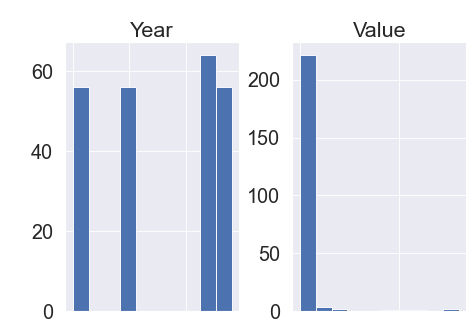

[[<AxesSubplot:title={'center':'Year'}>
  <AxesSubplot:title={'center':'Value'}>]]


In [189]:
country_year_val = world_pop_continents[['Country','Year','Value']]
brief_summary(country_year_val)

In [191]:
# Convert Year to datetime
country_year_val['Year'] = pd.to_datetime(country_year_val.Year, format='%Y')

<ipython-input-191-7fd72f5aa4bf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_year_val['Year'] = pd.to_datetime(country_year_val.Year, format='%Y')


In [192]:
# Check max and min values for 'Value' column
country_year_val.Value.max()

31915.0

In [193]:
country_year_val.Value.min()

3.06

In [194]:
len(country_year_val)

232

In [195]:
country_year_val.isnull().sum()/len(country_year_val)

Country    0.0
Year       0.0
Value      0.0
dtype: float64

In [196]:
# Making separate dataframe again
pivot_table = country_year_val.pivot_table(index=['Country', 'Year'])
pivot_table.head()

Value
Country Year                   
Africa  2005-01-01   287.081429
        2010-01-01   322.820000
        2017-01-01  4123.433750
        2019-01-01   400.871429
Asia    2005-01-01  1175.098571

In [197]:
pivot_table.dropna()

Value
Country                   Year                   
Africa                    2005-01-01   287.081429
                          2010-01-01   322.820000
                          2017-01-01  4123.433750
                          2019-01-01   400.871429
Asia                      2005-01-01  1175.098571
                          2010-01-01  1242.235714
                          2017-01-01  5154.966250
                          2019-01-01  1356.024286
Australia and New Zealand 2005-01-01    26.864286
                          2010-01-01    27.694286
                          2017-01-01  1026.633750
                          2019-01-01    29.050000
Central America           2005-01-01    69.802857
                          2010-01-01    73.562857
                          2017-01-01   378.922500
                          2019-01-01    80.192857
Europe                    2005-01-01   231.564286
                          2010-01-01   233.780000
                          2017-01-01  3088.395000
                          2019-01-01   237.538571
Northern America          2005-01-01   115.287143
                          2010-01-01   120.145714
                          2017-01-01  2832.186250
                          2019-01-01   127.391429
Oceania                   2005-01-01    30.081429
                          2010-01-01    31.140000
                          2017-01-01  1098.935000
                          2019-01-01    32.911429
South America             2005-01-01   128.662857
                          2010-01-01   134.561429
                          2017-01-01  2353.653750
                          2019-01-01   144.600000

<IPython.core.display.Javascript object>


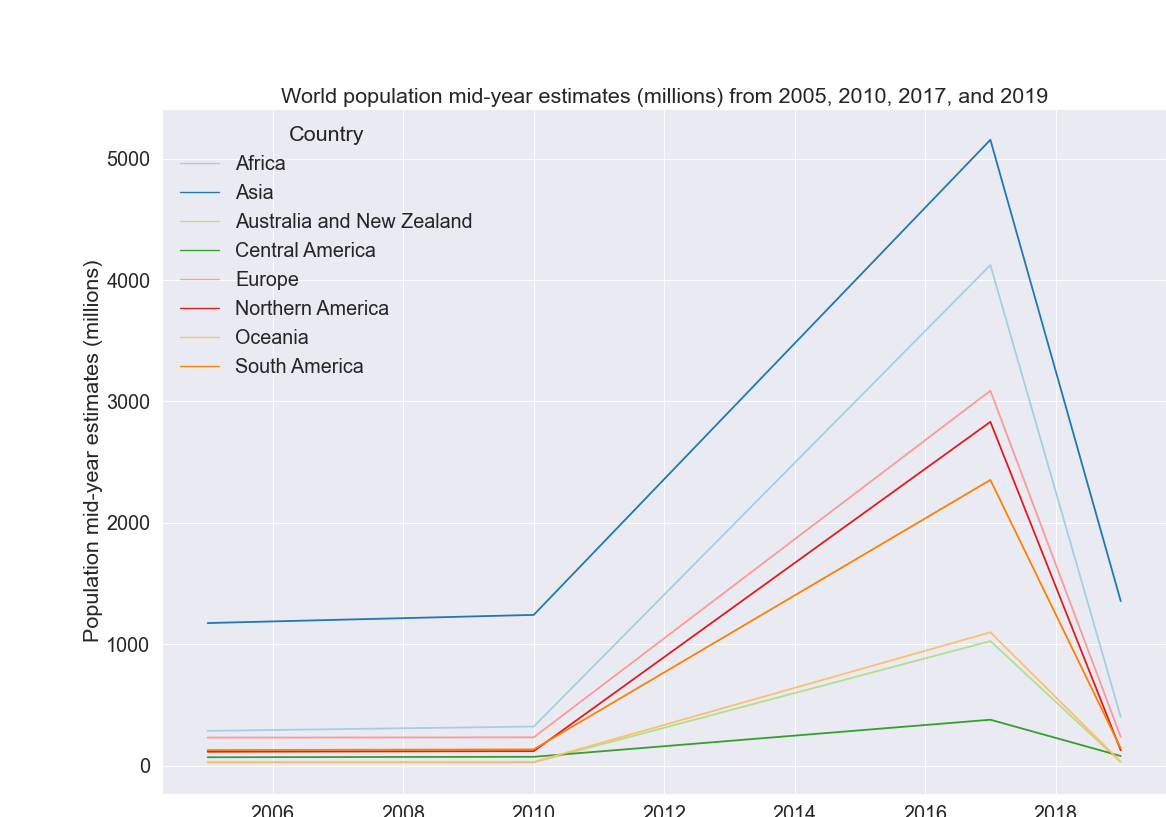

In [199]:
plt.style.use('seaborn')
plt.figure(figsize=(20,14))
sns.set(font_scale = 2)
sns.lineplot(data=pivot_table.reset_index(), x='Year', y='Value', hue='Country', palette='Paired', linewidth= 2.0)
plt.ylabel('Population mid-year estimates (millions)')
plt.title('World population mid-year estimates (millions) from 2005, 2010, 2017, and 2019')
plt.show()

## Natural resources EDA

For the EDA, I want to do a generation vs. consumption and supply and demand, as well as look for data on current number of reservoirs (per country and a total for the whole world). 

## Units

An important thing to note beforehand are units and measurements. 
- Barrels or gallons for liquid petroleum fuels (such as gasoline, diesel fuel, and jet fuel) and biofuels (ethanol and biodiesel).
- Cubic feet for natural gas
- Tons for coal (a short ton equals 2,000 pounds; a metric ton equals about 2,205 pounds)

## I. Coal

**Context:**

Coal can be extracted from the earth either via surface mining or underground mining. If it is located less than 61 meters underground, it can be extracted by surface mining. However, most of the world's coal reserves are buried deep, deep underground (like 300 meters), and this is where underground mining is ideal (or aka deep mining). Coal provides steam and power needed to mass-produce items, generate electricity, generate heat, fuel steamships, and fuel the stell industry. 

Coal is an attractive source due to the fact that it is cheap and provides thousands and millions of job opportunities as lots of people are required in the coal extracting, burning, and disposal proceses. However, it is responsible for a multitude of environmental damages. One, burning it in electric power plants emits tons of carbon dioxide (in the U.S. alone, it generates singlehandedly 42% of dangerous mercury emissions, two-thirds of U.S. sulfur dioxide - contributing to acid rain - and generating particulate matter in the air) [NRDC](https://www.nrdc.org/stories/fossil-fuels-dirty-facts). Two, it is a great disturbance to the land and affects the chemistry of rainwater runoff. And if CO2 and SO2 weren't enough, it also releases substantial amounts of methane. 

Before going on about the harms of coal, here is a data from the Global Power Plant Database, last updated June 2021. The Global Plant Database collects the following characteristics and indicators:
- All types of fuel
- Technical characteristics (fuel, technology, ownership)
- Operational characteristics (generation)
- Plant's geolocation
- Plants over 1 megawatt (MW)
- Plants in operation only (in first iteration)

In [200]:
path2 = r'C:\Users\yuvem\OneDrive\Documents\GitHub\Personal-Capstone-Projects\Estimating when four natural resources will be depleted\global_power_plant_database.csv'
power_plant_data = pd.read_csv(path2)
power_plant_data.head()

D:\User\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


country country_long                                              name  \
0     AFG  Afghanistan      Kajaki Hydroelectric Power Plant Afghanistan   
1     AFG  Afghanistan                                      Kandahar DOG   
2     AFG  Afghanistan                                      Kandahar JOL   
3     AFG  Afghanistan     Mahipar Hydroelectric Power Plant Afghanistan   
4     AFG  Afghanistan  Naghlu Dam Hydroelectric Power Plant Afghanistan   

      gppd_idnr  capacity_mw  latitude  longitude primary_fuel other_fuel1  \
0  GEODB0040538         33.0    32.322    65.1190        Hydro         NaN   
1    WKS0070144         10.0    31.670    65.7950        Solar         NaN   
2    WKS0071196         10.0    31.623    65.7920        Solar         NaN   
3  GEODB0040541         66.0    34.556    69.4787        Hydro         NaN   
4  GEODB0040534        100.0    34.641    69.7170        Hydro         NaN   

  other_fuel2  ... estimated_generation_gwh_2013  \
0         NaN  ...                        123.77   
1         NaN  ...                         18.43   
2         NaN  ...                         18.64   
3         NaN  ...                        225.06   
4         NaN  ...                        406.16   

   estimated_generation_gwh_2014 estimated_generation_gwh_2015  \
0                         162.90                         97.39   
1                          17.48                         18.25   
2                          17.58                         19.10   
3                         203.55                        146.90   
4                         357.22                        270.99   

  estimated_generation_gwh_2016 estimated_generation_gwh_2017  \
0                        137.76                        119.50   
1                         17.70                         18.29   
2                         17.62                         18.72   
3                        230.18                        174.91   
4                        395.38                        350.80   

  estimated_generation_note_2013 estimated_generation_note_2014  \
0                       HYDRO-V1                       HYDRO-V1   
1                SOLAR-V1-NO-AGE                SOLAR-V1-NO-AGE   
2                SOLAR-V1-NO-AGE                SOLAR-V1-NO-AGE   
3                       HYDRO-V1                       HYDRO-V1   
4                       HYDRO-V1                       HYDRO-V1   

   estimated_generation_note_2015  estimated_generation_note_2016  \
0                        HYDRO-V1                        HYDRO-V1   
1                 SOLAR-V1-NO-AGE                 SOLAR-V1-NO-AGE   
2                 SOLAR-V1-NO-AGE                 SOLAR-V1-NO-AGE   
3                        HYDRO-V1                        HYDRO-V1   
4                        HYDRO-V1                        HYDRO-V1   

   estimated_generation_note_2017  
0                        HYDRO-V1  
1                 SOLAR-V1-NO-AGE  
2                 SOLAR-V1-NO-AGE  
3                        HYDRO-V1  
4                        HYDRO-V1  

[5 rows x 36 columns]

In [201]:
power_plant_data['primary_fuel'].unique()

array(['Hydro', 'Solar', 'Gas', 'Other', 'Oil', 'Wind', 'Nuclear', 'Coal',
       'Waste', 'Biomass', 'Wave and Tidal', 'Petcoke', 'Geothermal',
       'Storage', 'Cogeneration'], dtype=object)

In [202]:
coal_data = power_plant_data[((power_plant_data.primary_fuel == 'Coal'))]

In [203]:
coal_data = coal_data.drop(columns='other_fuel1')
coal_data = coal_data.drop(columns='other_fuel2')
coal_data = coal_data.drop(columns='other_fuel3')

In [204]:
coal_data.columns

Index(['country', 'country_long', 'name', 'gppd_idnr', 'capacity_mw',
       'latitude', 'longitude', 'primary_fuel', 'commissioning_year', 'owner',
       'source', 'url', 'geolocation_source', 'wepp_id',
       'year_of_capacity_data', 'generation_gwh_2013', 'generation_gwh_2014',
       'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017',
       'generation_gwh_2018', 'generation_gwh_2019', 'generation_data_source',
       'estimated_generation_gwh_2013', 'estimated_generation_gwh_2014',
       'estimated_generation_gwh_2015', 'estimated_generation_gwh_2016',
       'estimated_generation_gwh_2017', 'estimated_generation_note_2013',
       'estimated_generation_note_2014', 'estimated_generation_note_2015',
       'estimated_generation_note_2016', 'estimated_generation_note_2017'],
      dtype='object')

In [205]:
coal_data.isnull().sum()/len(coal_data)

country                           0.000000
country_long                      0.000000
name                              0.000000
gppd_idnr                         0.000000
capacity_mw                       0.000000
latitude                          0.000000
longitude                         0.000000
primary_fuel                      0.000000
commissioning_year                0.185837
owner                             0.128326
source                            0.000429
url                               0.000429
geolocation_source                0.000000
wepp_id                           0.346352
year_of_capacity_data             0.766953
generation_gwh_2013               0.869957
generation_gwh_2014               0.802575
generation_gwh_2015               0.741631
generation_gwh_2016               0.739056
generation_gwh_2017               0.745064
generation_gwh_2018               0.793562
generation_gwh_2019               0.878970
generation_data_source            0.722747
estimated_g

In [206]:
# looking at countries
coal_data['country_long'].unique()

array(['Argentina', 'Australia', 'Bangladesh', 'Belgium',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria',
       'Cambodia', 'Canada', 'Chile', 'China', 'Colombia', 'Croatia',
       'Czech Republic', 'Denmark', 'Dominican Republic', 'Finland',
       'France', 'Germany', 'Greece', 'Guatemala', 'Hungary', 'India',
       'Indonesia', 'Ireland', 'Israel', 'Italy', 'Japan', 'Kazakhstan',
       'Kosovo', 'Kyrgyzstan', 'Laos', 'Macedonia', 'Madagascar',
       'Malaysia', 'Mauritius', 'Mexico', 'Moldova', 'Mongolia',
       'Montenegro', 'Morocco', 'Myanmar', 'Namibia', 'Netherlands',
       'New Zealand', 'Niger', 'North Korea', 'Pakistan', 'Panama',
       'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia',
       'Serbia', 'Slovakia', 'Slovenia', 'South Africa', 'South Korea',
       'Spain', 'Sri Lanka', 'Sweden', 'Taiwan', 'Thailand', 'Turkey',
       'Ukraine', 'United Kingdom', 'United States of America',
       'Uzbekistan', 'Vietnam', 'Zambia', 'Z

In [207]:
# Geo location source
coal_data['geolocation_source'].unique()

array(['Ministerio de Energía y Minería',
       'Australian Renewable Energy Mapping Infrastructure', 'WRI',
       'GEODB', 'Power Africa',
       'Agência Nacional de Energia Elétrica (Brazil)', 'GCPT',
       'Natural Resources Canada', 'Energía Abierta', 'Industry About',
       'Open Power System Data', 'CARMA',
       'Guatemala Energy Data Visualization Center at Universidad Rafael Landivar',
       'North American Cooperation on Energy Information and Comisión Reguladora de Energía',
       'University of Dąbrowa Górnicza', 'EnergyBase (RUS)',
       'UK Renewable Energy Planning Database', 'GEO',
       'U.S. Energy Information Administration'], dtype=object)

In [208]:
# Making separate dataset for capacity_mw; will use later for combined table
coal_subset = coal_data[['country_long','capacity_mw']]

The column 'capacity_mw' stands for capacity megawatts, which is the maximum output of electricity a generator can produce under ideal conditions (measured in megawatts). For instance, if wind turbines accounted for 8% of U.S. installed electricity generation "capacity", this means that under indeal conditions, utilities would be able to supply 8% of the country's electricity needs with wind power. This does not equate to actual amount of electricity produced. 

The actual amount of electricity produced refers to electricity generation (usually in kwh, mwh, hwh, or twh). For instance, a wind turbine with a ccapacity of 1.5 mw that is running at max capacity for 2 hours generates at the end of the second hour 3 mwh of energy (1.5 * 2). Not all generation sources are operating at their maximum capacity at all times. 

In [209]:
est_gen_gwh_coal = coal_data[['country_long','estimated_generation_gwh_2017']]
est_gen_gwh_coal

country_long  estimated_generation_gwh_2017
119      Argentina                        3213.44
126      Argentina                        1871.05
141      Argentina                       10273.70
164      Argentina                          68.41
268      Argentina                        1067.69
...            ...                            ...
34903      Vietnam                        3660.12
34906      Vietnam                        6194.82
34907      Vietnam                        6199.80
34928       Zambia                        2131.66
34934     Zimbabwe                        2785.10

[2330 rows x 2 columns]

In [210]:
est_gen_gwh_coal[((est_gen_gwh_coal.country_long == 'Belgium'))]

country_long  estimated_generation_gwh_2017
1066      Belgium                            NaN

In [211]:
# eliminate NaN's
est_gen_gwh_coal = est_gen_gwh_coal[est_gen_gwh_coal['estimated_generation_gwh_2017'].notna()]
est_gen_gwh_coal = est_gen_gwh_coal[est_gen_gwh_coal['estimated_generation_gwh_2017'] != 'nan']
est_gen_gwh_coal

country_long  estimated_generation_gwh_2017
119      Argentina                        3213.44
126      Argentina                        1871.05
141      Argentina                       10273.70
164      Argentina                          68.41
268      Argentina                        1067.69
...            ...                            ...
34903      Vietnam                        3660.12
34906      Vietnam                        6194.82
34907      Vietnam                        6199.80
34928       Zambia                        2131.66
34934     Zimbabwe                        2785.10

[2306 rows x 2 columns]

             country_long  estimated_generation_gwh_2017
0               Argentina                    2797.306667
1               Australia                    5891.468214
2              Bangladesh                     902.320000
3  Bosnia and Herzegovina                    2678.542500
4                Botswana                    1493.980000
country_long                     0.0
estimated_generation_gwh_2017    0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   country_long                   64 non-null     object 
 1   estimated_generation_gwh_2017  64 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB
None
       estimated_generation_gwh_2017
count                      64.000000
mean                     3521.403896
std                      3489.066014
min                   

<IPython.core.display.Javascript object>


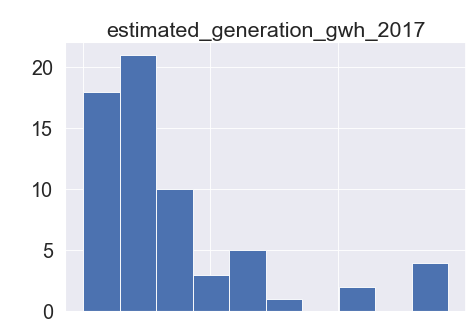

[[<AxesSubplot:title={'center':'estimated_generation_gwh_2017'}>]]


In [212]:
est_gen_gwh_coal_avg = est_gen_gwh_coal.groupby('country_long').mean().reset_index()
brief_summary(est_gen_gwh_coal_avg)

In [214]:
#

#### Top 10 Countries with highest estimated generation gwh for 2017 - Coal

In [215]:
top_gwh_2017_coal = est_gen_gwh_coal_avg.nlargest(10, ['estimated_generation_gwh_2017'])
top_gwh_2017_coal

country_long  estimated_generation_gwh_2017
54        Taiwan                   14334.082857
51   South Korea                   13926.317222
50  South Africa                   13512.345294
28      Malaysia                   13249.997143
22        Israel                   10902.835000
30        Mexico                   10187.296667
44      Portugal                    7723.465000
55      Thailand                    6535.806000
34       Morocco                    6413.933333
1      Australia                    5891.468214

### Coal Consumption

This next data comes from the [Statistical Review of World Energy](https://www.bp.com/en/global/corporate/energy-economics/statistical-review-of-world-energy/downloads.html) by BP. 

In [216]:
path3 = r'C:\Users\yuvem\Downloads\bp-stats-review-2021-all-data.xlsx'
print(path3)

C:\Users\yuvem\Downloads\bp-stats-review-2021-all-data.xlsx


In [217]:
xls = pd.ExcelFile(path3)
print(xls.sheet_names)

['Contents', 'Primary Energy Consumption', 'Primary Energy - Cons by fuel', 'Primary Energy - Cons capita', 'Carbon Dioxide Emissions', 'Natural Gas Flaring', 'CO2 From Flaring', 'CO2 Excluding Flaring', 'Oil - Proved reserves', 'Oil - Proved reserves history', 'Oil Production - Barrels', 'Oil Production - Tonnes', 'Oil Production - Crude Conds', 'Oil Production - NGLs', 'Total Liquids - Consumption', 'Oil Consumption - Barrels', 'Oil Consumption - Tonnes', 'Oil Consumption - EJ', 'Oil - Regional Consumption ', 'Oil - Spot crude prices', 'Oil - Crude prices since 1861', 'Oil - Refinery throughput', 'Oil - Refining capacity', 'Oil - Regional refining margins', 'Oil - Trade movements', 'Oil - Inter-area movements ', 'Oil - Trade 2019 - 2020', 'Gas - Proved reserves', 'Gas - Proved reserves history ', 'Gas Production - Bcm', 'Gas Production - Bcf', 'Gas Production - EJ', 'Gas Consumption - Bcm', 'Gas Consumption - Bcf', 'Gas Consumption - EJ', 'Gas - Prices ', 'Gas - Inter-regional trade'

In [218]:
ds_coal_consumption = pd.read_excel(xls, 'Coal Consumption - EJ', header=[2])
ds_coal_consumption.head()

Exajoules       1965       1966       1967       1968       1969  \
0                  NaN        NaN        NaN        NaN        NaN        NaN   
1               Canada   0.647949   0.635221   0.629360   0.683746   0.660133   
2               Mexico   0.028880   0.030805   0.037798   0.039623   0.040165   
3                   US  11.607279  12.171046  11.941188  12.359075  12.410055   
4  Total North America  12.284108  12.837073  12.608346  13.082445  13.110353   

        1970       1971       1972       1973  ...       2016       2017  \
0        NaN        NaN        NaN        NaN  ...        NaN        NaN   
1   0.708742   0.673656   0.635682   0.654690  ...   0.770602   0.783998   
2   0.045045   0.056551   0.062502   0.067005  ...   0.520680   0.636310   
3  12.292774  11.625123  12.104731  13.001364  ...  14.258668  13.869334   
4  13.046560  12.355330  12.802915  13.723059  ...  15.549950  15.289642   

        2018       2019      2020    2020.1   2009-19    2020.2  Unnamed: 60  \
0        NaN        NaN       NaN       NaN       NaN       NaN          NaN   
1   0.652789   0.634692  0.495247 -0.221838 -0.045231  0.003271          NaN   
2   0.567164   0.541493  0.208847 -0.615367  0.023064  0.001379          NaN   
3  13.282051  11.341655  9.202777 -0.190803 -0.053892  0.060775          NaN   
4  14.502004  12.517841  9.906870 -0.210742 -0.051213  0.065424          NaN   

   Unnamed: 61  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 62 columns]

In [219]:
ds_coal_consumption = ds_coal_consumption.drop(0)

In [220]:
ds_coal_consumption = ds_coal_consumption.drop(columns='2020.1')
ds_coal_consumption = ds_coal_consumption.drop(columns='2009-19')
ds_coal_consumption = ds_coal_consumption.drop(columns='2020.2')
ds_coal_consumption = ds_coal_consumption.drop(columns='Unnamed: 60')
ds_coal_consumption = ds_coal_consumption.drop(columns='Unnamed: 61')

In [221]:
ds_coal_consumption.rename({'Exajoules':'Country'}, axis=1, inplace=True)

In [222]:
ds_coal_consumption.Country.unique()

array(['Canada', 'Mexico', 'US', 'Total North America', nan, 'Argentina',
       'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Peru',
       'Trinidad & Tobago', 'Venezuela', 'Central America',
       'Other Caribbean', 'Other South America',
       'Total S. & Cent. America', 'Austria', 'Belgium', 'Bulgaria',
       'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia',
       'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland',
       'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg',
       'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal',
       'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden',
       'Switzerland', 'Turkey', 'Ukraine', 'United Kingdom',
       'Other Europe', 'Total Europe', 'Azerbaijan', 'Belarus',
       'Kazakhstan', 'Russian Federation', 'Turkmenistan', 'USSR',
       'Uzbekistan', 'Other CIS', 'Total CIS', 'Iran', 'Iraq', 'Israel',
       'Kuwait', 'Oman', 'Qatar', 'Saudi Arabia', 'United Arab Emirates',
       'Other M

### Total World Coal Consumption

In [223]:
total_world_coal_consumption = ds_coal_consumption[((ds_coal_consumption.Country == 'Total World'))]
total_world_coal_consumption_melt = total_world_coal_consumption.melt(id_vars=['Country'], var_name='Year', value_name='Exajoules')
total_world_coal_pivoted= total_world_coal_consumption_melt.pivot_table(index=['Country', 'Year'])
total_world_coal_pivoted.dropna()

Exajoules
Country     Year            
Total World 1965   58.104642
            1966   58.766738
            1967   57.818915
            1968   58.684128
            1969   60.475449
            1970   61.410989
            1971   61.077453
            1972   61.771092
            1973   63.604258
            1974   63.655384
            1975   64.888336
            1976   67.278546
            1977   69.268657
            1978   70.048429
            1979   73.308712
            1980   75.087367
            1981   76.138822
            1982   76.987562
            1983   79.366927
            1984   82.803931
            1985   86.356223
            1986   87.329059
            1987   90.764908
            1988   93.481871
            1989   94.376596
            1990   93.230692
            1991   92.324280
            1992   91.991799
            1993   92.443794
            1994   92.798719
            1995   93.450050
            1996   95.675574
            1997   95.512415
            1998   94.911069
            1999   95.320343
            2000   98.732632
            2001  100.290641
            2002  104.226109
            2003  113.355874
            2004  121.223723
            2005  130.203668
            2006  137.050923
            2007  144.814904
            2008  146.783511
            2009  144.569622
            2010  151.206483
            2011  158.474019
            2012  159.078449
            2013  161.973152
            2014  162.498993
            2015  158.635278
            2016  156.605956
            2017  157.396972
            2018  159.260311
            2019  157.639144
            2020  151.424669

<IPython.core.display.Javascript object>


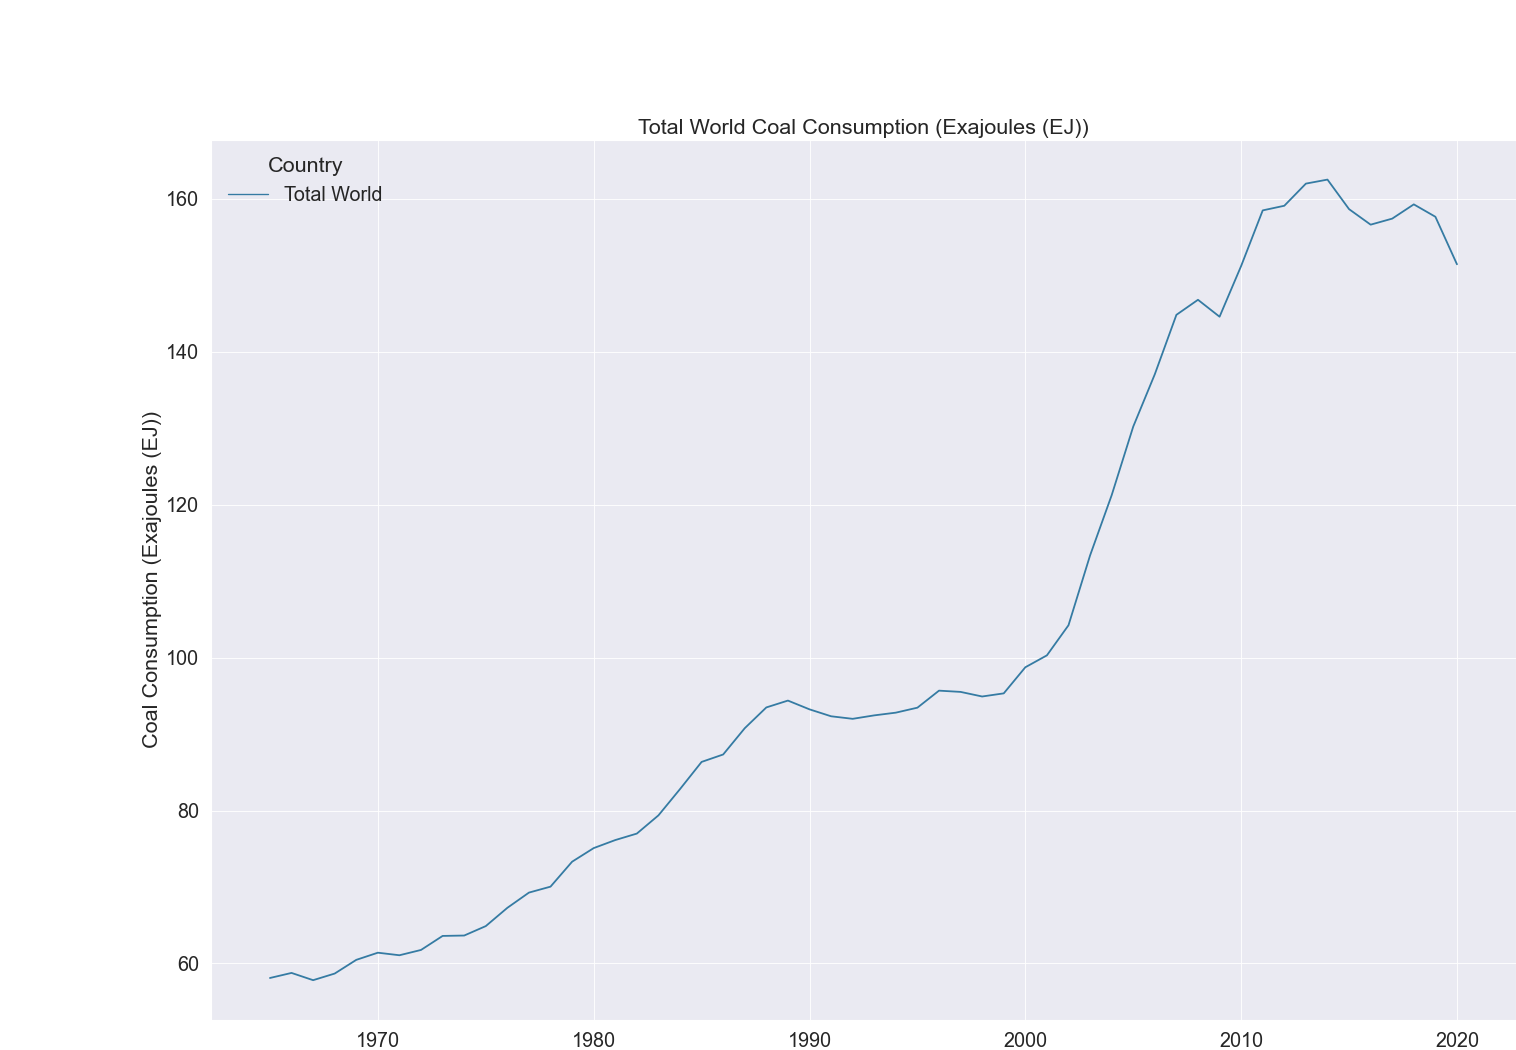

In [224]:
plt.style.use('seaborn')
plt.figure(figsize=(26,18))
sns.set(font_scale = 2)
sns.lineplot(data=total_world_coal_pivoted.reset_index(), x='Year', y='Exajoules', hue='Country', palette='mako', linewidth= 2.0)
plt.ylabel('Coal Consumption (Exajoules (EJ))')
plt.title('Total World Coal Consumption (Exajoules (EJ))')
plt.show()

### Coal Consumption by Country

In [225]:
totworld = ds_coal_consumption[((ds_coal_consumption.Country == 'Total World'))].index
totworld

Int64Index([107], dtype='int64')

In [226]:
ds_coal_consumption = ds_coal_consumption.iloc[0:106]

In [227]:
total_southamer = ds_coal_consumption[((ds_coal_consumption.Country == 'Total S. & Cent. America'))].index
total_northamer = ds_coal_consumption[((ds_coal_consumption.Country == 'Total North America'))].index
totalcis = ds_coal_consumption[((ds_coal_consumption.Country == 'Total CIS'))].index
totmid = ds_coal_consumption[((ds_coal_consumption.Country == 'Total Middle East'))].index
totafr = ds_coal_consumption[((ds_coal_consumption.Country == 'Total Africa'))].index
totasi = ds_coal_consumption[((ds_coal_consumption.Country == 'Total Asia Pacific'))].index
toteur = ds_coal_consumption[((ds_coal_consumption.Country == 'Total Europe'))].index

country_coal_consumption = ds_coal_consumption.drop(total_southamer)
country_coal_consumption = country_coal_consumption.drop(total_northamer)
country_coal_consumption = country_coal_consumption.drop(totalcis)
country_coal_consumption = country_coal_consumption.drop(totmid)
country_coal_consumption = country_coal_consumption.drop(totafr)
country_coal_consumption = country_coal_consumption.drop(totasi)
country_coal_consumption = country_coal_consumption.drop(toteur)

In [228]:
country_coal_consumption_melt = country_coal_consumption.melt(id_vars=['Country'], var_name='Year', value_name='Exajoules')
country_coal_consumption_pivoted= country_coal_consumption_melt.pivot_table(index=['Country', 'Year'])
country_coal_consumption_pivoted.dropna()

Exajoules
Country        Year           
Algeria        1965   0.002931
               1966   0.002847
               1967   0.002177
               1968   0.002303
               1969   0.002931
...                        ...
Western Africa 2016   0.040071
               2017   0.040536
               2018   0.043027
               2019   0.040662
               2020   0.036737

[4821 rows x 1 columns]

              Exajoules
Country Year           
Algeria 1965   0.002931
        1966   0.002847
        1967   0.002177
        1968   0.002303
        1969   0.002931
Exajoules    0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4821 entries, ('Algeria', 1965) to ('Western Africa', 2020)
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Exajoules  4821 non-null   float64
dtypes: float64(1)
memory usage: 48.3+ KB
None
         Exajoules
count  4821.000000
mean      1.183563
std       5.271496
min       0.000000
25%       0.005694
50%       0.087755
75%       0.453980
max      82.492776


<IPython.core.display.Javascript object>


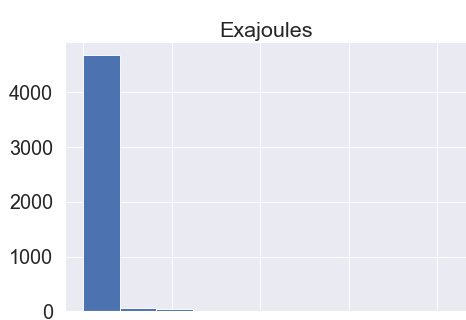

[[<AxesSubplot:title={'center':'Exajoules'}>]]


In [229]:
brief_summary(country_coal_consumption_pivoted)

In [230]:
# Top 10 countries with the most coal consumption
top_10_coal_consumption = country_coal_consumption_pivoted.nlargest(10, ['Exajoules'])
top_10_coal_consumption

Exajoules
Country Year           
China   2014  82.492776
        2013  82.441149
        2020  82.270462
        2019  81.788988
        2018  81.109745
        2015  80.936781
        2012  80.712841
        2017  80.587596
        2016  80.213067
        2011  79.710499

In [231]:
# Top 50 countries with the most coal consumption
top_50_coal_consumption = country_coal_consumption_pivoted.nlargest(50, ['Exajoules'])
top_50_coal_consumption

Exajoules
Country Year           
China   2014  82.492776
        2013  82.441149
        2020  82.270462
        2019  81.788988
        2018  81.109745
        2015  80.936781
        2012  80.712841
        2017  80.587596
        2016  80.213067
        2011  79.710499
        2010  73.224993
        2009  70.580165
        2008  67.377314
        2007  66.326087
        2006  60.906174
        2005  55.458381
        2004  47.359007
        2003  40.619011
        2002  34.082847
        2001  31.088717
        2000  29.561062
        1999  29.156518
        1996  29.143402
        1997  28.554885
        1998  28.338180
        1995  27.852662
        1994  27.510002
        1993  25.813284
        1992  24.233389
        1991  23.160340
US      2005  22.849045
        2007  22.801859
        2000  22.631530
        2004  22.517936
        2006  22.498857
        2008  22.438997
        2003  22.372334
China   1990  22.084261
US      2001  21.964738
        2002  21.954435
China   1989  21.768846
US      1998  21.705618
        1999  21.672342
        1997  21.494801
        1996  21.050283
        2010  20.881950
China   1988  20.776405
US      1995  20.134993
        1994  19.955316
        1993  19.880830

### Coal Consumption by Region

In [232]:
south_cent = ds_coal_consumption[((ds_coal_consumption.Country == 'Total S. & Cent. America'))]
n_amer = ds_coal_consumption[((ds_coal_consumption.Country == 'Total North America'))]
cis = ds_coal_consumption[((ds_coal_consumption.Country == 'Total CIS'))]
mid_east = ds_coal_consumption[((ds_coal_consumption.Country == 'Total Middle East'))]
afr = ds_coal_consumption[((ds_coal_consumption.Country == 'Total Africa'))]
asia = ds_coal_consumption[((ds_coal_consumption.Country == 'Total Asia Pacific'))]
eur = ds_coal_consumption[((ds_coal_consumption.Country == 'Total Europe'))]

In [233]:
southcent_namer = south_cent.append(n_amer, ignore_index=True)
cis_mideast = cis.append(mid_east, ignore_index=True)
four = southcent_namer.append(cis_mideast, ignore_index=True)
af_asia = afr.append(asia, ignore_index=True)
three = af_asia.append(eur, ignore_index=True)

In [234]:
ds_total_country_coal = four.append(three, ignore_index=True)
ds_total_country_coal

Country       1965       1966       1967       1968  \
0  Total S. & Cent. America   0.241955   0.244432   0.258866   0.248289   
1       Total North America  12.284108  12.837073  12.608346  13.082445   
2                 Total CIS  12.453078  12.906789  13.106593  12.992293   
3         Total Middle East   0.009107   0.009975   0.010991   0.012085   
4              Total Africa   1.164586   1.163240   1.189050   1.236646   
5        Total Asia Pacific  10.010633  10.553444  10.275475  10.428239   
6              Total Europe  21.941174  21.051786  20.369594  20.684130   

        1969       1970       1971       1972       1973  ...        2011  \
0   0.270176   0.299429   0.278270   0.272605   0.284534  ...    1.260215   
1  13.110353  13.046560  12.355330  12.802915  13.723059  ...   21.251248   
2  13.178548  13.069417  13.333698  13.706379  13.853146  ...    5.572460   
3   0.013328   0.014661   0.010435   0.016072   0.027151  ...    0.429621   
4   1.247915   1.298725   1.378844   1.383159   1.472077  ...    4.125042   
5  11.700676  13.072099  13.992669  14.531728  14.883035  ...  109.849720   
6  20.954453  20.610098  19.728208  19.058234  19.361256  ...   15.985714   

         2012        2013        2014        2015        2016        2017  \
0    1.324776    1.445855    1.522536    1.498373    1.452619    1.420538   
1   18.846303   19.475372   19.394497   16.940339   15.549950   15.289642   
2    5.840652    5.523280    5.389056    5.453992    5.328018    5.217045   
3    0.499233    0.468279    0.469929    0.440051    0.405672    0.399825   
4    4.023979    4.066602    4.259239    4.023217    4.276043    4.274933   
5  112.199620  115.188277  116.620095  116.069112  115.897948  117.568305   
6   16.343887   15.805487   14.843642   14.210194   13.695706   13.226685   

         2018        2019        2020  
0    1.408820    1.453591    1.479661  
1   14.502004   12.517841    9.906870  
2    5.563371    5.445236    5.174991  
3    0.382702    0.399061    0.384470  
4    4.202838    4.317228    4.108027  
5  120.297594  122.371923  120.972661  
6   12.902983   11.134262    9.397989  

[7 rows x 57 columns]

In [235]:
ds_total_country_coal_melt = ds_total_country_coal.melt(id_vars=['Country'], var_name='Year', value_name='Exajoules')
ds_total_country_coal_pivoted= ds_total_country_coal_melt.pivot_table(index=['Country', 'Year'])
ds_total_country_coal_pivoted.dropna()

Exajoules
Country                  Year           
Total Africa             1965   1.164586
                         1966   1.163240
                         1967   1.189050
                         1968   1.236646
                         1969   1.247915
...                                  ...
Total S. & Cent. America 2016   1.452619
                         2017   1.420538
                         2018   1.408820
                         2019   1.453591
                         2020   1.479661

[392 rows x 1 columns]

<IPython.core.display.Javascript object>


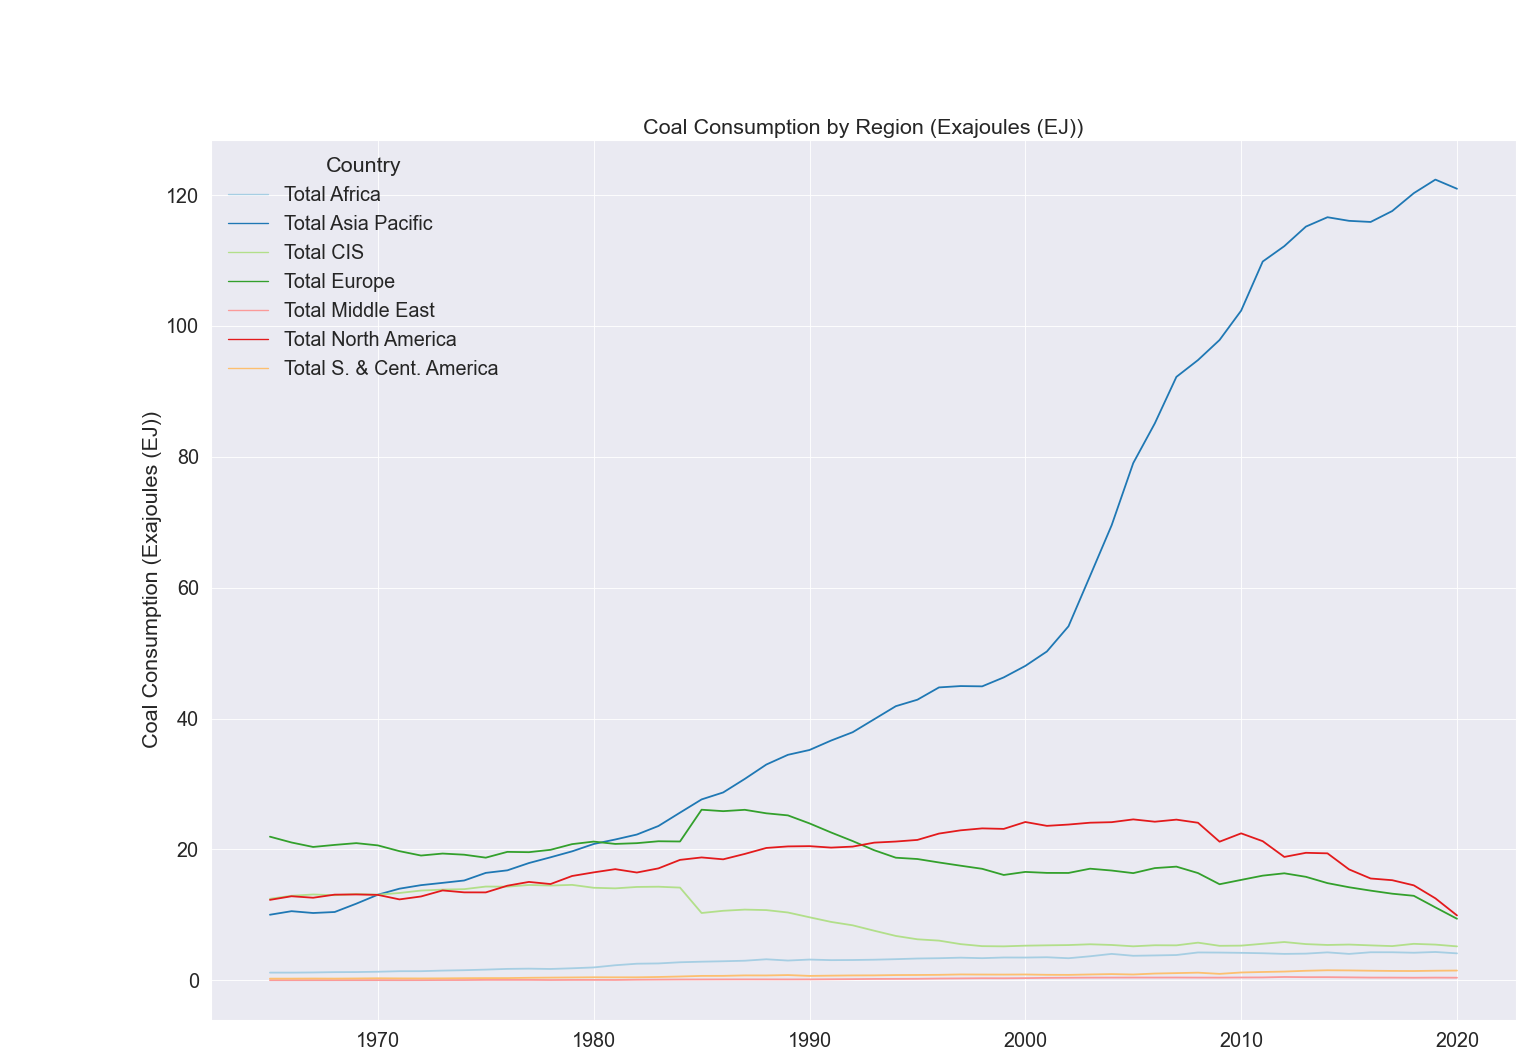

In [236]:
plt.style.use('seaborn')
plt.figure(figsize=(26,18))
sns.set(font_scale = 2)
sns.lineplot(data=ds_total_country_coal_pivoted.reset_index(), x='Year', y='Exajoules', hue='Country', palette='Paired', linewidth= 2.0)
plt.ylabel('Coal Consumption (Exajoules (EJ))')
plt.title('Coal Consumption by Region (Exajoules (EJ))')
plt.show()

## Total World Coal Production

In [237]:
ds_coal_production = pd.read_excel(xls, 'Coal Production - EJ', header=[2])
ds_coal_production.head()

Exajoules       1981       1982       1983       1984       1985  \
0                  NaN        NaN        NaN        NaN        NaN        NaN   
1               Canada   0.969542   1.028279   1.066011   1.396400   1.487132   
2               Mexico   0.071145   0.085547   0.108636   0.118361   0.121440   
3                   US  18.419096  18.681699  17.286391  19.764631  19.369673   
4  Total North America  19.459783  19.795525  18.461038  21.279392  20.978245   

        1986       1987       1988       1989  ...       2016       2017  \
0        NaN        NaN        NaN        NaN  ...        NaN        NaN   
1   1.382118   1.393936   1.614195   1.718400  ...   1.370173   1.330336   
2   0.131527   0.145985   0.130337   0.140023  ...   0.254165   0.308240   
3  19.554397  20.187490  20.785399  21.409372  ...  14.700868  15.661363   
4  21.068042  21.727411  22.529931  23.267795  ...  16.325206  17.299939   

        2018       2019       2020    2020.1   2009-19    2020.2  Unnamed: 44  \
0        NaN        NaN        NaN       NaN       NaN       NaN          NaN   
1   1.221898   1.138773   0.890490 -0.220163 -0.019577  0.005579          NaN   
2   0.279578   0.230460   0.154641 -0.330825 -0.009939  0.000969          NaN   
3  15.398825  14.288595  10.714763 -0.252167 -0.040807  0.067132          NaN   
4  16.900301  15.657828  11.759894 -0.250997 -0.039034  0.073680          NaN   

   Unnamed: 45  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 46 columns]

In [238]:
ds_coal_production = ds_coal_production.drop(0)

In [239]:
ds_coal_production = ds_coal_production.drop(columns='2020.1')
ds_coal_production = ds_coal_production.drop(columns='2009-19')
ds_coal_production = ds_coal_production.drop(columns='2020.2')
ds_coal_production = ds_coal_production.drop(columns='Unnamed: 44')
ds_coal_production = ds_coal_production.drop(columns='Unnamed: 45')

In [240]:
ds_coal_production.rename({'Exajoules':'Country'}, axis=1, inplace=True)

In [241]:
total_world_coal_production = ds_coal_production[((ds_coal_production.Country == 'Total World'))]
total_world_coal_production_melt = total_world_coal_production.melt(id_vars=['Country'], var_name='Year', value_name='Exajoules')
total_world_coal_prod_pivot = total_world_coal_production_melt.pivot_table(index=['Country', 'Year'])
total_world_coal_prod_pivot.dropna()

Exajoules
Country     Year            
Total World 1981   77.206126
            1982   79.939017
            1983   79.696963
            1984   83.182985
            1985   87.397897
            1986   89.470625
            1987   91.158522
            1988   93.372400
            1989   95.020971
            1990   94.797323
            1991   92.221622
            1992   92.051356
            1993   89.277654
            1994   91.318823
            1995   94.106648
            1996   95.388483
            1997   96.789484
            1998   95.048116
            1999   95.077540
            2000   96.476971
            2001  100.566398
            2002  101.785973
            2003  109.254289
            2004  118.719477
            2005  126.178617
            2006  132.621651
            2007  138.443189
            2008  142.963185
            2009  142.883997
            2010  150.837434
            2011  161.846062
            2012  163.708570
            2013  166.659768
            2014  166.074288
            2015  161.847923
            2016  153.328629
            2017  157.199454
            2018  165.174380
            2019  167.858718
            2020  159.606649

<IPython.core.display.Javascript object>


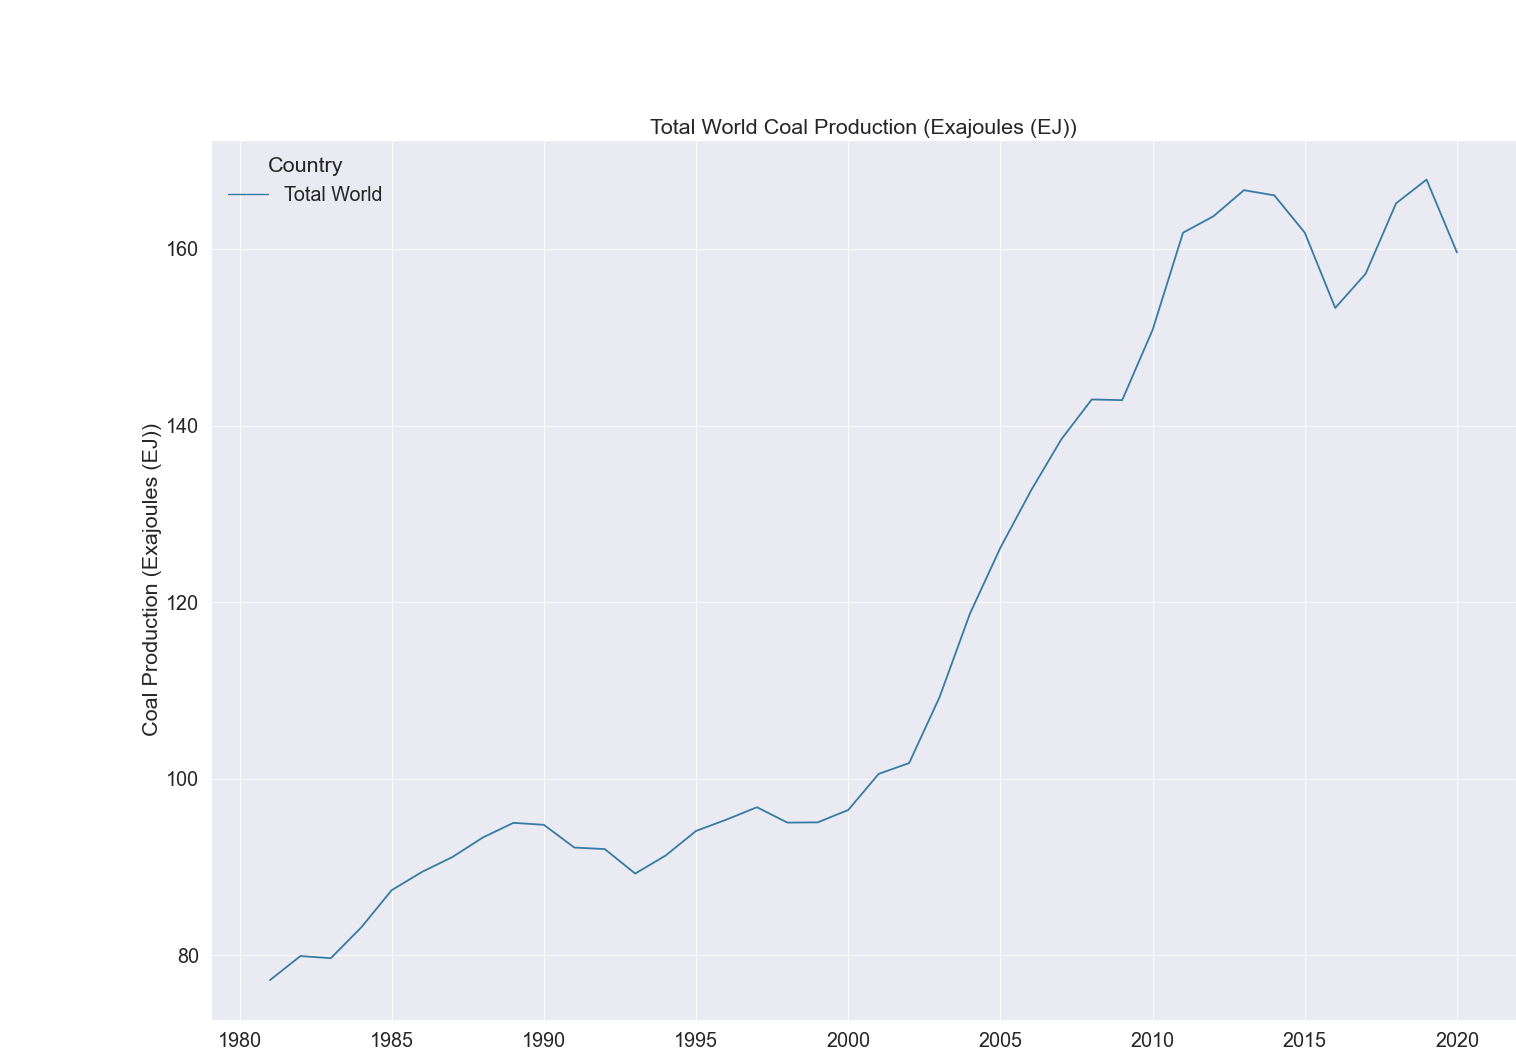

In [242]:
plt.style.use('seaborn')
plt.figure(figsize=(26,18))
sns.set(font_scale = 2)
sns.lineplot(data=total_world_coal_prod_pivot.reset_index(), x='Year', y='Exajoules', hue='Country', palette='mako', linewidth= 2.0)
plt.ylabel('Coal Production (Exajoules (EJ))')
plt.title('Total World Coal Production (Exajoules (EJ))')
plt.show()

### Coal Production by Country

In [243]:
i1 = ds_coal_production[((ds_coal_production.Country == 'Total World'))].index
i1

Int64Index([55], dtype='int64')

In [244]:
country_coal_prod = ds_coal_production.iloc[0:54]

In [245]:
tot_s = country_coal_prod[((country_coal_prod.Country == 'Total S. & Cent. America'))].index
tot_n = country_coal_prod[((country_coal_prod.Country == 'Total North America'))].index
totalcis = country_coal_prod[((country_coal_prod.Country == 'Total CIS'))].index
tot_me = country_coal_prod[((country_coal_prod.Country == 'Total Middle East'))].index
tot_af = country_coal_prod[((country_coal_prod.Country == 'Total Africa'))].index
tot_as = country_coal_prod[((country_coal_prod.Country == 'Total Asia Pacific'))].index
tot_eu = country_coal_prod[((country_coal_prod.Country == 'Total Europe'))].index

country_coal_production = country_coal_prod.drop(tot_s)
country_coal_production = country_coal_production.drop(tot_n)
country_coal_production = country_coal_production.drop(totalcis)
country_coal_production = country_coal_production.drop(tot_me)
country_coal_production = country_coal_production.drop(tot_af)
country_coal_production = country_coal_production.drop(tot_as)
country_coal_production = country_coal_production.drop(tot_eu)

In [246]:
country_coal_production_melt = country_coal_production.melt(id_vars=['Country'], var_name='Year', value_name='Exajoules')
country_coal_production_pivoted= country_coal_production_melt.pivot_table(index=['Country', 'Year'])
country_coal_production_pivoted.dropna()

Exajoules
Country   Year           
Australia 1981   2.838856
          1982   2.897835
          1983   3.019467
          1984   3.171302
          1985   3.867644
...                   ...
Zimbabwe  2016   0.072937
          2017   0.079046
          2018   0.090378
          2019   0.070920
          2020   0.088550

[1518 rows x 1 columns]

                Exajoules
Country   Year           
Australia 1981   2.838856
          1982   2.897835
          1983   3.019467
          1984   3.171302
          1985   3.867644
Exajoules    0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1518 entries, ('Australia', 1981) to ('Zimbabwe', 2020)
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Exajoules  1518 non-null   float64
dtypes: float64(1)
memory usage: 15.6+ KB
None
         Exajoules
count  1518.000000
mean      3.093079
std       8.659342
min       0.001223
25%       0.110799
50%       0.367416
75%       1.973491
max      80.910288


<IPython.core.display.Javascript object>


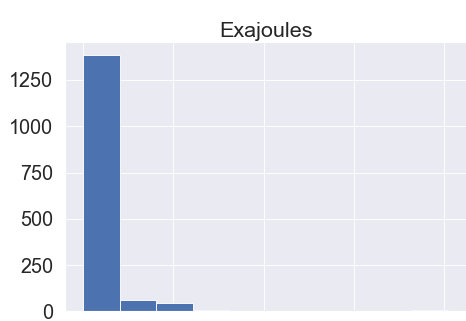

[[<AxesSubplot:title={'center':'Exajoules'}>]]


In [247]:
brief_summary(country_coal_production_pivoted)

In [250]:
# Top 10 countries with the most coal production
top_10_coal_production = country_coal_production_pivoted.nlargest(10, ['Exajoules'])
top_10_coal_production

Exajoules
Country Year           
China   2020  80.910288
        2019  79.755979
        2013  79.322888
        2012  78.441490
        2014  78.050746
        2011  77.526242
        2018  76.870620
        2015  76.586254
        2017  73.173994
        2016  70.816435

In [251]:
# Top 50 countries with the most coal production
top_50_coal_production = country_coal_production_pivoted.nlargest(50, ['Exajoules'])
top_50_coal_production

Exajoules
Country Year           
China   2020  80.910288
        2019  79.755979
        2013  79.322888
        2012  78.441490
        2014  78.050746
        2011  77.526242
        2018  76.870620
        2015  76.586254
        2017  73.173994
        2016  70.816435
        2010  69.722096
        2009  64.387267
        2008  62.457418
        2007  60.259914
        2006  55.618395
        2005  51.987565
        2004  46.345428
        2003  39.579487
        2002  33.506359
        2001  31.374827
        2000  29.614002
        1996  29.238505
        1997  29.046580
        1999  28.553919
        1995  28.485543
        1998  27.884687
        1994  25.956088
US      1998  24.100572
China   1993  24.088126
US      2008  23.906306
        2006  23.844306
        2001  23.601314
        2007  23.546840
China   1992  23.370299
US      1997  23.363302
        1999  23.348725
        2005  23.238584
        2004  22.904731
        1996  22.842646
        2000  22.787849
        2002  22.784590
China   1991  22.763757
        1990  22.606271
US      1990  22.539338
        2011  22.272584
        1994  22.253216
        1995  22.180521
        2003  22.144544
        2010  22.088981
China   1989  22.068623

## Coal Reserves

In [252]:
coal_reserves = pd.read_excel(xls, 'Coal - Reserves', header=[3])
coal_reserves.head()

Million tonnes  and bituminous  and lignite     Total  Share of Total  \
0                  NaN             NaN          NaN       NaN             NaN   
1               Canada          4346.0       2236.0    6582.0        0.006128   
2               Mexico          1160.0         51.0    1211.0        0.001127   
3                   US        218938.0      30003.0  248941.0        0.231765   
4  Total North America        224444.0      32290.0  256734.0        0.239021   

    R/P ratio  Unnamed: 6  Unnamed: 7  
0         NaN         NaN         NaN  
1  166.421175         NaN         NaN  
2  184.999433         NaN         NaN  
3  513.586566         NaN         NaN  
4  483.667222         NaN         NaN

In [253]:
coal_reserves = coal_reserves.drop(0)

In [254]:
coal_reserves.rename({'Million tonnes':'Country'}, axis=1, inplace=True)
coal_reserves.rename({'and bituminous':'Anthracite and bituminous'}, axis=1, inplace=True)
coal_reserves.rename({'and lignite':'Sub-bituminous'}, axis=1, inplace=True)
coal_reserves

Country  \
1                                              Canada   
2                                              Mexico   
3                                                  US   
4                                 Total North America   
5                                                 NaN   
..                                                ...   
64  nor does it necessarily represent BP’s view of...   
65  Reserves-to-production (R/P) ratio - If the re...   
66  that those remaining reserves would last if pr...   
67  Reserves-to-production (R/P) ratios are calcul...   
68  Shares of total and R/P ratios are calculated ...   

    Anthracite and bituminous  Sub-bituminous     Total  Share of Total  \
1                      4346.0          2236.0    6582.0        0.006128   
2                      1160.0            51.0    1211.0        0.001127   
3                    218938.0         30003.0  248941.0        0.231765   
4                    224444.0         32290.0  256734.0        0.239021   
5                         NaN             NaN       NaN             NaN   
..                        ...             ...       ...             ...   
64                        NaN             NaN       NaN             NaN   
65                        NaN             NaN       NaN             NaN   
66                        NaN             NaN       NaN             NaN   
67                        NaN             NaN       NaN             NaN   
68                        NaN             NaN       NaN             NaN   

     R/P ratio  Unnamed: 6  Unnamed: 7  
1   166.421175         NaN         NaN  
2   184.999433         NaN         NaN  
3   513.586566         NaN         NaN  
4   483.667222         NaN         NaN  
5          NaN         NaN         NaN  
..         ...         ...         ...  
64         NaN         NaN         NaN  
65         NaN         NaN         NaN  
66         NaN         NaN         NaN  
67         NaN         NaN         NaN  
68         NaN         NaN         NaN  

[68 rows x 8 columns]

In [255]:
coal_reserves = coal_reserves.drop(columns ='Unnamed: 6')
coal_reserves = coal_reserves.drop(columns ='Unnamed: 7')

In [256]:
coal_reserves.Country.unique()

array(['Canada', 'Mexico', 'US', 'Total North America', nan, 'Brazil',
       'Colombia', 'Venezuela', 'Other S. & Cent. America',
       'Total S. & Cent. America', 'Bulgaria', 'Czech Republic',
       'Germany', 'Greece', 'Hungary', 'Poland', 'Romania', 'Serbia',
       'Spain', 'Turkey', 'Ukraine', 'United Kingdom', 'Other Europe',
       'Total Europe ', 'Kazakhstan', 'Russian Federation', 'Uzbekistan',
       'Other CIS', 'Total CIS', 'South Africa', 'Zimbabwe',
       'Other Africa', 'Middle East', 'Total Middle East & Africa',
       'Australia', 'China', 'India', 'Indonesia', 'Japan', 'Mongolia',
       'New Zealand', 'Pakistan', 'South Korea', 'Thailand', 'Vietnam',
       'Other Asia Pacific', 'Total Asia Pacific', 'Total World',
       'of which: OECD', '                 Non-OECD',
       '                 European Union ',
       'Source: statistics are taken from national statistical agencies, international organizations, and other proprietary sources. Includes data from F

In [257]:
i = coal_reserves[((coal_reserves.Country == 'Total World'))].index
i

Int64Index([53], dtype='int64')

In [258]:
coal_reserves = coal_reserves.iloc[0:52]

### Coal Reserves by Country

In [259]:
sca = coal_reserves[((coal_reserves.Country == 'Total S. & Cent. America'))].index
na = coal_reserves[((coal_reserves.Country == 'Total North America'))].index
cis_ = coal_reserves[((coal_reserves.Country == 'Total CIS'))].index
mid_ = coal_reserves[((coal_reserves.Country == 'Total Middle East & Africa'))].index
asi_ = coal_reserves[((coal_reserves.Country == 'Total Asia Pacific'))].index
eu_ = coal_reserves[((coal_reserves.Country == 'Total Europe'))].index

country_coal_reserves = coal_reserves.drop(sca)
country_coal_reserves = country_coal_reserves.drop(na)
country_coal_reserves = country_coal_reserves.drop(cis_)
country_coal_reserves = country_coal_reserves.drop(mid_)

In [260]:
country_coal_reserve = country_coal_reserves.drop(asi_)
country_coal_reserves_ = country_coal_reserve.drop(eu_)

In [261]:
coal_reserves_indexed = country_coal_reserves_.set_index('Country')

In [262]:
coal_reserves_indexed.dropna()

Anthracite and bituminous  Sub-bituminous     Total  \
Country                                                                         
Canada                                       4346.0          2236.0    6582.0   
Mexico                                       1160.0            51.0    1211.0   
US                                         218938.0         30003.0  248941.0   
Brazil                                       1547.0          5049.0    6596.0   
Colombia                                     4554.0             0.0    4554.0   
Venezuela                                     731.0             0.0     731.0   
Other S. & Cent. America                     1784.0            24.0    1808.0   
Bulgaria                                      192.0          2174.0    2366.0   
Czech Republic                               1081.0          2514.0    3595.0   
Germany                                         0.0         35900.0   35900.0   
Greece                                          0.0          2876.0    2876.0   
Hungary                                       276.0          2633.0    2909.0   
Poland                                      22530.0          5865.0   28395.0   
Romania                                        11.0           280.0     291.0   
Serbia                                        402.0          7112.0    7514.0   
Spain                                         868.0           319.0    1187.0   
Turkey                                        550.0         10975.0   11525.0   
Ukraine                                     32039.0          2336.0   34375.0   
United Kingdom                                 26.0             0.0      26.0   
Other Europe                                 1109.0          5172.0    6281.0   
Total Europe                                59084.0         78156.0  137240.0   
Kazakhstan                                  25605.0             0.0   25605.0   
Russian Federation                          71719.0         90447.0  162166.0   
Uzbekistan                                   1375.0             0.0    1375.0   
Other CIS                                    1509.0             0.0    1509.0   
South Africa                                 9893.0             0.0    9893.0   
Zimbabwe                                      502.0             0.0     502.0   
Other Africa                                 4376.0            66.0    4442.0   
Middle East                                  1203.0             0.0    1203.0   
Australia                                   73719.0         76508.0  150227.0   
China                                      135069.0          8128.0  143197.0   
India                                      105979.0          5073.0  111052.0   
Indonesia                                   23141.0         11728.0   34869.0   
Japan                                         340.0            10.0     350.0   
Mongolia                                     1170.0          1350.0    2520.0   
New Zealand                                   825.0          6750.0    7575.0   
Pakistan                                      207.0          2857.0    3064.0   
South Korea                                   326.0             0.0     326.0   
Thailand                                        0.0          1063.0    1063.0   
Vietnam                                      3116.0           244.0    3360.0   
Other Asia Pacific                           1421.0           726.0    2147.0   

                          Share of Total    R/P ratio  
Country                                                
Canada                          0.006128   166.421175  
Mexico                          0.001127   184.999433  
US                              0.231765   513.586566  
Brazil                          0.006141  1396.459987  
Colombia                        0.004240    89.989913  
Venezuela                       0.000681  1049.348700  
Other S. & Cent. America        0.001683  1763.745010  
Bulgaria                        0.0022

         Anthracite and bituminous  Sub-bituminous     Total  Share of Total  \
Country                                                                        
Canada                      4346.0          2236.0    6582.0        0.006128   
Mexico                      1160.0            51.0    1211.0        0.001127   
US                        218938.0         30003.0  248941.0        0.231765   
NaN                            NaN             NaN       NaN             NaN   
Brazil                      1547.0          5049.0    6596.0        0.006141   

           R/P ratio  
Country               
Canada    166.421175  
Mexico    184.999433  
US        513.586566  
NaN              NaN  
Brazil   1396.459987  
Anthracite and bituminous    0.12766
Sub-bituminous               0.12766
Total                        0.12766
Share of Total               0.12766
R/P ratio                    0.12766
dtype: float64
<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, Canada to nan
Data co

<IPython.core.display.Javascript object>


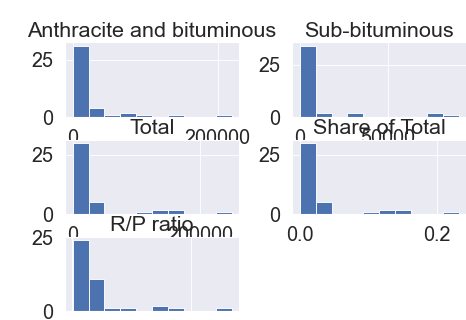

[[<AxesSubplot:title={'center':'Anthracite and bituminous'}>
  <AxesSubplot:title={'center':'Sub-bituminous'}>]
 [<AxesSubplot:title={'center':'Total'}>
  <AxesSubplot:title={'center':'Share of Total'}>]
 [<AxesSubplot:title={'center':'R/P ratio'}> <AxesSubplot:>]]


In [263]:
brief_summary(coal_reserves_indexed)

## II. Oil

A country with large amounts of reserves does not always translate to strong production numbers for petroleum, oil, and by-products. Oil reserves simply serve as an estimate of the amount of economically recoverable crude oil in a particular region. To qualify, these reserves must have the potential of being extracted under current technological constraints. While countries like the U.S. and Russia are low on the list of oil reserves, they rank highly in terms of oil production. More than 95 million barrels of oil were produced globally every day in 2019, and the U.S., Saudi Arabia, and Russia are among the world’s top oil-producing countries, respectively. [Visual Capitalist](https://www.visualcapitalist.com/ranking-the-countries-with-the-largest-proven-global-oil-reserves-in-the-world/)

According to this [Youtube](https://www.youtube.com/watch?v=dw1fiXc6Qs0) video, if Asia were to catch up to U.S. diesel/oil consumption rates, the global production would 'have to rise by 300% per day'. It is because of diesel, fertilizer, and heavy equipment, farming yield rates increased 250% during the 1950s. Hence without oil, modern agriculture will not be able to feed the current world poppulation (also the fishing industry will seize to stop working if the price of diesel is too high). 

In [264]:
oil_data = power_plant_data[((power_plant_data.primary_fuel == 'Oil'))]
oil_data.head()

country country_long             name   gppd_idnr  capacity_mw  latitude  \
76     AGO       Angola           Biopio  WRI1023002        22.80  -12.4706   
81     AGO       Angola           Huambo  WRI1023006        16.26  -12.7600   
83     AGO       Angola    Luanda Diesel  WRI1023008        58.00   -8.8383   
84     AGO       Angola  Luanda Refinery  WRI1023009        18.50   -8.8383   
85     AGO       Angola          Malongo  WRI1023010        10.00   -5.5500   

    longitude primary_fuel other_fuel1 other_fuel2  ...  \
76    13.7319          Oil         NaN         NaN  ...   
81    15.7500          Oil         NaN         NaN  ...   
83    13.2344          Oil         NaN         NaN  ...   
84    13.2344          Oil         NaN         NaN  ...   
85    12.2000          Oil         NaN         NaN  ...   

   estimated_generation_gwh_2013  estimated_generation_gwh_2014  \
76                           NaN                            NaN   
81                           NaN                            NaN   
83                           NaN                            NaN   
84                           NaN                            NaN   
85                           NaN                            NaN   

   estimated_generation_gwh_2015 estimated_generation_gwh_2016  \
76                           NaN                           NaN   
81                           NaN                           NaN   
83                           NaN                           NaN   
84                           NaN                           NaN   
85                           NaN                           NaN   

   estimated_generation_gwh_2017 estimated_generation_note_2013  \
76                         64.92                  NO-ESTIMATION   
81                         46.30                  NO-ESTIMATION   
83                        165.16                  NO-ESTIMATION   
84                         52.68                  NO-ESTIMATION   
85                         28.47                  NO-ESTIMATION   

   estimated_generation_note_2014  estimated_generation_note_2015  \
76                  NO-ESTIMATION                   NO-ESTIMATION   
81                  NO-ESTIMATION                   NO-ESTIMATION   
83                  NO-ESTIMATION                   NO-ESTIMATION   
84                  NO-ESTIMATION                   NO-ESTIMATION   
85                  NO-ESTIMATION                   NO-ESTIMATION   

    estimated_generation_note_2016  estimated_generation_note_2017  
76                   NO-ESTIMATION              CAPACITY-FACTOR-V1  
81                   NO-ESTIMATION              CAPACITY-FACTOR-V1  
83                   NO-ESTIMATION              CAPACITY-FACTOR-V1  
84                   NO-ESTIMATION              CAPACITY-FACTOR-V1  
85                   NO-ESTIMATION              CAPACITY-FACTOR-V1  

[5 rows x 36 columns]

In [265]:
# Making separate dataset for capacity_mw; will use later for combined table
oil_subset = oil_data[['country_long','capacity_mw']]

In [266]:
oil_data.isnull().sum()/len(oil_data)

country                           0.000000
country_long                      0.000000
name                              0.000000
gppd_idnr                         0.000000
capacity_mw                       0.000000
latitude                          0.000000
longitude                         0.000000
primary_fuel                      0.000000
other_fuel1                       0.909483
other_fuel2                       0.994828
other_fuel3                       0.999138
commissioning_year                0.309052
owner                             0.375000
source                            0.000000
url                               0.000000
geolocation_source                0.002155
wepp_id                           0.484052
year_of_capacity_data             0.251293
generation_gwh_2013               0.661638
generation_gwh_2014               0.662069
generation_gwh_2015               0.646121
generation_gwh_2016               0.635345
generation_gwh_2017               0.641379
generation_

In [267]:
oil_data = oil_data.drop(columns='other_fuel1')
oil_data = oil_data.drop(columns='other_fuel2')
oil_data = oil_data.drop(columns='other_fuel3')

In [268]:
est_gen_gwh_oil = oil_data[['country_long','estimated_generation_gwh_2017']]

In [269]:
# eliminate NaN's
est_gen_gwh_oil = est_gen_gwh_oil[est_gen_gwh_oil['estimated_generation_gwh_2017'].notna()]
est_gen_gwh_oil = est_gen_gwh_oil[est_gen_gwh_oil['estimated_generation_gwh_2017'] != 'nan']
est_gen_gwh_oil

country_long  estimated_generation_gwh_2017
76          Angola                          64.92
81          Angola                          46.30
83          Angola                         165.16
84          Angola                          52.68
85          Angola                          28.47
...            ...                            ...
34925       Zambia                          53.66
34926       Zambia                          55.13
34929       Zambia                          36.75
34931       Zambia                         183.79
34932       Zambia                          73.51

[2263 rows x 2 columns]

  country_long  estimated_generation_gwh_2017
0       Angola                      64.970000
1    Argentina                      56.593958
2    Australia                      50.560238
3   Azerbaijan                    1260.900000
4      Bahrain                       0.040000
country_long                     0.0
estimated_generation_gwh_2017    0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   country_long                   82 non-null     object 
 1   estimated_generation_gwh_2017  82 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.4+ KB
None
       estimated_generation_gwh_2017
count                      82.000000
mean                      516.550412
std                       883.693857
min                         0.000000
25%                        36.043250
50%           

<IPython.core.display.Javascript object>


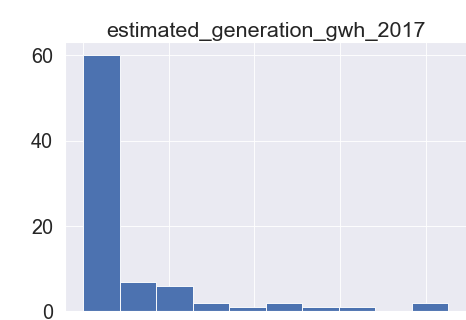

[[<AxesSubplot:title={'center':'estimated_generation_gwh_2017'}>]]


In [270]:
est_gen_gwh_oil_avg = est_gen_gwh_oil.groupby('country_long').mean().reset_index()
brief_summary(est_gen_gwh_oil_avg)

#### Top 10 Countries with highest estimated generation gwh for 2017 - Oil

In [271]:
top_gwh_2017_oil = est_gen_gwh_oil_avg.nlargest(10, ['estimated_generation_gwh_2017'])
top_gwh_2017_oil

country_long  estimated_generation_gwh_2017
69                Taiwan                    4264.880000
38                  Iraq                    4091.345000
63           South Korea                    3221.960000
42                 Japan                    2837.236154
59          Saudi Arabia                    2524.175849
68  Syrian Arab Republic                    2432.105714
37                  Iran                    1732.081111
54              Pakistan                    1632.669286
57                Poland                    1294.015000
3             Azerbaijan                    1260.900000

### Capacity Mw - Oil

In [272]:
oil_subset = oil_subset[oil_subset['capacity_mw'].notna()]
oil_subset = oil_subset[oil_subset['capacity_mw'] != 'nan']
oil_subset

country_long  capacity_mw
76          Angola        22.80
81          Angola        16.26
83          Angola        58.00
84          Angola        18.50
85          Angola        10.00
...            ...          ...
34925       Zambia        14.60
34926       Zambia        15.00
34929       Zambia        10.00
34931       Zambia        50.00
34932       Zambia        20.00

[2320 rows x 2 columns]

  country_long  capacity_mw
0       Angola    22.816667
1   Antarctica     6.600000
2    Argentina    12.492594
3    Australia    26.180238
4   Azerbaijan  2400.000000
country_long    0.0
capacity_mw     0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_long  105 non-null    object 
 1   capacity_mw   105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB
None
       capacity_mw
count   105.000000
mean    267.795096
std     434.992718
min       6.600000
25%      30.700000
50%      99.887200
75%     265.800000
max    2400.000000


<IPython.core.display.Javascript object>


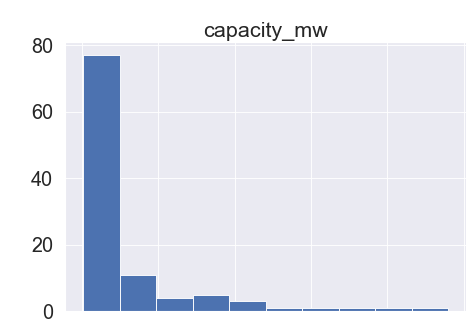

[[<AxesSubplot:title={'center':'capacity_mw'}>]]


In [273]:
oil_subset_avg = oil_subset.groupby('country_long').mean().reset_index()
brief_summary(oil_subset_avg)

In [275]:
top_oil_capacity = oil_subset_avg.nlargest(10, ['capacity_mw'])
top_oil_capacity

country_long  capacity_mw
4     Azerbaijan  2400.000000
89        Taiwan  2000.000000
54         Japan  1696.930769
83   South Korea  1551.666667
81     Singapore  1316.666667
95  Turkmenistan  1137.500000
82  South Africa  1033.500000
50          Iraq  1006.666667
78  Saudi Arabia   937.781698
32       Estonia   920.500000

## Oil Consumption

This next data comes from the [Statistical Review of World Energy](https://www.bp.com/en/global/corporate/energy-economics/statistical-review-of-world-energy/downloads.html) by BP. 

In [276]:
ds_oil_consumption = pd.read_excel(xls, 'Oil Consumption - Barrels', header=[2])
ds_oil_consumption.head()

Thousand barrels daily          1965          1966          1967  \
0                    NaN           NaN           NaN           NaN   
1                 Canada   1108.116301   1167.468795   1245.557068   
2                 Mexico    315.871088    333.048484    357.305957   
3                     US  11512.436000  12084.373000  12560.345000   
4    Total North America  12936.423389  13584.890278  14163.208026   

           1968          1969          1970          1971          1972  \
0           NaN           NaN           NaN           NaN           NaN   
1   1322.157350   1380.190329   1471.579753   1512.128247   1588.909235   
2    386.144762    410.021906    440.735987    467.284852    523.353166   
3  13392.866000  14136.795000  14697.186000  15212.493000  16366.984000   
4  15101.168112  15927.007234  16609.501741  17191.906098  18479.246401   

           1973  ...          2016          2017          2018          2019  \
0           NaN  ...           NaN           NaN           NaN           NaN   
1   1754.885644  ...   2452.037349   2422.998806   2500.806350   2536.766731   
2    564.177805  ...   1950.178577   1883.227421   1835.957946   1698.196457   
3  17307.679000  ...  18622.304626  18877.537534  19446.748247  19475.375148   
4  19626.742450  ...  23024.520552  23183.763761  23783.512543  23710.338336   

           2020    2020.1   2009-19    2020.2  Unnamed: 60  Unnamed: 61  
0           NaN       NaN       NaN       NaN          NaN          NaN  
1   2282.478848 -0.100241  0.010526  0.025797          NaN          NaN  
2   1312.288887 -0.227246 -0.017268  0.014832          NaN          NaN  
3  17177.647623 -0.117981  0.007739  0.194147          NaN          NaN  
4  20772.415358 -0.123909  0.005987  0.234777          NaN          NaN  

[5 rows x 62 columns]

In [277]:
ds_oil_consumption = ds_oil_consumption.drop(0)

In [278]:
ds_oil_consumption.rename({'Thousand barrels daily':'Country'}, axis=1, inplace=True)

In [279]:
ds_oil_consumption['Country'].unique()

array(['Canada', 'Mexico', 'US', 'Total North America', nan, 'Argentina',
       'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Peru',
       'Trinidad & Tobago', 'Venezuela', 'Central America',
       'Other Caribbean', 'Other South America',
       'Total S. & Cent. America', 'Austria', 'Belgium', 'Bulgaria',
       'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia',
       'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland',
       'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg',
       'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal',
       'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden',
       'Switzerland', 'Turkey', 'Ukraine', 'United Kingdom',
       'Other Europe ', 'Total Europe ', 'Azerbaijan', 'Belarus',
       'Kazakhstan', 'Russian Federation', 'Turkmenistan', 'USSR',
       'Uzbekistan', 'Other CIS', 'Total CIS', 'Iran', 'Iraq', 'Israel',
       'Kuwait', 'Oman', 'Qatar', 'Saudi Arabia', 'United Arab Emirates',
       'Other

### Total World Oil Consumption

In [280]:
ds_oil_consumption = ds_oil_consumption.drop(columns='Unnamed: 60')
ds_oil_consumption = ds_oil_consumption.drop(columns='Unnamed: 61')
ds_oil_consumption = ds_oil_consumption.drop(columns='2020.1')
ds_oil_consumption = ds_oil_consumption.drop(columns='2009-19')
ds_oil_consumption = ds_oil_consumption.drop(columns='2020.2')

In [281]:
i = ds_oil_consumption[((ds_oil_consumption.Country == 'Total World'))].index
i

Int64Index([107], dtype='int64')

In [282]:
ds_oil_consumption = ds_oil_consumption.iloc[0:107]

In [283]:
i3 = ds_oil_consumption[((ds_oil_consumption.Country == 'Total Africa'))]
i3

Country        1965        1966        1967        1968        1969  \
85  Total Africa  552.231932  603.237323  601.077565  632.618907  646.668008   

          1970        1971        1972        1973  ...         2011  \
85  712.363137  803.975551  870.740588  938.441846  ...  3382.602777   

           2012         2013         2014         2015         2016  \
85  3553.162319  3691.358104  3748.764759  3877.485951  3905.762584   

           2017         2018         2019         2020  
85  3955.858173  4044.572553  4097.654891  3558.994372  

[1 rows x 57 columns]

In [284]:
i4 = ds_oil_consumption[((ds_oil_consumption.Country == 'Total S. & Cent. America'))]

In [285]:
i5 = ds_oil_consumption[((ds_oil_consumption.Country == 'Total Europe '))]
i5

Country         1965         1966         1967          1968  \
53  Total Europe   8219.067934  9037.460259  9825.686232  10775.430263   

            1969          1970          1971          1972          1973  ...  \
53  12030.565864  13323.154587  13999.892651  14952.103718  16075.728601  ...   

            2011          2012          2013          2014          2015  \
53  14914.058587  14393.100572  14222.518589  13979.673921  14319.270053   

            2016         2017          2018          2019          2020  
53  14619.030145  14929.17009  14908.107057  14826.244243  12787.502921  

[1 rows x 57 columns]

In [286]:
i6 = ds_oil_consumption[((ds_oil_consumption.Country == 'Total CIS'))]

In [287]:
i7 = ds_oil_consumption[((ds_oil_consumption.Country == 'Total Middle East'))]

In [288]:
i8 = ds_oil_consumption[((ds_oil_consumption.Country == 'Total Asia Pacific'))]

In [289]:
i9 = ds_oil_consumption[((ds_oil_consumption.Country == 'Total North America'))]

In [290]:
africa_asia2 = i8.append(i3, ignore_index=True)

In [291]:
southcentamer_euro = i4.append(i5, ignore_index=True)

In [292]:
first_four2 = africa_asia2.append(southcentamer_euro, ignore_index=True)
first_four2

Country         1965         1966         1967  \
0        Total Asia Pacific  3243.521563  3701.321911  4308.750415   
1              Total Africa   552.231932   603.237323   601.077565   
2  Total S. & Cent. America  1690.022296  1785.261366  1843.748644   
3             Total Europe   8219.067934  9037.460259  9825.686232   

           1968          1969          1970          1971          1972  \
0   4910.909350   5723.982779   6654.569969   7402.361613   7949.387963   
1    632.618907    646.668008    712.363137    803.975551    870.740588   
2   1965.301823   2057.070433   2166.530035   2290.068143   2472.156651   
3  10775.430263  12030.565864  13323.154587  13999.892651  14952.103718   

           1973  ...          2011          2012          2013          2014  \
0   9067.827714  ...  28657.508082  29814.565702  30420.993215  30910.506928   
1    938.441846  ...   3382.602777   3553.162319   3691.358104   3748.764759   
2   2710.286197  ...   6064.762277   6260.390420   6490.587479   6478.152091   
3  16075.728601  ...  14914.058587  14393.100572  14222.518589  13979.673921   

           2015          2016          2017          2018          2019  \
0  32332.455488  33522.794504  34690.365196  35329.745427  35697.881676   
1   3877.485951   3905.762584   3955.858173   4044.572553   4097.654891   
2   6376.512959   6150.669812   6135.825395   6000.155934   5888.710932   
3  14319.270053  14619.030145  14929.170090  14908.107057  14826.244243   

           2020  
0  33615.296109  
1   3558.994372  
2   5273.759800  
3  12787.502921  

[4 rows x 57 columns]

In [293]:
cis_mideast = i6.append(i7, ignore_index=True)

In [294]:
last_three2 = i9.append(cis_mideast, ignore_index=True)

In [295]:
total_world_oil_consumption  = first_four2.append(last_three2, ignore_index=True)
total_world_oil_consumption.Country.unique()

array(['Total Asia Pacific', 'Total Africa', 'Total S. & Cent. America',
       'Total Europe ', 'Total North America', 'Total CIS',
       'Total Middle East'], dtype=object)

#### Total World Oil Consumption

In [296]:
# Separate dataset for the 'total world'
total_world_subset_consumption = ds_oil_consumption[((ds_oil_consumption.Country == 'Total World'))]
total_world_subset_consumption_melt = total_world_subset_consumption.melt(id_vars=['Country'], var_name='Year', value_name='Barrels_daily')
total_world_subset_pivoted= total_world_subset_consumption_melt.pivot_table(index=['Country', 'Year'])
total_world_subset_pivoted.dropna()

Barrels_daily
Country     Year               
Total World 1965   30818.568204
            1966   33148.253861
            1967   35524.047797
            1968   38435.859065
            1969   41737.989444
            1970   45327.603980
            1971   47903.690964
            1972   51440.192921
            1973   55664.730392
            1974   54911.986166
            1975   54448.935168
            1976   57755.294019
            1977   59956.370484
            1978   63063.474753
            1979   64179.283495
            1980   61453.533745
            1981   59642.554586
            1982   58025.246285
            1983   57801.795710
            1984   59025.030982
            1985   59391.486125
            1986   61168.437779
            1987   62495.625856
            1988   64445.914280
            1989   65676.344080
            1990   66343.402843
            1991   66477.726206
            1992   67432.276798
            1993   67370.321255
            1994   68997.224618
            1995   70297.958759
            1996   71727.473510
            1997   73908.502497
            1998   74189.704461
            1999   75769.968625
            2000   76494.583597
            2001   77365.499298
            2002   78237.153146
            2003   79909.712355
            2004   82736.118847
            2005   83691.092685
            2006   84656.849952
            2007   85895.802605
            2008   84814.463733
            2009   83687.811045
            2010   86568.355012
            2011   87529.743460
            2012   88607.221356
            2013   89988.226558
            2014   90677.057731
            2015   92786.570672
            2016   94380.691923
            2017   96099.428754
            2018   97264.795876
            2019   97598.318398
            2020   88477.357543

<IPython.core.display.Javascript object>


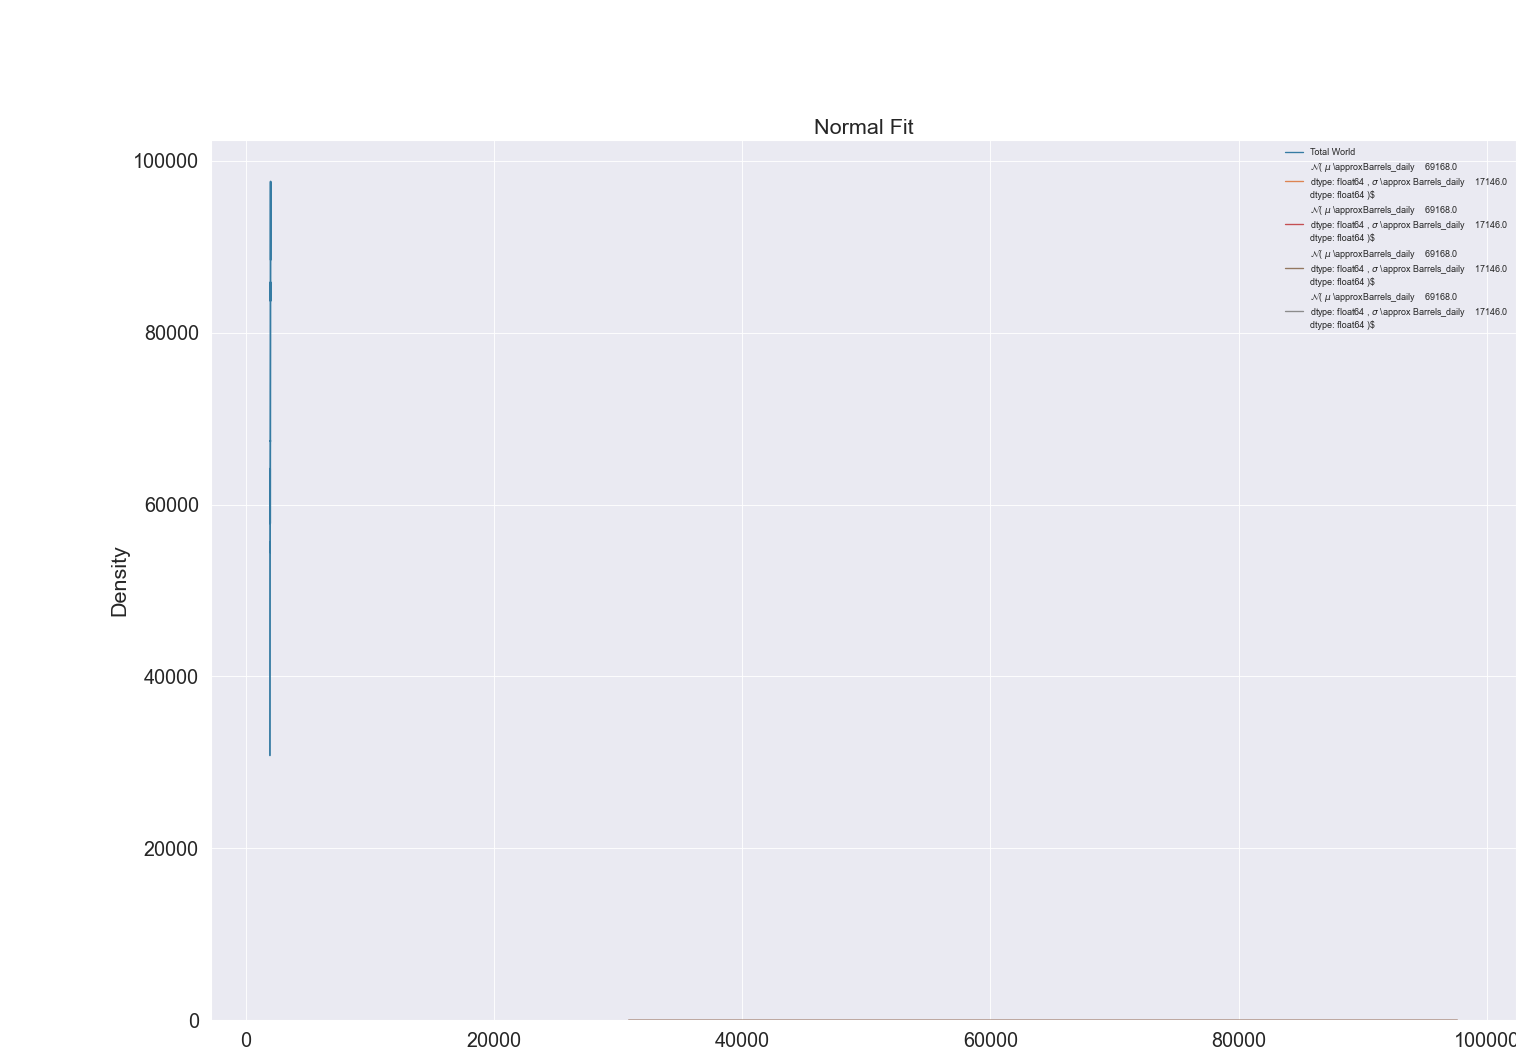

In [297]:
plt.style.use('seaborn')
plt.figure(figsize=(26,18))
sns.set(font_scale = 2)
sns.lineplot(data=total_world_subset_pivoted.reset_index(), x='Year', y='Barrels_daily', hue='Country', palette='mako', linewidth= 2.0)
plt.ylabel('Oil Consumption (barrels/day)')
plt.title('Total World Oil Consumption (barrels/day)')
plt.show()

In [304]:
normal_fit(total_world_subset_pivoted)

<IPython.core.display.Javascript object>


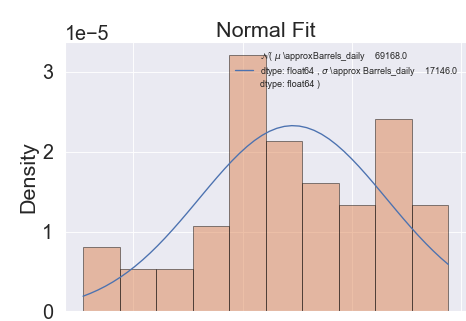

In [306]:
from scipy.stats import norm
from matplotlib import pyplot as plt
%matplotlib notebook

# Sample std and mu
std1 = np.std(total_world_subset_pivoted, ddof=1)
mean1 = np.mean(total_world_subset_pivoted)

# Plot
worldx = np.linspace(np.min(total_world_subset_pivoted), np.max(total_world_subset_pivoted))
plt.plot(worldx, norm.pdf(worldx, mean1, std1), 
        label= '$\mathcal{N} ' + f'$( $\mu$ \\approx{round(mean1)} , $\sigma$ \\approx {round(std1)} )')
plt.hist(total_world_subset_pivoted, edgecolor='black', alpha=0.5, density=True)
plt.title("Normal Fit")
plt.xlabel("value")
plt.ylabel("Density")
plt.legend(loc=1, prop={'size': 10})
plt.show()

In [307]:
total_world_oil_consumption_melt = total_world_oil_consumption.melt(id_vars=['Country'], var_name='Year', value_name='Barrels_daily')
total_world_oil_consumption_melt

Country  Year  Barrels_daily
0          Total Asia Pacific  1965    3243.521563
1                Total Africa  1965     552.231932
2    Total S. & Cent. America  1965    1690.022296
3               Total Europe   1965    8219.067934
4         Total North America  1965   12936.423389
..                        ...   ...            ...
387  Total S. & Cent. America  2020    5273.759800
388             Total Europe   2020   12787.502921
389       Total North America  2020   20772.415358
390                 Total CIS  2020    4148.832934
391         Total Middle East  2020    8320.556048

[392 rows x 3 columns]

In [308]:
total_world_oil_pivot_table = total_world_oil_consumption_melt.pivot_table(index=['Country', 'Year'])
total_world_oil_pivot_table.head()

Barrels_daily
Country      Year               
Total Africa 1965     552.231932
             1966     603.237323
             1967     601.077565
             1968     632.618907
             1969     646.668008

In [309]:
total_world_oil_pivot_table.dropna()

Barrels_daily
Country                  Year               
Total Africa             1965     552.231932
                         1966     603.237323
                         1967     601.077565
                         1968     632.618907
                         1969     646.668008
...                                      ...
Total S. & Cent. America 2016    6150.669812
                         2017    6135.825395
                         2018    6000.155934
                         2019    5888.710932
                         2020    5273.759800

[392 rows x 1 columns]

<IPython.core.display.Javascript object>


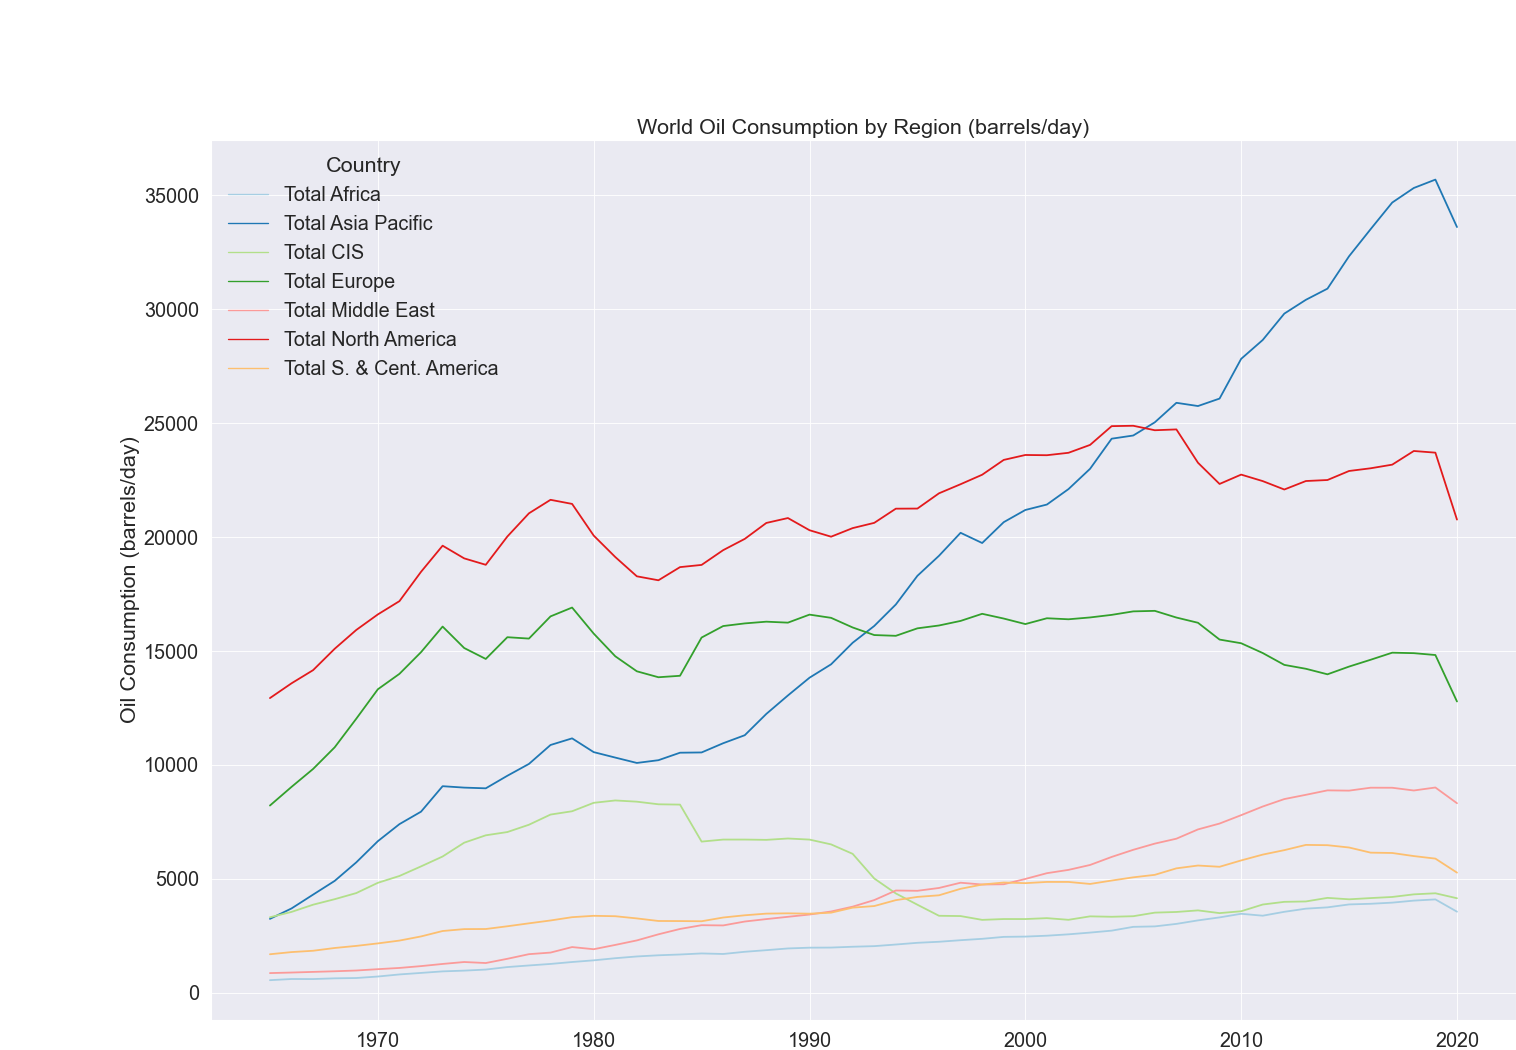

In [310]:
plt.style.use('seaborn')
plt.figure(figsize=(26,18))
sns.set(font_scale = 2)
sns.lineplot(data=total_world_oil_pivot_table.reset_index(), x='Year', y='Barrels_daily', hue='Country', palette='Paired', linewidth= 2.0)
plt.ylabel('Oil Consumption (barrels/day)')
plt.title('World Oil Consumption by Region (barrels/day)')
plt.show()

### Oil Consumption By Country

In [311]:
# Check
ds_oil_consumption['Country'].unique()

array(['Canada', 'Mexico', 'US', 'Total North America', nan, 'Argentina',
       'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Peru',
       'Trinidad & Tobago', 'Venezuela', 'Central America',
       'Other Caribbean', 'Other South America',
       'Total S. & Cent. America', 'Austria', 'Belgium', 'Bulgaria',
       'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia',
       'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland',
       'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg',
       'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal',
       'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden',
       'Switzerland', 'Turkey', 'Ukraine', 'United Kingdom',
       'Other Europe ', 'Total Europe ', 'Azerbaijan', 'Belarus',
       'Kazakhstan', 'Russian Federation', 'Turkmenistan', 'USSR',
       'Uzbekistan', 'Other CIS', 'Total CIS', 'Iran', 'Iraq', 'Israel',
       'Kuwait', 'Oman', 'Qatar', 'Saudi Arabia', 'United Arab Emirates',
       'Other

In [312]:
total_south = ds_oil_consumption[((ds_oil_consumption.Country == 'Total S. & Cent. America'))].index
country_oil_consumption = ds_oil_consumption.drop(total_south)

In [313]:
total_north = country_oil_consumption[((ds_oil_consumption.Country == 'Total North America'))].index
country_oil_consumption = country_oil_consumption.drop(total_north)

<ipython-input-313-286be120f024>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  total_north = country_oil_consumption[((ds_oil_consumption.Country == 'Total North America'))].index


In [314]:
total_cis = country_oil_consumption[((ds_oil_consumption.Country == 'Total CIS'))].index
country_oil_consumption = country_oil_consumption.drop(total_cis)

<ipython-input-314-3a25e75d1d88>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  total_cis = country_oil_consumption[((ds_oil_consumption.Country == 'Total CIS'))].index


In [315]:
total_asia = country_oil_consumption[((ds_oil_consumption.Country == 'Total Asia Pacific'))].index
country_oil_consumption = country_oil_consumption.drop(total_asia)

<ipython-input-315-b0021e9728b7>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  total_asia = country_oil_consumption[((ds_oil_consumption.Country == 'Total Asia Pacific'))].index


In [316]:
total_mideast = ds_oil_consumption[((ds_oil_consumption.Country == 'Total Middle East'))].index
country_oil_consumption = country_oil_consumption.drop(total_mideast)

In [317]:
total_africa = country_oil_consumption[((ds_oil_consumption.Country == 'Total Africa'))].index
country_oil_consumption = country_oil_consumption.drop(total_africa)

<ipython-input-317-2cbe2d42dd2c>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  total_africa = country_oil_consumption[((ds_oil_consumption.Country == 'Total Africa'))].index


In [318]:
total_euro = country_oil_consumption[((ds_oil_consumption.Country == 'Total Europe'))].index
country_oil_consumption = country_oil_consumption.drop(total_euro)

<ipython-input-318-cecb2ec022c0>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  total_euro = country_oil_consumption[((ds_oil_consumption.Country == 'Total Europe'))].index


In [319]:
world_i = country_oil_consumption[((ds_oil_consumption.Country == 'Total World'))].index
country_oil_consumption = country_oil_consumption.drop(world_i)

<ipython-input-319-a2aaabce5bf2>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  world_i = country_oil_consumption[((ds_oil_consumption.Country == 'Total World'))].index


In [320]:
country_oil_consumption 

Country          1965          1966          1967  \
1                Canada   1108.116301   1167.468795   1245.557068   
2                Mexico    315.871088    333.048484    357.305957   
3                    US  11512.436000  12084.373000  12560.345000   
5                   NaN           NaN           NaN           NaN   
6             Argentina    455.904822    471.145265    484.093001   
..                  ...           ...           ...           ...   
101              Taiwan     43.855726     51.777699     61.370959   
102            Thailand     47.561397     55.992795     61.973425   
103             Vietnam     31.347253     68.509536    100.338166   
104  Other Asia Pacific     67.590358     71.148112     75.673733   
106                 NaN           NaN           NaN           NaN   

             1968          1969          1970          1971          1972  \
1     1322.157350   1380.190329   1471.579753   1512.128247   1588.909235   
2      386.144762    410.021906    440.735987    467.284852    523.353166   
3    13392.866000  14136.795000  14697.186000  15212.493000  16366.984000   
5             NaN           NaN           NaN           NaN           NaN   
6      493.491220    516.678254    473.100912    505.333808    501.607240   
..            ...           ...           ...           ...           ...   
101     72.863716     87.341151    104.728986    145.157425    156.195765   
102     81.130000     87.969644    102.808877    114.386575    142.747814   
103    102.080276    123.713820    128.258016    108.502315    111.719328   
104     79.659205     83.699282     87.531912     89.937475    100.091393   
106           NaN           NaN           NaN           NaN           NaN   

             1973  ...          2011          2012          2013  \
1     1754.885644  ...   2399.914318   2423.735391   2419.498225   
2      564.177805  ...   2065.143677   2082.999487   2034.163494   
3    17307.679000  ...  17996.649973  17585.859027  18011.234748   
5             NaN  ...           NaN           NaN           NaN   
6      507.443178  ...    611.941125    647.341905    688.164207   
..            ...  ...           ...           ...           ...   
101    199.928274  ...    993.670845    985.788628   1021.609523   
102    151.426247  ...   1166.848840   1224.696867   1266.409421   
103    109.934923  ...    361.382301    371.049263    380.057422   
104     99.581218  ...    320.280069    331.366018    349.157603   
106           NaN  ...           NaN           NaN           NaN   

             2014          2015          2016          2017          2018  \
1     2418.769294   2442.003685   2452.037349   2422.998806   2500.806350   
2     1959.694886   1939.288594   1950.178577   1883.227421   1835.957946   
3    18131.069496  18524.405841  18622.304626  18877.537534  19446.748247   
5             NaN           NaN           NaN           NaN           NaN   
6      678.431714    693.614133    675.249100    669.594027    640.478928   
..            ...           ...           ...           ...           ...   
101   1052.168344   1076.681019   1082.509358   1067.279410   1074.331117   
102   1270.257079   1312.714289   1347.376883   1390.160990   1399.790588   
103    391.327191    437.304019    466.251029    491.596102    524.980717   
104    373.583348    423.734520    425.608388    437.511754    463.934798   
106           NaN           NaN           NaN           NaN           NaN   

             2019          2020  
1     2536.766731   2282.478848  
2     1698.196457   1312.288887  
3    19475.375148  17177.647623  
5             NaN           NaN  
6      562.671371    502.648014  
..            ...           ...  
101   1021.626523    973.107164  
102   1404.737197   1271.199472  
103    557.066352    490.671699  
104    479.164933    471.636775  
106           NaN           NaN  

[100 rows x 57 columns]

In [321]:
#ds_oil_consumption.iloc[:, 1:]
ds_oil_consumption_melt = country_oil_consumption.melt(id_vars=['Country'], var_name='Year', value_name='Barrels_daily')
ds_oil_consumption_melt

Country  Year  Barrels_daily
0                 Canada  1965    1108.116301
1                 Mexico  1965     315.871088
2                     US  1965   11512.436000
3                    NaN  1965            NaN
4              Argentina  1965     455.904822
...                  ...   ...            ...
5595              Taiwan  2020     973.107164
5596            Thailand  2020    1271.199472
5597             Vietnam  2020     490.671699
5598  Other Asia Pacific  2020     471.636775
5599                 NaN  2020            NaN

[5600 rows x 3 columns]

In [322]:
#ds_oil_consumption2 = ds_oil_consumption_melt.pivot_table(index=['Year'], columns=['Country'], values=['Barrels_daily'], fill_value=0)
pivot_table2 = ds_oil_consumption_melt.pivot_table(index=['Country', 'Year'])
pivot_table2.head()

Barrels_daily
Country Year               
Algeria 1965      26.716192
        1966      35.353233
        1967      33.285973
        1968      35.374426
        1969      37.714329

In [323]:
pivot_table2.dropna()

Barrels_daily
Country        Year               
Algeria        1965      26.716192
               1966      35.353233
               1967      33.285973
               1968      35.374426
               1969      37.714329
...                            ...
Western Africa 2016     633.833068
               2017     696.812004
               2018     808.008446
               2019     816.357377
               2020     726.432937

[4871 rows x 1 columns]

              Barrels_daily
Country Year               
Algeria 1965      26.716192
        1966      35.353233
        1967      33.285973
        1968      35.374426
        1969      37.714329
Barrels_daily    0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4871 entries, ('Algeria', 1965) to ('Western Africa', 2020)
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Barrels_daily  4871 non-null   float64
dtypes: float64(1)
memory usage: 48.8+ KB
None
       Barrels_daily
count    4871.000000
mean      967.755274
std      2601.274800
min         1.009945
25%       106.326357
50%       241.532542
75%       619.971741
max     20531.481595


<IPython.core.display.Javascript object>


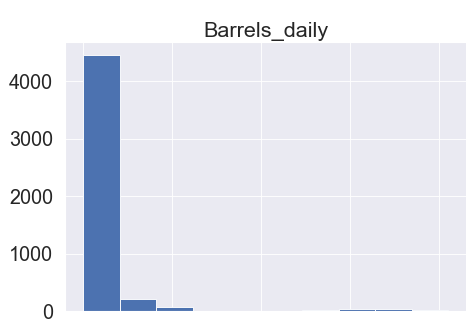

[[<AxesSubplot:title={'center':'Barrels_daily'}>]]


In [324]:
brief_summary(pivot_table2)

In [326]:
top_10_oil_consumption = pivot_table2.nlargest(10, ['Barrels_daily'])
top_10_oil_consumption

Barrels_daily
Country Year               
US      2005   20531.481595
        2004   20498.324486
        2006   20312.849742
        2007   20208.143205
        2003   19848.281507
        2002   19625.009175
        2000   19593.518973
        2001   19534.487359
        2019   19475.375148
        2018   19446.748247

Woah, U.S. had the highest

In [327]:
top_50_oil_consumption = pivot_table2.nlargest(50, ['Barrels_daily'])
top_50_oil_consumption

Barrels_daily
Country       Year               
US            2005   20531.481595
              2004   20498.324486
              2006   20312.849742
              2007   20208.143205
              2003   19848.281507
              2002   19625.009175
              2000   19593.518973
              2001   19534.487359
              2019   19475.375148
              2018   19446.748247
              1999   19425.229658
              2017   18877.537534
              2008   18848.284842
              1978   18846.622000
              1998   18826.629890
              2016   18622.304626
              1997   18538.389274
              2015   18524.405841
              1979   18512.540000
              1977   18431.419000
              2010   18321.794367
              1996   18244.396623
              2014   18131.069496
              2009   18030.470370
              2013   18011.234748
              2011   17996.649973
              1995   17634.400082
              1994   17634.079918
              2012   17585.859027
              1976   17461.066000
              1989   17325.152329
              1973   17307.679000
              1988   17283.313005
              2020   17177.647623
              1993   17161.651329
              1980   17055.861000
              1992   16968.781199
              1990   16939.725523
Total Europe  1979   16910.369829
              2006   16765.463473
              2005   16742.374472
US            1987   16665.050014
              1991   16657.325121
              1974   16652.710000
Total Europe  1998   16636.163225
              1990   16600.232715
              2004   16589.038582
              1978   16522.687246
              2003   16476.058791
              2007   16472.014179

## Oil Production

In [328]:
ds_oil_production = pd.read_excel(xls, 'Oil Production - Barrels', header=[2])
ds_oil_production.head()

Thousand barrels daily       1965       1966       1967       1968  \
0                    NaN        NaN        NaN        NaN        NaN   
1                 Canada    920.000   1012.000   1106.000   1194.000   
2                 Mexico    362.000    370.000    411.000    439.000   
3                     US   9014.148   9579.241  10219.252  10599.743   
4    Total North America  10296.148  10961.241  11736.252  12232.743   

        1969       1970       1971       1972       1973  ...          2016  \
0        NaN        NaN        NaN        NaN        NaN  ...           NaN   
1   1306.000   1473.000   1582.000   1829.000   2114.000  ...   4463.638847   
2    461.000    487.000    486.000    506.000    525.000  ...   2455.799498   
3  10827.674  11296.849  11155.778  11184.896  10945.953  ...  12360.764169   
4  12594.674  13256.849  13223.778  13519.896  13584.953  ...  19280.202514   

           2017          2018          2019          2020    2020.1   2009-19  \
0           NaN           NaN           NaN           NaN       NaN       NaN   
1   4813.033351   5243.879959   5372.417032   5135.483143 -0.044102  0.053100   
2   2224.150160   2068.371143   1918.142825   1909.906457 -0.004294 -0.043052   
3  13154.380658  15333.564712  17072.362726  16475.717273 -0.034948  0.089170   
4  20191.564169  22645.815814  24362.922583  23521.106873 -0.034553  0.061227   

     2020.2  Unnamed: 60  Unnamed: 61  
0       NaN          NaN          NaN  
1  0.058100          NaN          NaN  
2  0.021607          NaN          NaN  
3  0.186396          NaN          NaN  
4  0.266103          NaN          NaN  

[5 rows x 62 columns]

In [329]:
ds_oil_production = ds_oil_production.drop(0)

In [330]:
ds_oil_production.rename({'Thousand barrels daily':'Country'}, axis=1, inplace=True)

In [331]:
ds_oil_production = ds_oil_production.drop(columns='Unnamed: 60')
ds_oil_production = ds_oil_production.drop(columns='Unnamed: 61')
ds_oil_production = ds_oil_production.drop(columns='2020.1')
ds_oil_production = ds_oil_production.drop(columns='2009-19')
ds_oil_production = ds_oil_production.drop(columns='2020.2')

In [332]:
indexed = ds_oil_production[((ds_oil_production.Country == 'Total World'))].index
indexed

Int64Index([71], dtype='int64')

In [333]:
ds_oil_production = ds_oil_production.iloc[0:71]

### Total World Oil Production

In [334]:
afr = ds_oil_production[((ds_oil_production.Country == 'Total Africa'))]
asi = ds_oil_production[((ds_oil_production.Country == 'Total Asia Pacific'))]
mid = ds_oil_production[((ds_oil_production.Country == 'Total Middle East'))]
eur = ds_oil_production[((ds_oil_production.Country == 'Total Europe'))]
cis = ds_oil_production[((ds_oil_production.Country == 'Total CIS'))]
namer = ds_oil_production[((ds_oil_production.Country == 'Total North America'))]
scamer = ds_oil_production[((ds_oil_production.Country == 'Total S. & Cent. America'))]

In [335]:
asi_af = afr.append(asi, ignore_index=True)
mid_eur = mid.append(eur, ignore_index=True)
first4 = asi_af.append(mid_eur, ignore_index=True)

In [336]:
cis_namer = cis.append(namer, ignore_index=True)
last3 = scamer.append(cis_namer, ignore_index=True)

In [337]:
total_oil_production = last3.append(first4, ignore_index=True)
total_oil_production

Country          1965          1966          1967  \
0  Total S. & Cent. America   4333.858493   4291.325205   4570.895479   
1                 Total CIS   4857.760000   5302.000000   5762.000000   
2       Total North America  10296.148000  10961.241000  11736.252000   
3              Total Africa   2232.302521   2842.279918   3133.462822   
4        Total Asia Pacific    898.587836   1002.149616   1062.737288   
5         Total Middle East   8387.496164   9363.561096  10014.077534   
6              Total Europe    785.753973    798.372581    824.236230   

           1968          1969          1970          1971          1972  \
0   4681.779781   4702.386712   4829.065003   4722.649933   4494.140389   
1   6167.103825   6566.000000   7126.746301   7610.459178   8064.128415   
2  12232.743000  12594.674000  13256.849000  13223.778000  13519.896000   
3   4006.778033   5087.143945   6113.290986   5694.157068   5712.108607   
4   1239.768825   1431.710658   1979.495096   2387.084247   2803.637896   
5  11256.469399  12419.958904  13921.897466  16306.022726  18088.887268   
6    833.655995    846.787236    847.439685    841.093340    871.066607   

           1973  ...          2011          2012          2013          2014  \
0   4791.952505  ...   7449.985650   7361.997143   7396.578209   7662.439076   
1   8664.421918  ...  13496.242895  13549.390510  13785.944696  13857.425835   
2  13584.953000  ...  14338.477035  15580.069199  16975.084696  18858.695124   
3   6000.221315  ...   8520.246497   9270.235615   8607.371811   8212.857473   
4   3356.158055  ...   8317.624979   8407.050845   8280.852273   8294.865221   
5  21273.922233  ...  28006.654470  28486.623042  28198.855933  28498.075176   
6    880.169375  ...   3912.765233   3599.623205   3425.561295   3449.882436   

           2015          2016          2017          2018          2019  \
0   7758.068400   7354.532773   7160.456454   6481.159744   6205.685471   
1  13998.236479  14198.786049  14373.519103  14623.513257  14727.010532   
2  19763.432439  19280.202514  20191.564169  22645.815814  24362.922583   
3   8118.386425   7672.056611   8133.830762   8287.684889   8451.765851   
4   8377.318759   8041.340723   7770.756187   7610.387158   7628.172634   
5  30020.666815  31818.327477  31358.823015  31664.760739  30161.761383   
6   3595.660472   3623.379783   3579.471693   3538.419139   3423.565595   

           2020  
0   5840.876874  
1  13495.824334  
2  23521.106873  
3   6864.636023  
4   7425.147010  
5  27664.199056  
6   3579.312274  

[7 rows x 57 columns]

In [338]:
# Total world oil production
total_world_subset_production = ds_oil_production[((ds_oil_production.Country == 'Total World'))]
total_world_subset_production_melt = total_world_subset_production.melt(id_vars=['Country'], var_name='Year', value_name='Barrels_daily')
total_world_subset_prod_pivoted = total_world_subset_production_melt.pivot_table(index=['Country', 'Year'])
total_world_subset_prod_pivoted.dropna()

Barrels_daily
Country     Year               
Total World 1965   31791.906986
            1966   34560.929416
            1967   37103.661353
            1968   40418.298858
            1969   43648.661455
            1970   48074.783538
            1971   50785.244492
            1972   53553.865181
            1973   58551.798401
            1974   58671.083208
            1975   55810.762122
            1976   60440.187744
            1977   62740.326862
            1978   63322.354065
            1979   66067.416017
            1980   62942.090023
            1981   59527.064201
            1982   57270.879336
            1983   56591.867336
            1984   57640.156616
            1985   57344.651073
            1986   60175.812863
            1987   60406.334443
            1988   62840.499299
            1989   63791.559931
            1990   65021.882771
            1991   64865.485032
            1992   65703.967849
            1993   65892.139448
            1994   66876.924334
            1995   67840.996869
            1996   69478.078351
            1997   71252.610090
            1998   73017.354584
            1999   71518.256006
            2000   74543.009030
            2001   74783.938965
            2002   73999.419486
            2003   77160.417174
            2004   80836.963936
            2005   81812.678431
            2006   82560.721210
            2007   82437.622089
            2008   83115.326878
            2009   81491.327630
            2010   83293.130487
            2011   84041.996759
            2012   86254.989560
            2013   86670.248914
            2014   88834.240342
            2015   91631.769789
            2016   91988.625930
            2017   92568.421382
            2018   94851.740741
            2019   94960.884050
            2020   88391.102445

<IPython.core.display.Javascript object>


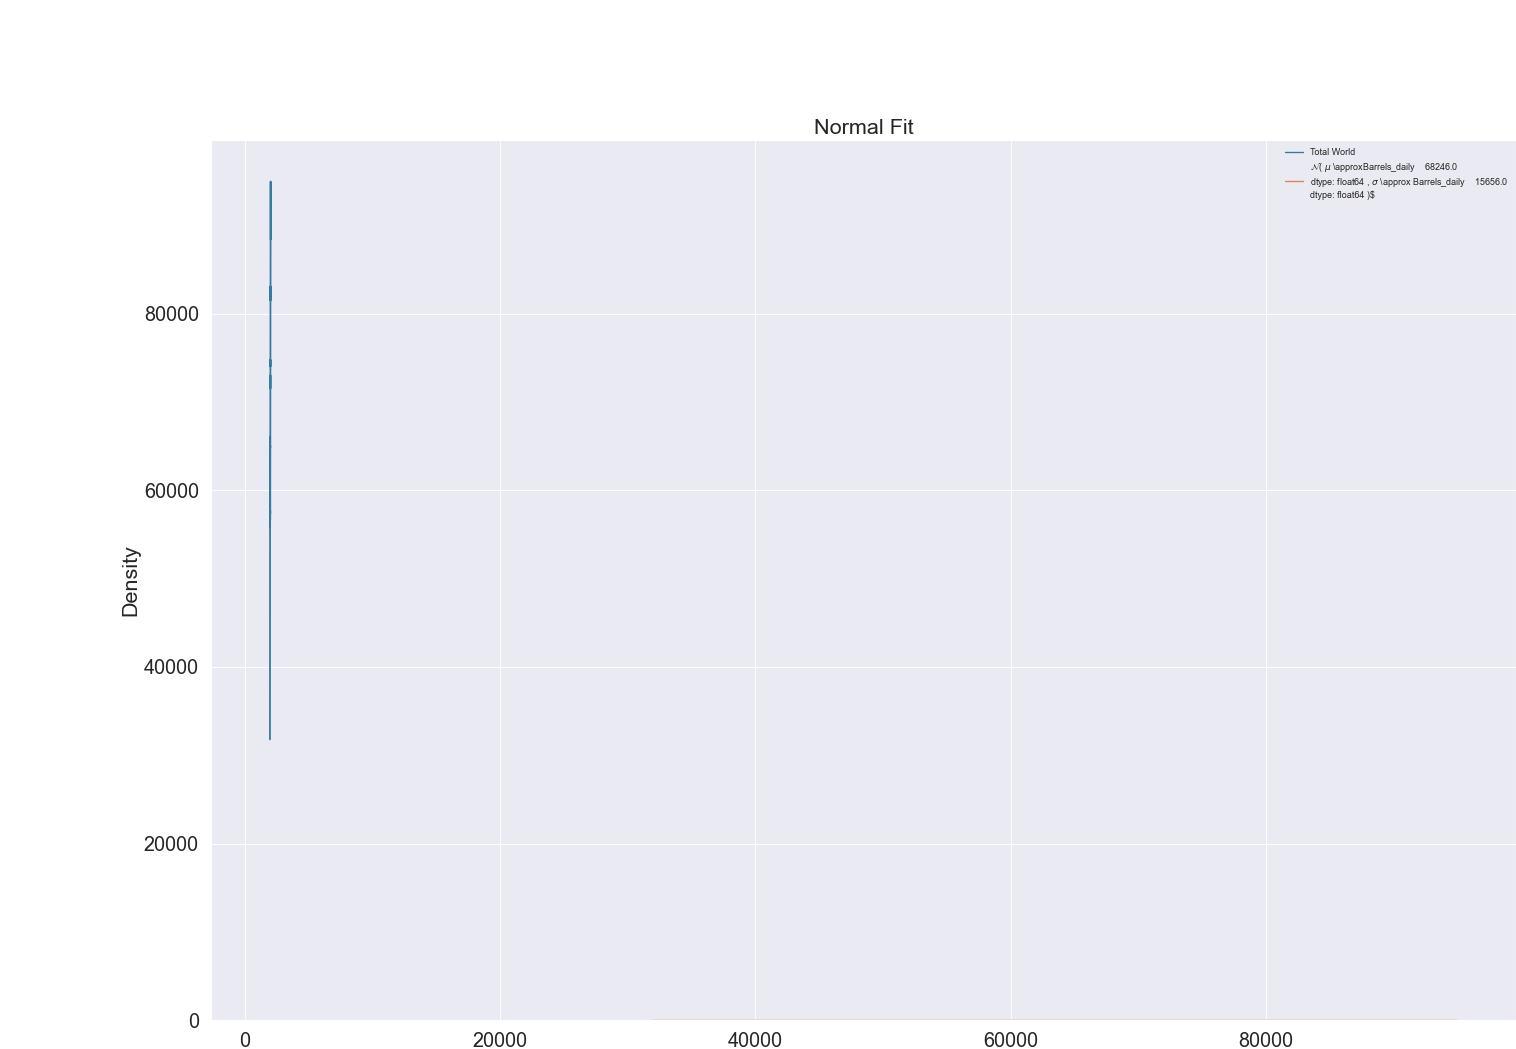

In [339]:
# plot
plt.figure(figsize=(26,18))
sns.set(font_scale = 2)
sns.lineplot(data=total_world_subset_prod_pivoted.reset_index(), x='Year', y='Barrels_daily', hue='Country', palette='mako', linewidth= 2.0)
plt.ylabel('Oil Production by Region (barrels/day)')
plt.title('Total World Oil Production (barrels/day)')
plt.show()

In [340]:
# Sample std and mu
sigma = np.std(total_world_subset_prod_pivoted, ddof=1)
mu = np.mean(total_world_subset_prod_pivoted)

# Plot
x_ = np.linspace(np.min(total_world_subset_prod_pivoted), np.max(total_world_subset_prod_pivoted))
plt.plot(x_, norm.pdf(x_, mu, sigma),
        label= '$\mathcal{N} ' + f'$( $\mu$ \\approx{round(mu)} , $\sigma$ \\approx {round(sigma)} )$')
plt.hist(total_world_subset_prod_pivoted, edgecolor='black', alpha=0.5, density=True)
plt.title("Normal Fit")
plt.xlabel("value")
plt.ylabel("Density")
plt.legend(loc=1, prop={'size': 10})
plt.show()

In [341]:
total_world_oil_production_melt = total_oil_production.melt(id_vars=['Country'], var_name='Year', value_name='Barrels_daily')
total_world_oil_production_melt

Country  Year  Barrels_daily
0    Total S. & Cent. America  1965    4333.858493
1                   Total CIS  1965    4857.760000
2         Total North America  1965   10296.148000
3                Total Africa  1965    2232.302521
4          Total Asia Pacific  1965     898.587836
..                        ...   ...            ...
387       Total North America  2020   23521.106873
388              Total Africa  2020    6864.636023
389        Total Asia Pacific  2020    7425.147010
390         Total Middle East  2020   27664.199056
391              Total Europe  2020    3579.312274

[392 rows x 3 columns]

In [342]:
total_world_oilproduction_pivot_table = total_world_oil_production_melt.pivot_table(index=['Country', 'Year'])
total_world_oilproduction_pivot_table.head()

Barrels_daily
Country      Year               
Total Africa 1965    2232.302521
             1966    2842.279918
             1967    3133.462822
             1968    4006.778033
             1969    5087.143945

In [343]:
total_world_oilproduction_pivot_table.dropna()

Barrels_daily
Country                  Year               
Total Africa             1965    2232.302521
                         1966    2842.279918
                         1967    3133.462822
                         1968    4006.778033
                         1969    5087.143945
...                                      ...
Total S. & Cent. America 2016    7354.532773
                         2017    7160.456454
                         2018    6481.159744
                         2019    6205.685471
                         2020    5840.876874

[392 rows x 1 columns]

<IPython.core.display.Javascript object>


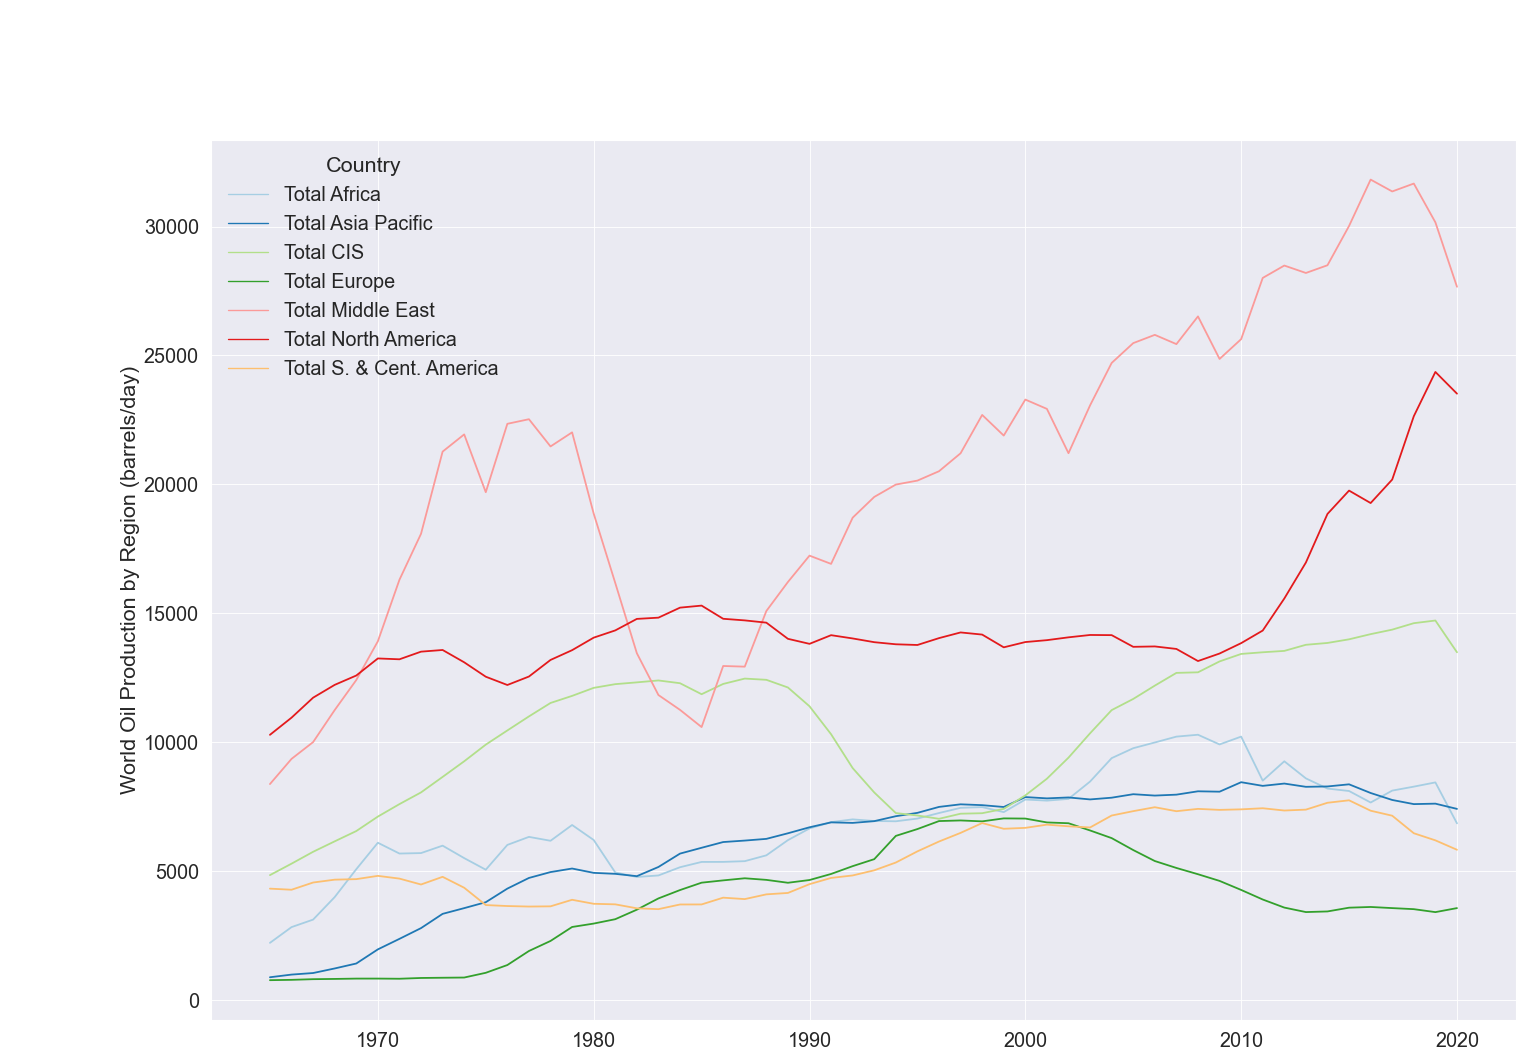

In [344]:
plt.figure(figsize=(26,18))
sns.set(font_scale = 2)
sns.lineplot(data=total_world_oilproduction_pivot_table.reset_index(), x='Year', y='Barrels_daily', hue='Country', palette='Paired', linewidth= 2.0)
plt.ylabel('World Oil Production by Region (barrels/day)')
plt.show()

### Oil Production by Country

In [345]:
tot_south = ds_oil_production[((ds_oil_production.Country == 'Total S. & Cent. America'))].index
tot_north = ds_oil_production[((ds_oil_production.Country == 'Total North America'))].index
tot_cis = ds_oil_production[((ds_oil_production.Country == 'Total CIS'))].index
tot_mid = ds_oil_production[((ds_oil_production.Country == 'Total Middle East'))].index
tot_afr = ds_oil_production[((ds_oil_production.Country == 'Total Africa'))].index
tot_asi = ds_oil_production[((ds_oil_production.Country == 'Total Asia Pacific'))].index
tot_eur = ds_oil_production[((ds_oil_production.Country == 'Total Europe'))].index
tot_world = ds_oil_production[((ds_oil_production.Country == 'Total World'))].index

country_oil_production = ds_oil_production.drop(tot_south)
country_oil_production = country_oil_production.drop(tot_north)
country_oil_production = country_oil_production.drop(tot_cis)
country_oil_production = country_oil_production.drop(tot_mid)
country_oil_production = country_oil_production.drop(tot_afr)
country_oil_production = country_oil_production.drop(tot_asi)
country_oil_production = country_oil_production.drop(tot_eur)
country_oil_production = country_oil_production.drop(tot_world)

In [346]:
country_oil_production

Country         1965         1966          1967          1968  \
1               Canada   920.000000  1012.000000   1106.000000   1194.000000   
2               Mexico   362.000000   370.000000    411.000000    439.000000   
3                   US  9014.148000  9579.241000  10219.252000  10599.743000   
5                  NaN          NaN          NaN           NaN           NaN   
6            Argentina   275.673973   292.864110    318.631233    348.158470   
..                 ...          ...          ...           ...           ...   
65            Malaysia     1.000000     1.000000      1.000000      4.000000   
66            Thailand          NaN          NaN           NaN           NaN   
67             Vietnam          NaN          NaN           NaN           NaN   
68  Other Asia Pacific    35.113973    34.085479     31.085479     35.113661   
70                 NaN          NaN          NaN           NaN           NaN   

            1969          1970          1971          1972          1973  ...  \
1    1306.000000   1473.000000   1582.000000   1829.000000   2114.000000  ...   
2     461.000000    487.000000    486.000000    506.000000    525.000000  ...   
3   10827.674000  11296.849000  11155.778000  11184.896000  10945.953000  ...   
5            NaN           NaN           NaN           NaN           NaN  ...   
6     361.532055    399.464658    431.538082    444.115847    433.635616  ...   
..           ...           ...           ...           ...           ...  ...   
65      9.000000     18.000000     69.000000     93.000000     91.000000  ...   
66           NaN           NaN           NaN           NaN           NaN  ...   
67           NaN           NaN           NaN           NaN           NaN  ...   
68     36.427397     39.505315     42.417534     44.299672     47.056027  ...   
70           NaN           NaN           NaN           NaN           NaN  ...   

           2011         2012          2013          2014          2015  \
1   3514.822066  3740.237677   4000.410965   4270.529903   4388.135578   
2   2940.313380  2911.097981   2874.752731   2784.200879   2586.540847   
3   7883.341589  8928.733541  10099.921000  11803.964342  12788.756014   
5           NaN          NaN           NaN           NaN           NaN   
6    667.236399   656.656085    644.372528    637.593411    646.360166   
..          ...          ...           ...           ...           ...   
65   659.344157   662.626225    627.016169    648.824388    696.323797   
66   429.005587   470.764136    465.578216    463.896176    480.666103   
67   315.765753   346.717568    346.468685    325.046027    351.565479   
68   302.316626   291.335352    274.443853    296.438157    297.792821   
70          NaN          NaN           NaN           NaN           NaN   

            2016          2017          2018          2019          2020  
1    4463.638847   4813.033351   5243.879959   5372.417032   5135.483143  
2    2455.799498   2224.150160   2068.371143   1918.142825   1909.906457  
3   12360.764169  13154.380658  15333.564712  17072.362726  16475.717273  
5            NaN           NaN           NaN           NaN           NaN  
6     609.630946    590.062751    591.322184    620.423017    600.426895  
..           ...           ...           ...           ...           ...  
65    726.090513    718.087058    717.670435    662.670750    595.787900  
66    488.543764    486.339154    471.762906    470.679153    417.603754  
67    317.360929    284.371644    256.668219    236.444932    207.073128  
68    280.651929    273.032873    233.591848    230.990108    210.252537  
70           NaN           NaN           NaN           NaN           NaN  

[63 rows x 57 columns]

In [347]:
ds_oil_production_melt = country_oil_production.melt(id_vars=['Country'], var_name='Year', value_name='Barrels_daily')
ds_oil_production_melt

Country  Year  Barrels_daily
0                 Canada  1965     920.000000
1                 Mexico  1965     362.000000
2                     US  1965    9014.148000
3                    NaN  1965            NaN
4              Argentina  1965     275.673973
...                  ...   ...            ...
3523            Malaysia  2020     595.787900
3524            Thailand  2020     417.603754
3525             Vietnam  2020     207.073128
3526  Other Asia Pacific  2020     210.252537
3527                 NaN  2020            NaN

[3528 rows x 3 columns]

In [348]:
pivot_oil_prod = ds_oil_production_melt.pivot_table(index=['Country', 'Year'])
pivot_oil_prod.head()

Barrels_daily
Country Year               
Algeria 1965     569.943836
        1966     733.593151
        1967     842.664384
        1968     922.495082
        1969     969.331507

In [349]:
pivot_oil_prod.dropna()

Barrels_daily
Country Year               
Algeria 1965     569.943836
        1966     733.593151
        1967     842.664384
        1968     922.495082
        1969     969.331507
...                     ...
Yemen   2016      42.576511
        2017      71.013699
        2018      94.156115
        2019      94.649315
        2020      94.573770

[2784 rows x 1 columns]

              Barrels_daily
Country Year               
Algeria 1965     569.943836
        1966     733.593151
        1967     842.664384
        1968     922.495082
        1969     969.331507
Barrels_daily    0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2784 entries, ('Algeria', 1965) to ('Yemen', 2020)
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Barrels_daily  2784 non-null   float64
dtypes: float64(1)
memory usage: 28.2+ KB
None
       Barrels_daily
count    2784.000000
mean     1372.761661
std      2302.851430
min         0.000000
25%       150.000000
50%       456.899820
75%      1661.157247
max     17072.362726


<IPython.core.display.Javascript object>


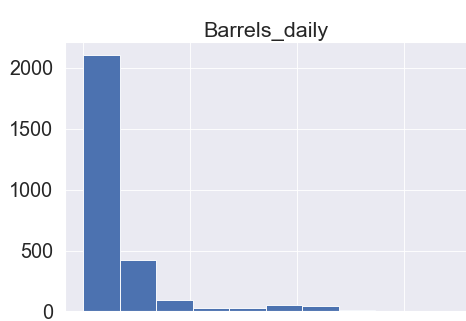

[[<AxesSubplot:title={'center':'Barrels_daily'}>]]


In [350]:
brief_summary(pivot_oil_prod)

In [351]:
top_10_oil_production = pivot_oil_prod.nlargest(10, ['Barrels_daily'])
top_10_oil_production

Barrels_daily
Country      Year               
US           2019   17072.362726
             2020   16475.717273
             2018   15333.564712
             2017   13154.380658
             2015   12788.756014
Saudi Arabia 2016   12406.047608
USSR         1983   12403.434247
US           2016   12360.764169
USSR         1982   12329.785479
             1984   12296.677049

In [352]:
top_50_oil_production = pivot_oil_prod.nlargest(50, ['Barrels_daily'])
top_50_oil_production

Barrels_daily
Country            Year               
US                 2019   17072.362726
                   2020   16475.717273
                   2018   15333.564712
                   2017   13154.380658
                   2015   12788.756014
Saudi Arabia       2016   12406.047608
USSR               1983   12403.434247
US                 2016   12360.764169
USSR               1982   12329.785479
                   1984   12296.677049
Saudi Arabia       2018   12261.333342
USSR               1981   12260.252877
                   1980   12116.414481
Saudi Arabia       2015   11997.937984
                   2017   11892.198262
                   2019   11832.319243
USSR               1979   11805.424658
US                 2014   11803.964342
Russian Federation 2019   11679.000289
Saudi Arabia       2012   11621.794283
Russian Federation 2018   11562.426127
USSR               1978   11530.754247
Saudi Arabia       2014   11518.822724
Russian Federation 1987   11416.333425
Saudi Arabia       2013   11392.926635
Russian Federation 2017   11373.675921
                   1988   11372.755355
                   2016   11342.060918
US                 1970   11296.849000
Russian Federation 1986   11246.881644
US                 1972   11184.896000
                   1971   11155.778000
Russian Federation 2015   11086.796306
Saudi Arabia       2011   11079.228786
Russian Federation 1989   11070.064110
Saudi Arabia       2020   11038.951334
USSR               1977   11009.914247
US                 1973   10945.953000
Russian Federation 2014   10927.102235
                   1985   10862.591671
Saudi Arabia       2005   10838.581395
US                 1969   10827.674000
Russian Federation 2013   10806.839890
Saudi Arabia       2006   10670.781699
Russian Federation 2020   10666.571958
Saudi Arabia       2008   10664.794412
Russian Federation 2012   10655.733492
US                 1968   10599.743000
                   1985   10580.378000
Russian Federation 2011   10533.363503

## Oil Proved Reserves

Again, this data comes from the [Statistical Review of World Energy](https://www.bp.com/en/global/corporate/energy-economics/statistical-review-of-world-energy/downloads.html) by BP. Note:
Source - The estimates in this table have been compiled using a combination of primary official sources, third-party data from the OPEC Secretariat, World Oil, Oil & Gas Journal and Chinese reserves based on official data and information in the public domain. Canadian oil sands 'under active development' are an official estimate. Venezuelan Orinoco Belt reserves are based on the OPEC Secretariat and government announcements. Reserves and R/P ratio for Canada includes Canadian oil sands. Reserves and R/P ratio for Venezuela includes the Orinoco Belt.  Saudi Arabia's oil reserves include NGLs from 2017.

**Total proved reserves of oil - Generally taken to be those quantities that geological and engineering information indicates with reasonable certainty can be recovered in the future from known reservoirs under existing economic and operating conditions. The data series for total proved oil reserves does not necessarily meet the definitions, guidelines and practices used for determining proved reserves at company level, for instance as published by the US Securities and Exchange Commission, Reserves-to-production (R/P) ratio - If the reserves remaining at the end of any year are divided by the production in that year, the result is the length of time that those remaining reserves would last if production were to continue at that rate.**
- Reserves include gas condensate and natural gas liquids (NGLs) as well as crude oil. 
- Shares of total and R/P ratios are calculated using thousand million barrels figures.

More information was found in the [Youtube](https://www.youtube.com/watch?v=dw1fiXc6Qs0) video. According to Matt Simmons, a renowned oil technology expert and former CEO of Simmons & Co, "there is zero transparency in the top 100 to 200 oil fields in the world - or how much they are producing." Approximately 4,000 oil fields are currently in production; but half of the global oil production relies only on 120 giant fields. These giant fields are unfortunately not distributed evenly across the globe. All giant oil fields were tapped almost 40,000 years ago and their production is waning year after year. 

Southeast Asia may become the next hotspot for oil production, still most reserves have been discovered along the Persian Gulf. However, the triangle-shape of oil reserves that exists in the Persian Gulf yields very few reef structures. Predicting where hydrocarbons exist has been a tough feat; only 10%^ of oil exploration drill holes have been successful. And from discovery to the delivery of first drops, it takes approximately **ten years**. 

Depleting the reservoirs also presents problems. By depleting, the internal ambient pressure decreases significantly that the oil stops coming out of the whole by itself. So in order to increase the pressure, engineers drill on the edge of the reservoirs and dump water; the water will push the oil and increase the pressure. The proportion of water to oil matters; if the ratio is above 98%, the production is no longer profitable. **The increasing water to oil ratio is an indicator for a depleting oil field.**

In [353]:
oil_reserves = pd.read_excel(xls, 'Oil - Proved reserves', header=[4])
oil_reserves.head()

Unnamed: 0     barrels   barrels.1  barrels.2   barrels.3  \
0                  NaN         NaN         NaN        NaN         NaN   
1               Canada  181.503697  174.848021  169.12491  168.087611   
2               Mexico   24.631280   10.419600    6.06588    6.065880   
3                   US   30.390000   34.990000   68.75700   68.757000   
4  Total North America  236.524977  220.257621  243.94779  242.910491   

      tonnes  of total      ratio  Unnamed: 8  Unnamed: 9  ...  Unnamed: 16  \
0        NaN       NaN        NaN         NaN         NaN  ...          NaN   
1  27.059977  0.097028  89.427957         NaN         NaN  ...          NaN   
2   0.864085  0.003501    8.67762         NaN         NaN  ...          NaN   
3   8.202768  0.039690  11.402275         NaN         NaN  ...          NaN   
4  36.126830  0.140219  28.216779         NaN         NaN  ...          NaN   

   Unnamed: 17  Unnamed: 18  Unnamed: 19  Unnamed: 20  Unnamed: 21  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   Unnamed: 22  Unnamed: 23  Unnamed: 24  Unnamed: 25  
0          NaN          NaN          NaN          NaN  
1          NaN          NaN          NaN          NaN  
2          NaN          NaN          NaN          NaN  
3          NaN          NaN          NaN          NaN  
4          NaN          NaN          NaN          NaN  

[5 rows x 26 columns]

In [354]:
oil_reserves = oil_reserves.drop(0)

In [355]:
oil_reserves.rename({'Unnamed: 0':'Country'}, axis=1, inplace=True)

In [356]:
ind = oil_reserves[((oil_reserves.Country == 'Total World'))].index
ind

Int64Index([70], dtype='int64')

In [357]:
oil_reserves = oil_reserves.iloc[0:69]

In [358]:
oil_reserves.columns

Index(['Country', 'barrels', 'barrels.1', 'barrels.2', 'barrels.3', 'tonnes',
       'of total', 'ratio', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10',
       'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14',
       'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22',
       'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25'],
      dtype='object')

In [359]:
oil_reserves = oil_reserves[['Country', 'barrels', 'barrels.1', 'barrels.2', 'barrels.3', 'tonnes', 'of total', 'ratio']]

In [360]:
oil_reserves.rename({'barrels':'Thousand million barrels at end year 2000'}, axis=1, inplace=True)
oil_reserves.rename({'barrels.1':'Thousand million barrels at end year 2010'}, axis=1, inplace=True)
oil_reserves.rename({'barrels.2':'Thousand million barrels at end year 2019'}, axis=1, inplace=True)
oil_reserves.rename({'barrels.3':'Thousand million barrels at end year 2020'}, axis=1, inplace=True)
oil_reserves.rename({'tonnes':'Thousand million tonnes at end year 2020'}, axis=1, inplace=True)
oil_reserves.rename({'of total':'Share of total'}, axis=1, inplace=True)
oil_reserves.rename({'ratio':'R/P ratio'}, axis=1, inplace=True)
oil_reserves.head()

Country  Thousand million barrels at end year 2000  \
1               Canada                                 181.503697   
2               Mexico                                  24.631280   
3                   US                                  30.390000   
4  Total North America                                 236.524977   
5                  NaN                                        NaN   

   Thousand million barrels at end year 2010  \
1                                 174.848021   
2                                  10.419600   
3                                  34.990000   
4                                 220.257621   
5                                        NaN   

   Thousand million barrels at end year 2019  \
1                                  169.12491   
2                                    6.06588   
3                                   68.75700   
4                                  243.94779   
5                                        NaN   

   Thousand million barrels at end year 2020  \
1                                 168.087611   
2                                   6.065880   
3                                  68.757000   
4                                 242.910491   
5                                        NaN   

   Thousand million tonnes at end year 2020  Share of total  R/P ratio  
1                                 27.059977        0.097028  89.427957  
2                                  0.864085        0.003501    8.67762  
3                                  8.202768        0.039690  11.402275  
4                                 36.126830        0.140219  28.216779  
5                                       NaN             NaN        NaN

In [361]:
oil_reserves_barells = oil_reserves[['Country','Thousand million barrels at end year 2000','Thousand million barrels at end year 2010','Thousand million barrels at end year 2019', 'Thousand million barrels at end year 2020']]

### Oil Reserves by country

In [362]:
tot_south = oil_reserves_barells[((oil_reserves_barells.Country == 'Total S. & Cent. America'))].index
tot_north = oil_reserves_barells[((oil_reserves_barells.Country == 'Total North America'))].index
tot_cis = oil_reserves_barells[((oil_reserves_barells.Country == 'Total CIS'))].index
tot_mid = oil_reserves_barells[((oil_reserves_barells.Country == 'Total Middle East'))].index
tot_afr = oil_reserves_barells[((oil_reserves_barells.Country == 'Total Africa'))].index
tot_asi = oil_reserves_barells[((oil_reserves_barells.Country == 'Total Asia Pacific'))].index
tot_eur = oil_reserves_barells[((oil_reserves_barells.Country == 'Total Europe'))].index
tot_world = oil_reserves_barells[((oil_reserves_barells.Country == 'Total World'))].index

country_oil_reserves_barells = oil_reserves_barells.drop(tot_south)
country_oil_reserves_barells = country_oil_reserves_barells.drop(tot_north)
country_oil_reserves_barells = country_oil_reserves_barells.drop(tot_cis)
country_oil_reserves_barells = country_oil_reserves_barells.drop(tot_mid)
country_oil_reserves_barells = country_oil_reserves_barells.drop(tot_afr)
country_oil_reserves_barells = country_oil_reserves_barells.drop(tot_asi)
country_oil_reserves_barells = country_oil_reserves_barells.drop(tot_eur)
country_oil_reserves_barells = country_oil_reserves_barells.drop(tot_world)

In [363]:
country_oil_reserves_barells = country_oil_reserves_barells.dropna()
country_oil_reserves_barells

Country  Thousand million barrels at end year 2000  \
1                     Canada                                 181.503697   
2                     Mexico                                  24.631280   
3                         US                                  30.390000   
6                  Argentina                                   2.973703   
7                     Brazil                                   8.464488   
8                   Colombia                                   1.971900   
9                    Ecuador                                   2.668168   
10                      Peru                                   0.905620   
11         Trinidad & Tobago                                   0.851070   
12                 Venezuela                                  76.848000   
13  Other S. & Cent. America                                   1.327408   
16                   Denmark                                   1.113297   
17                     Italy                                   0.597951   
18                    Norway                                  11.366245   
19                   Romania                                   1.169900   
20            United Kingdom                                   4.725000   
21              Other Europe                                   2.071190   
22             Total Europe                                   21.043583   
24                Azerbaijan                                   1.178000   
25                Kazakhstan                                   5.400000   
26        Russian Federation                                 112.112023   
27              Turkmenistan                                   0.546000   
28                Uzbekistan                                   0.594000   
29                 Other CIS                                   0.250000   
32                      Iran                                  99.530000   
33                      Iraq                                 112.500000   
34                    Kuwait                                  96.500000   
35                      Oman                                   5.848000   
36                     Qatar                                  16.866700   
37              Saudi Arabia                                 262.766000   
38                     Syria                                   2.325000   
39      United Arab Emirates                                  97.800000   
40                     Yemen                                   2.400000   
41         Other Middle East                                   0.152870   
44                   Algeria                                  11.314000   
45                    Angola                                   5.972000   
46                      Chad                                   0.900000   
47        Republic of Congo                                    1.505913   
48                     Egypt                                   3.626900   
49         Equatorial Guinea                                   0.800000   
50                     Gabon                                   2.420000   
51                     Libya                                  36.000000   
52                   Nigeria                                  29.000000   
54                     Sudan                                   0.262100   
55                   Tunisia                                   0.425200   
56              Other Africa                                   0.678320   
59                 Australia                                   4.943791   
60                    Brunei                                   1.230000   
61                     China                                  15.190300   
62                     India                                   5.289900   
63                 Indonesia                                   5.120000   
64                  Malaysia                                   2.125530   
65                  Thailand                  

In [364]:
country_oil_reserves_indexed = country_oil_reserves_barells.set_index('Country')
country_oil_reserves_indexed

Thousand million barrels at end year 2000  \
Country                                                               
Canada                                                   181.503697   
Mexico                                                    24.631280   
US                                                        30.390000   
Argentina                                                  2.973703   
Brazil                                                     8.464488   
Colombia                                                   1.971900   
Ecuador                                                    2.668168   
Peru                                                       0.905620   
Trinidad & Tobago                                          0.851070   
Venezuela                                                 76.848000   
Other S. & Cent. America                                   1.327408   
Denmark                                                    1.113297   
Italy                                                      0.597951   
Norway                                                    11.366245   
Romania                                                    1.169900   
United Kingdom                                             4.725000   
Other Europe                                               2.071190   
Total Europe                                              21.043583   
Azerbaijan                                                 1.178000   
Kazakhstan                                                 5.400000   
Russian Federation                                       112.112023   
Turkmenistan                                               0.546000   
Uzbekistan                                                 0.594000   
Other CIS                                                  0.250000   
Iran                                                      99.530000   
Iraq                                                     112.500000   
Kuwait                                                    96.500000   
Oman                                                       5.848000   
Qatar                                                     16.866700   
Saudi Arabia                                             262.766000   
Syria                                                      2.325000   
United Arab Emirates                                      97.800000   
Yemen                                                      2.400000   
Other Middle East                                          0.152870   
Algeria                                                   11.314000   
Angola                                                     5.972000   
Chad                                                       0.900000   
Republic of Congo                                          1.505913   
Egypt                                                      3.626900   
Equatorial Guinea                                          0.800000   
Gabon                                                      2.420000   
Libya                                                     36.000000   
Nigeria                                                   29.000000   
Sudan                                                      0.262100   
Tunisia                                                    0.425200   
Other Africa                                               0.678320   
Australia                                                  4.943791   
Brunei                                                     1.230000   
China                                                     15.190300   
India                                                      5.289900   
Indonesia                                                  5.120000   
Malaysia                                                   2.125530   
Thailand                                                   0.515000   
Vietnam                                                    1.950000   
Other Asia Pacific                                

           Thousand million barrels at end year 2000  \
Country                                                
Canada                                    181.503697   
Mexico                                     24.631280   
US                                         30.390000   
Argentina                                   2.973703   
Brazil                                      8.464488   

           Thousand million barrels at end year 2010  \
Country                                                
Canada                                    174.848021   
Mexico                                     10.419600   
US                                         34.990000   
Argentina                                   2.524152   
Brazil                                     14.246330   

           Thousand million barrels at end year 2019  \
Country                                                
Canada                                    169.124910   
Mexico                                      6.

<IPython.core.display.Javascript object>


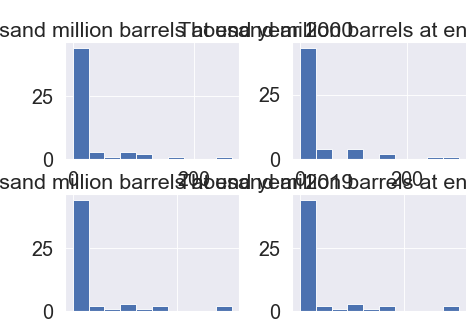

[[<AxesSubplot:title={'center':'Thousand million barrels at end year 2000'}>
  <AxesSubplot:title={'center':'Thousand million barrels at end year 2010'}>]
 [<AxesSubplot:title={'center':'Thousand million barrels at end year 2019'}>
  <AxesSubplot:title={'center':'Thousand million barrels at end year 2020'}>]]


In [365]:
brief_summary(country_oil_reserves_indexed)

### Top 10 countries with number of oil reserves end of year 2000

In [366]:
top_10_countries_no_oil_reserves_2000 = country_oil_reserves_indexed.nlargest(10, ['Thousand million barrels at end year 2000'])
top_10_countries_no_oil_reserves_2000

Thousand million barrels at end year 2000  \
Country                                                           
Saudi Arabia                                         262.766000   
Canada                                               181.503697   
Iraq                                                 112.500000   
Russian Federation                                   112.112023   
Iran                                                  99.530000   
United Arab Emirates                                  97.800000   
Kuwait                                                96.500000   
Venezuela                                             76.848000   
Libya                                                 36.000000   
US                                                    30.390000   

                      Thousand million barrels at end year 2010  \
Country                                                           
Saudi Arabia                                         264.516000   
Canada                                               174.848021   
Iraq                                                 115.000000   
Russian Federation                                   105.800352   
Iran                                                 151.170000   
United Arab Emirates                                  97.800000   
Kuwait                                               101.500000   
Venezuela                                            296.501000   
Libya                                                 47.097000   
US                                                    34.990000   

                      Thousand million barrels at end year 2019  \
Country                                                           
Saudi Arabia                                         297.578000   
Canada                                               169.124910   
Iraq                                                 145.019000   
Russian Federation                                   107.804239   
Iran                                                 157.800000   
United Arab Emirates                                  97.800000   
Kuwait                                               101.500000   
Venezuela                                            303.805745   
Libya                                                 48.363000   
US                                                    68.757000   

                      Thousand million barrels at end year 2020  
Country                                                          
Saudi Arabia                                         297.527000  
Canada                                               168.087611  
Iraq                                                 145.019000  
Russian Federation                                   107.804239  
Iran                                                 157.800000  
United Arab Emirates                                  97.800000  
Kuwait                                               101.500000  
Venezuela                                            303.805745  
Libya                                                 48.363000  
US                                                    68.757000

### Top 10 countries with number of oil reserves end of year 2020

In [367]:
top_10_countries_no_oil_reserves_2020 = country_oil_reserves_indexed.nlargest(10, ['Thousand million barrels at end year 2020'])
top_10_countries_no_oil_reserves_2020

Thousand million barrels at end year 2000  \
Country                                                           
Venezuela                                             76.848000   
Saudi Arabia                                         262.766000   
Canada                                               181.503697   
Iran                                                  99.530000   
Iraq                                                 112.500000   
Russian Federation                                   112.112023   
Kuwait                                                96.500000   
United Arab Emirates                                  97.800000   
US                                                    30.390000   
Libya                                                 36.000000   

                      Thousand million barrels at end year 2010  \
Country                                                           
Venezuela                                            296.501000   
Saudi Arabia                                         264.516000   
Canada                                               174.848021   
Iran                                                 151.170000   
Iraq                                                 115.000000   
Russian Federation                                   105.800352   
Kuwait                                               101.500000   
United Arab Emirates                                  97.800000   
US                                                    34.990000   
Libya                                                 47.097000   

                      Thousand million barrels at end year 2019  \
Country                                                           
Venezuela                                            303.805745   
Saudi Arabia                                         297.578000   
Canada                                               169.124910   
Iran                                                 157.800000   
Iraq                                                 145.019000   
Russian Federation                                   107.804239   
Kuwait                                               101.500000   
United Arab Emirates                                  97.800000   
US                                                    68.757000   
Libya                                                 48.363000   

                      Thousand million barrels at end year 2020  
Country                                                          
Venezuela                                            303.805745  
Saudi Arabia                                         297.527000  
Canada                                               168.087611  
Iran                                                 157.800000  
Iraq                                                 145.019000  
Russian Federation                                   107.804239  
Kuwait                                               101.500000  
United Arab Emirates                                  97.800000  
US                                                    68.757000  
Libya                                                 48.363000

In [368]:
# Max no. oil reserves in 2010
country_oil_reserves_indexed.loc[country_oil_reserves_indexed['Thousand million barrels at end year 2010'].idxmax()]

Thousand million barrels at end year 2000     76.848000
Thousand million barrels at end year 2010    296.501000
Thousand million barrels at end year 2019    303.805745
Thousand million barrels at end year 2020    303.805745
Name: Venezuela, dtype: float64

In [369]:
# Max no. oil reserves in 2019
country_oil_reserves_indexed.loc[country_oil_reserves_indexed['Thousand million barrels at end year 2019'].idxmax()]

Thousand million barrels at end year 2000     76.848000
Thousand million barrels at end year 2010    296.501000
Thousand million barrels at end year 2019    303.805745
Thousand million barrels at end year 2020    303.805745
Name: Venezuela, dtype: float64

## Venezuela

Currently, Venezuela is has the most proved oil reserves. Let's calculate its reserve-to-production ratio (RPR). The equation is:

(Mbbl/y of proven oil reserve)/(Mbbl/y of produced oil) = years of proven oil reserves

In [520]:
# Check Venezuela's oil production in Mbbl/d. We will take the # for 2020.
venez_oil_prod_subset = ds_oil_production[((ds_oil_production.Country == 'Venezuela'))]
venez_oil_prod_subset

Country    1965    1966    1967    1968    1969    1970    1971    1972  \
12  Venezuela  3503.0  3402.0  3576.0  3639.0  3631.0  3754.0  3615.0  3301.0   

      1973  ...         2011         2012         2013         2014      2015  \
12  3455.0  ...  2755.021082  2703.734191  2680.356164  2692.493151  2630.863   

      2016       2017         2018        2019        2020  
12  2347.0  2096.0428  1474.702089  918.260362  539.761389  

[1 rows x 57 columns]

In [521]:
venez_oil_prod_subset.rename({'Country':'Type'}, axis=1, inplace=True)
venez_oil_prod_subset['Type'] = venez_oil_prod_subset['Type'].replace({'Venezuela': 'Production'})
venez_oil_prod_subset

D:\User\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-521-9f2f5b4bdc8c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venez_oil_prod_subset['Type'] = venez_oil_prod_subset['Type'].replace({'Venezuela': 'Production'})


Type    1965    1966    1967    1968    1969    1970    1971  \
12  Production  3503.0  3402.0  3576.0  3639.0  3631.0  3754.0  3615.0   

      1972    1973  ...         2011         2012         2013         2014  \
12  3301.0  3455.0  ...  2755.021082  2703.734191  2680.356164  2692.493151   

        2015    2016       2017         2018        2019        2020  
12  2630.863  2347.0  2096.0428  1474.702089  918.260362  539.761389  

[1 rows x 57 columns]

In [522]:
print("Venezuela's oil production in Mbbl/y for 2020 is: ", 540000 * 365.24)

Venezuela's oil production in Mbbl/y for 2020 is:  197229600.0


In [523]:
# Check Venezuela's oil consumption in Mbbl/d. We will take the # for 2020.
venez_oil_consum_subset = ds_oil_consumption[((ds_oil_consumption.Country == 'Venezuela'))]
venez_oil_consum_subset

Country        1965        1966        1967       1968        1969  \
13  Venezuela  183.879953  181.469395  185.728871  201.42559  200.370616   

          1970        1971        1972       1973  ...        2011  \
13  209.874364  212.341753  230.821601  257.25874  ...  720.639562   

          2012        2013        2014        2015        2016        2017  \
13  784.801612  834.859877  746.403925  696.901659  537.383707  492.826716   

          2018       2019       2020  
13  409.781167  295.88749  241.64205  

[1 rows x 57 columns]

In [524]:
venez_oil_consum_subset.rename({'Country':'Type'}, axis=1, inplace=True)
venez_oil_consum_subset['Type'] = venez_oil_consum_subset['Type'].replace({'Venezuela': 'Consumption'})
venez_oil_consum_subset

D:\User\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-524-21fb3e1152f0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venez_oil_consum_subset['Type'] = venez_oil_consum_subset['Type'].replace({'Venezuela': 'Consumption'})


Type        1965        1966        1967       1968        1969  \
13  Consumption  183.879953  181.469395  185.728871  201.42559  200.370616   

          1970        1971        1972       1973  ...        2011  \
13  209.874364  212.341753  230.821601  257.25874  ...  720.639562   

          2012        2013        2014        2015        2016        2017  \
13  784.801612  834.859877  746.403925  696.901659  537.383707  492.826716   

          2018       2019       2020  
13  409.781167  295.88749  241.64205  

[1 rows x 57 columns]

In [525]:
print("Venezuela's oil consumption in Mbbl/y for 2020 is: ", 242000 * 365.24)

Venezuela's oil consumption in Mbbl/y for 2020 is:  88388080.0


In [526]:
print("Years of proven oil reserves left for Venezuela as of 2020:  ", 303800000000/197229600)

Years of proven oil reserves left for Venezuela as of 2020:   1540.3367445860054


## Alternative calculation of oil reserves: Rate of Emptiness (%)

Reserves-to-production ratio is subject to a lot of outlying factors that cause the resulting ratio to be highly inaccurate. Here, I use a past production-to-reserves ratio. If the ratio is below 50%, it will indicate that the country has increasing volume and increasing prices is possible. 

In [468]:
venezuela_prod_to_consum = venez_oil_consum_subset.append(venez_oil_prod_subset, ignore_index=True)

In [469]:
venezuela_prod_to_consum

Type         1965         1966         1967        1968  \
0  Consumption   183.879953   181.469395   185.728871   201.42559   
1   Production  3503.000000  3402.000000  3576.000000  3639.00000   

          1969         1970         1971         1972        1973  ...  \
0   200.370616   209.874364   212.341753   230.821601   257.25874  ...   
1  3631.000000  3754.000000  3615.000000  3301.000000  3455.00000  ...   

          2011         2012         2013         2014         2015  \
0   720.639562   784.801612   834.859877   746.403925   696.901659   
1  2755.021082  2703.734191  2680.356164  2692.493151  2630.863000   

          2016         2017         2018        2019        2020  
0   537.383707   492.826716   409.781167  295.887490  241.642050  
1  2347.000000  2096.042800  1474.702089  918.260362  539.761389  

[2 rows x 57 columns]

In [470]:
venezuela_prod_to_consum_melt = venezuela_prod_to_consum.melt(id_vars=['Type'], var_name='Year', value_name='thousand_barrels_daily')

In [471]:
venezuela_prod_to_consum_pivot = venezuela_prod_to_consum_melt.pivot_table(index=['Type', 'Year'])

                  thousand_barrels_daily
Type        Year                        
Consumption 1965              183.879953
            1966              181.469395
            1967              185.728871
            1968              201.425590
            1969              200.370616
thousand_barrels_daily    0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 112 entries, ('Consumption', 1965) to ('Production', 2020)
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   thousand_barrels_daily  112 non-null    float64
dtypes: float64(1)
memory usage: 1.7+ KB
None
       thousand_barrels_daily
count              112.000000
mean              1568.156259
std               1226.873186
min                181.469395
25%                434.749667
50%                809.830745
75%               2715.800643
max               3754.000000


<IPython.core.display.Javascript object>


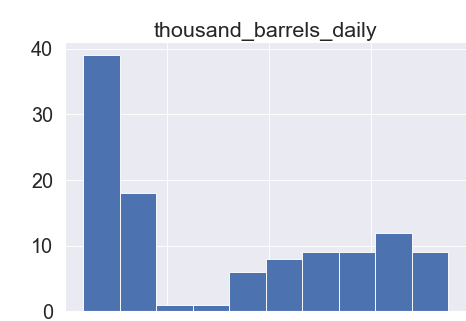

[[<AxesSubplot:title={'center':'thousand_barrels_daily'}>]]


In [472]:
brief_summary(venezuela_prod_to_consum_pivot)

In [474]:
venezuela_prod_melt = venez_oil_prod_subset.melt(id_vars=['Type'], var_name='Year', value_name='thousand_barrels_daily')

In [475]:
import datetime
venezuela_prod_melt['year_datetime'] =  venezuela_prod_melt['Year'].map(lambda x: pd.to_datetime(f'{x}-01-01'))
venezuela_prod_melt = venezuela_prod_melt.drop(columns='Year')

In [496]:
venezuela_prod_melt['converted'] = venezuela_prod_melt['thousand_barrels_daily'] * 365.24
print(venezuela_prod_melt['converted'])

0     1.279436e+06
1     1.242546e+06
2     1.306098e+06
3     1.329108e+06
4     1.326186e+06
5     1.371111e+06
6     1.320343e+06
7     1.205657e+06
8     1.261904e+06
9     1.117634e+06
10    8.846113e+05
11    8.659840e+05
12    8.451654e+05
13    8.133895e+05
14    8.857070e+05
15    8.137547e+05
16    7.900141e+05
17    7.136790e+05
18    6.764245e+05
19    6.767897e+05
20    6.369786e+05
21    6.888426e+05
22    6.976084e+05
23    7.297495e+05
24    7.348629e+05
25    8.195986e+05
26    9.134652e+05
27    9.127348e+05
28    9.467021e+05
29    1.005140e+06
30    1.080745e+06
31    1.145758e+06
32    1.213007e+06
33    1.259095e+06
34    1.130440e+06
35    1.136493e+06
36    1.159429e+06
37    1.086621e+06
38    1.047713e+06
39    1.207447e+06
40    1.206062e+06
41    1.219787e+06
42    1.182308e+06
43    1.179059e+06
44    1.109539e+06
45    1.037856e+06
46    1.006244e+06
47    9.875119e+05
48    9.789733e+05
49    9.834062e+05
50    9.608964e+05
51    8.572183e+05
52    7.6555

In [497]:
all_time_reserve = venezuela_prod_melt['converted'].sum()
print(all_time_reserve)

54823541.20676771


Venezuela has already extracted about 54.8 billion barrels since 1965 to 2020. Venezuela has 303.8 billion barrels remaining as of 2019-2020. Our ratio will be:

In [493]:
54.8/(54.8+303.8)

0.15281650864472948

Venezuela is approximately 15.3% empty.

<IPython.core.display.Javascript object>


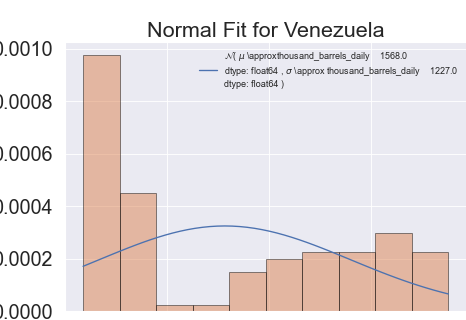

In [382]:
from scipy.stats import norm
from matplotlib import pyplot as plt
%matplotlib notebook

# Sample std and mu
std2 = np.std(venezuela_prod_to_consum_pivot, ddof=1)
mean2 = np.mean(venezuela_prod_to_consum_pivot)

# Plot
x = np.linspace(np.min(venezuela_prod_to_consum_pivot), np.max(venezuela_prod_to_consum_pivot))
plt.plot(x, norm.pdf(x, mean2, std2), 
        label= '$\mathcal{N} ' + f'$( $\mu$ \\approx{round(mean2)} , $\sigma$ \\approx {round(std2)} )')
plt.hist(venezuela_prod_to_consum_pivot, edgecolor='black', alpha=0.5, density=True)
plt.title("Normal Fit for Venezuela")
plt.xlabel("value")
plt.ylabel("Density")
plt.legend(loc=1, prop={'size': 10})
plt.show()

<IPython.core.display.Javascript object>


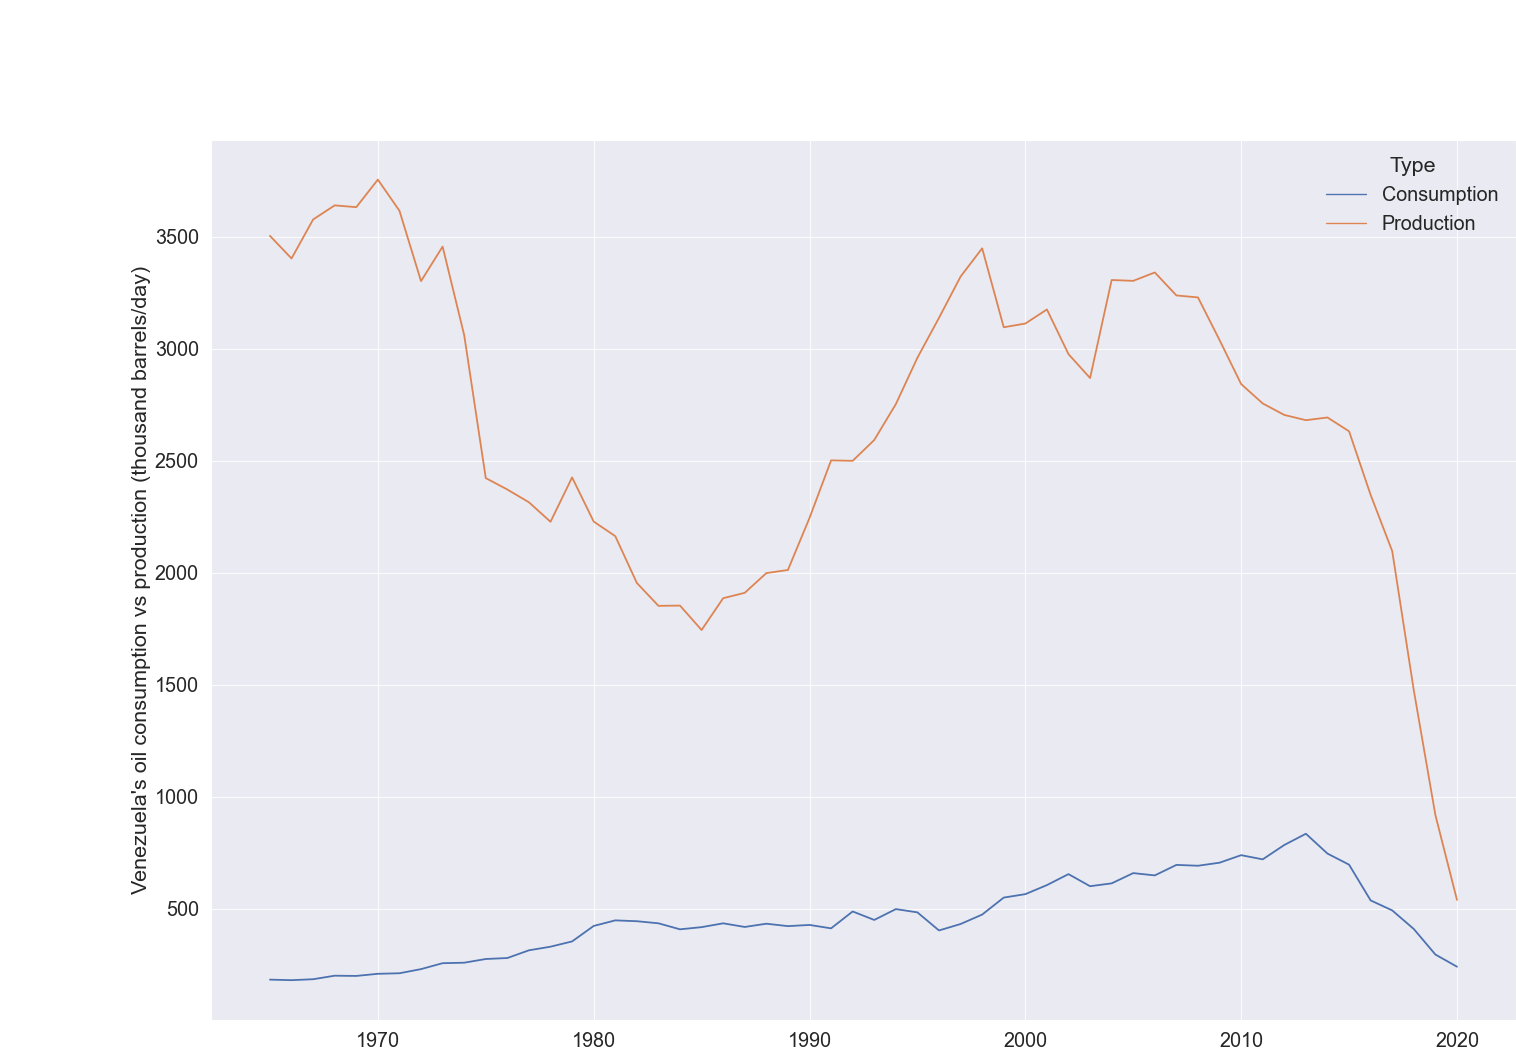

In [399]:
plt.figure(figsize=(26,18))
sns.set(font_scale = 2)
sns.lineplot(data=venezuela_prod_to_consum_pivot.reset_index(), x='Year', y='thousand_barrels_daily', hue='Type', linewidth= 2.0)
plt.ylabel("Venezuela's oil consumption vs production (thousand barrels/day)")
plt.show()

## Saudi Arabia

In [498]:
# Check Saudi Arabia's oil production in Mbbl/d. We will take the # for 2020.
saudi_oil_prod_subset = ds_oil_production[((ds_oil_production.Country == 'Saudi Arabia'))]

In [499]:
saudi_oil_prod_subset.rename({'Country':'Type'}, axis=1, inplace=True)
saudi_oil_prod_subset['Type'] = saudi_oil_prod_subset['Type'].replace({'Saudi Arabia': 'Production'})
saudi_oil_prod_subset

D:\User\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-499-ba8aa57b699f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  saudi_oil_prod_subset['Type'] = saudi_oil_prod_subset['Type'].replace({'Saudi Arabia': 'Production'})


Type    1965    1966    1967    1968    1969    1970    1971  \
38  Production  2219.3  2617.8  2825.0  3080.9  3262.2  3851.1  4820.9   

      1972    1973  ...          2011          2012          2013  \
38  6070.3  7693.2  ...  11079.228786  11621.794283  11392.926635   

            2014          2015          2016          2017          2018  \
38  11518.822724  11997.937984  12406.047608  11892.198262  12261.333342   

            2019          2020  
38  11832.319243  11038.951334  

[1 rows x 57 columns]

In [500]:
print("Saudi Arabia's oil production in Mbbl/y for 2020 is: ", 11039000 * 365.24)

Saudi Arabia's oil production in Mbbl/y for 2020 is:  4031884360.0


In [501]:
# Check Saudi Arabia's oil consumption in Mbbl/d. We will take the # for 2020.
saudi_oil_consum_subset = ds_oil_consumption[((ds_oil_consumption.Country == 'Saudi Arabia'))]

In [502]:
saudi_oil_consum_subset.rename({'Country':'Type'}, axis=1, inplace=True)
saudi_oil_consum_subset['Type'] = saudi_oil_consum_subset['Type'].replace({'Saudi Arabia': 'Consumption'})
saudi_oil_consum_subset

D:\User\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-502-bc746b3c184b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  saudi_oil_consum_subset['Type'] = saudi_oil_consum_subset['Type'].replace({'Saudi Arabia': 'Consumption'})


Type        1965        1966        1967        1968        1969  \
71  Consumption  389.574466  392.916027  396.259562  398.552514  403.065123   

          1970        1971        1972        1973  ...         2011  \
71  434.741397  441.319344  470.255456  500.584796  ...  3285.316285   

          2012         2013         2014         2015         2016  \
71  3451.20718  3444.033052  3759.831738  3878.700539  3865.354756   

           2017         2018         2019         2020  
71  3798.747608  3617.030111  3634.669328  3543.806411  

[1 rows x 57 columns]

In [503]:
print("Saudi Arabia's oil consumption in Mbbl/y for 2020 is: ", 3543000 * 365.24)

Saudi Arabia's oil consumption in Mbbl/y for 2020 is:  1294045320.0


In [519]:
print("Years of proven oil reserves left for Saudi Arabia as of 2020:  ", 297500000000/4031884360)

Years of proven oil reserves left for Saudi Arabia as of 2020:   73.78683846974222


### Alternative calculation

In [510]:
saudi_prod_melt = saudi_oil_prod_subset.melt(id_vars=['Type'], var_name='Year', value_name='thousand_barrels_daily')

In [511]:
saudi_prod_melt['converted'] = saudi_prod_melt['thousand_barrels_daily'] * 365.24
print(saudi_prod_melt['converted'])

0     8.105771e+05
1     9.561253e+05
2     1.031803e+06
3     1.125268e+06
4     1.191486e+06
5     1.406576e+06
6     1.760786e+06
7     2.217116e+06
8     2.809864e+06
9     3.147529e+06
10    2.635718e+06
11    3.200296e+06
12    3.440161e+06
13    3.124293e+06
14    3.594556e+06
15    3.750832e+06
16    3.745901e+06
17    2.542436e+06
18    1.808453e+06
19    1.656028e+06
20    1.315213e+06
21    1.902243e+06
22    1.625373e+06
23    2.065851e+06
24    2.058310e+06
25    2.595213e+06
26    3.221344e+06
27    3.320653e+06
28    3.247970e+06
29    3.280951e+06
30    3.277495e+06
31    3.318754e+06
32    3.289102e+06
33    3.384601e+06
34    3.113236e+06
35    3.331414e+06
36    3.263430e+06
37    2.997342e+06
38    3.516589e+06
39    3.764131e+06
40    3.958683e+06
41    3.897396e+06
42    3.750559e+06
43    3.895210e+06
44    3.546080e+06
45    3.603029e+06
46    4.046578e+06
47    4.244744e+06
48    4.161153e+06
49    4.207135e+06
50    4.382127e+06
51    4.531185e+06
52    4.3435

In [512]:
all_time_reserve2 = saudi_prod_melt['converted'].sum()
print(all_time_reserve2)

169244236.40571904


In [513]:
169.2/(169.2+297.5)

0.36254553246196697

Saudi Arabia's 36.3% empty.

In [505]:
saudi_prod_to_consum = saudi_oil_consum_subset.append(saudi_oil_prod_subset, ignore_index=True)

In [506]:
saudi_prod_to_consum_melt = saudi_prod_to_consum.melt(id_vars=['Type'], var_name='Year', value_name='thousand_barrels_daily')

In [507]:
saudi_prod_to_consum_pivot = saudi_prod_to_consum_melt.pivot_table(index=['Type', 'Year'])

<IPython.core.display.Javascript object>


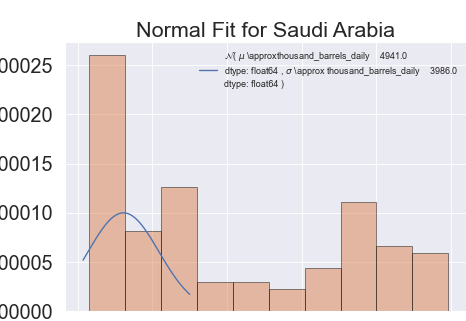

In [508]:
from scipy.stats import norm
from matplotlib import pyplot as plt
%matplotlib notebook

# Sample std and mu
std3 = np.std(saudi_prod_to_consum_pivot, ddof=1)
mean3 = np.mean(saudi_prod_to_consum_pivot)

# Plot
domain = np.linspace(np.min(saudi_prod_to_consum_pivot), np.max(saudi_prod_to_consum_pivot))
plt.plot(x, norm.pdf(domain, mean3, std3), 
        label= '$\mathcal{N} ' + f'$( $\mu$ \\approx{round(mean3)} , $\sigma$ \\approx {round(std3)} )')
plt.hist(saudi_prod_to_consum_pivot, edgecolor='black', alpha=0.5, density=True)
plt.title("Normal Fit for Saudi Arabia")
plt.xlabel("value")
plt.ylabel("Density")
plt.legend(loc=1, prop={'size': 10})
plt.show()

<IPython.core.display.Javascript object>


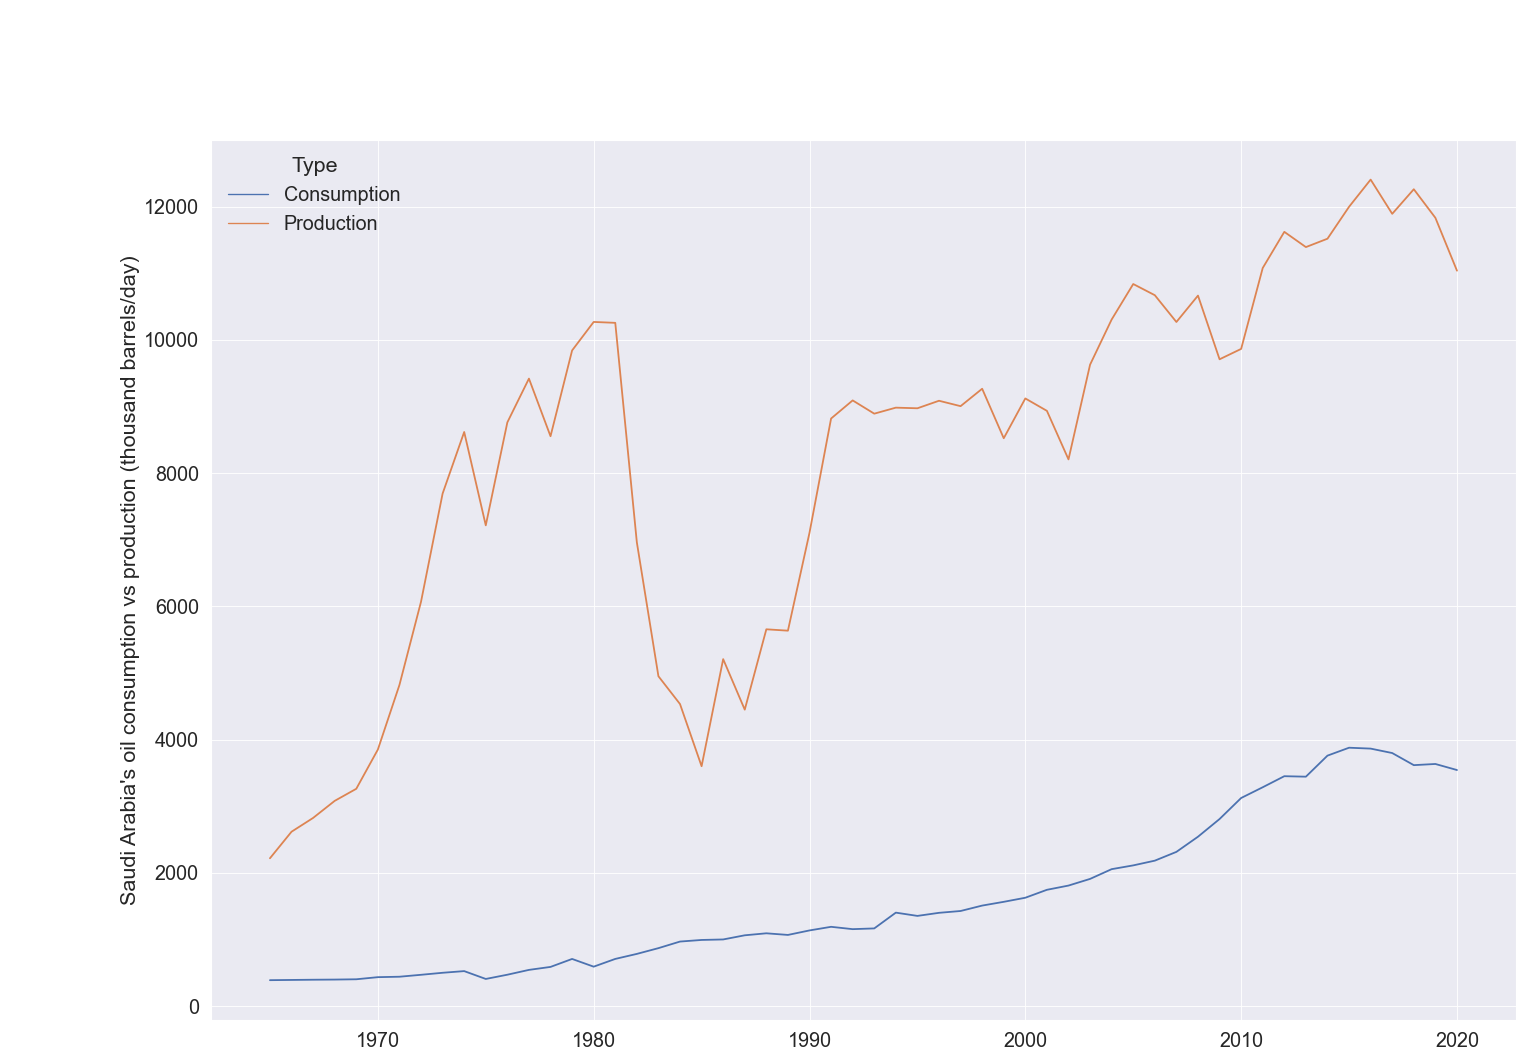

In [514]:
plt.figure(figsize=(26,18))
sns.set(font_scale = 2)
sns.lineplot(data=saudi_prod_to_consum_pivot.reset_index(), x='Year', y='thousand_barrels_daily', hue='Type', linewidth= 2.0)
plt.ylabel("Saudi Arabia's oil consumption vs production (thousand barrels/day)")
plt.show()

## Canada

In [543]:
# Check Canada's oil production in Mbbl/d. We will take the # for 2020.
canada_oil_prod_subset = ds_oil_production[((ds_oil_production.Country == 'Canada'))]
canada_oil_prod_subset

Country   1965    1966    1967    1968    1969    1970    1971    1972  \
1  Canada  920.0  1012.0  1106.0  1194.0  1306.0  1473.0  1582.0  1829.0   

     1973  ...         2011         2012         2013         2014  \
1  2114.0  ...  3514.822066  3740.237677  4000.410965  4270.529903   

          2015         2016         2017         2018         2019  \
1  4388.135578  4463.638847  4813.033351  5243.879959  5372.417032   

          2020  
1  5135.483143  

[1 rows x 57 columns]

In [544]:
canada_oil_prod_subset.rename({'Country':'Type'}, axis=1, inplace=True)
canada_oil_prod_subset['Type'] = canada_oil_prod_subset['Type'].replace({'Canada': 'Production'})
canada_oil_prod_subset

D:\User\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-544-3b79420b3dd2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canada_oil_prod_subset['Type'] = canada_oil_prod_subset['Type'].replace({'Canada': 'Production'})


Type   1965    1966    1967    1968    1969    1970    1971    1972  \
1  Production  920.0  1012.0  1106.0  1194.0  1306.0  1473.0  1582.0  1829.0   

     1973  ...         2011         2012         2013         2014  \
1  2114.0  ...  3514.822066  3740.237677  4000.410965  4270.529903   

          2015         2016         2017         2018         2019  \
1  4388.135578  4463.638847  4813.033351  5243.879959  5372.417032   

          2020  
1  5135.483143  

[1 rows x 57 columns]

In [545]:
print("Canada's oil production in Mbbl/y for 2020 is: ", 5135000 * 365.24)

Canada's oil production in Mbbl/y for 2020 is:  1875507400.0


In [546]:
print("Years of proven oil reserves left for Saudi Arabia as of 2020:  ", 168000000000/1875507400)

Years of proven oil reserves left for Saudi Arabia as of 2020:   89.5757596051074


In [547]:
# Check Canada's oil consumption in Mbbl/d. We will take the # for 2020.
canada_oil_consum_subset = ds_oil_consumption[((ds_oil_consumption.Country == 'Canada'))]
canada_oil_consum_subset

Country         1965         1966         1967        1968         1969  \
1  Canada  1108.116301  1167.468795  1245.557068  1322.15735  1380.190329   

          1970         1971         1972         1973  ...         2011  \
1  1471.579753  1512.128247  1588.909235  1754.885644  ...  2399.914318   

          2012         2013         2014         2015         2016  \
1  2423.735391  2419.498225  2418.769294  2442.003685  2452.037349   

          2017        2018         2019         2020  
1  2422.998806  2500.80635  2536.766731  2282.478848  

[1 rows x 57 columns]

In [548]:
canada_oil_consum_subset.rename({'Country':'Type'}, axis=1, inplace=True)
canada_oil_consum_subset['Type'] = canada_oil_consum_subset['Type'].replace({'Canada': 'Consumption'})
canada_oil_consum_subset

D:\User\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-548-1c255057f707>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canada_oil_consum_subset['Type'] = canada_oil_consum_subset['Type'].replace({'Canada': 'Consumption'})


Type         1965         1966         1967        1968  \
1  Consumption  1108.116301  1167.468795  1245.557068  1322.15735   

          1969         1970         1971         1972         1973  ...  \
1  1380.190329  1471.579753  1512.128247  1588.909235  1754.885644  ...   

          2011         2012         2013         2014         2015  \
1  2399.914318  2423.735391  2419.498225  2418.769294  2442.003685   

          2016         2017        2018         2019         2020  
1  2452.037349  2422.998806  2500.80635  2536.766731  2282.478848  

[1 rows x 57 columns]

### Rate of Emptiness

In [549]:
canada_prod_melt = canada_oil_prod_subset.melt(id_vars=['Type'], var_name='Year', value_name='thousand_barrels_daily')

In [550]:
canada_prod_melt['converted'] = canada_prod_melt['thousand_barrels_daily'] * 365.24
print(canada_prod_melt['converted'])

0     3.360208e+05
1     3.696229e+05
2     4.039554e+05
3     4.360966e+05
4     4.770034e+05
5     5.379985e+05
6     5.778097e+05
7     6.680240e+05
8     7.721174e+05
9     7.279233e+05
10    6.336914e+05
11    5.836535e+05
12    5.873059e+05
13    5.832883e+05
14    6.702154e+05
15    6.442834e+05
16    5.880364e+05
17    5.807316e+05
18    6.066636e+05
19    6.483010e+05
20    6.621053e+05
21    6.593011e+05
22    6.971591e+05
23    7.313633e+05
24    7.164023e+05
25    7.186958e+05
26    7.244555e+05
27    7.544321e+05
28    7.995141e+05
29    8.332347e+05
30    8.773532e+05
31    9.057650e+05
32    9.450915e+05
33    9.760606e+05
34    9.512309e+05
35    9.873905e+05
36    9.963594e+05
37    1.043916e+06
38    1.096988e+06
39    1.124896e+06
40    1.110657e+06
41    1.171830e+06
42    1.201709e+06
43    1.171338e+06
44    1.169644e+06
45    1.217009e+06
46    1.283754e+06
47    1.366084e+06
48    1.461110e+06
49    1.559768e+06
50    1.602723e+06
51    1.630299e+06
52    1.7579

In [551]:
all_time_reserve3 = canada_prod_melt['converted'].sum()
print(all_time_reserve3)

52091473.5134439


In [552]:
52.0/(52.0 + 168.1)

0.23625624716038165

Canada is about 23.6% empty according to this.

In [553]:
canada_prod_to_consum = canada_oil_consum_subset.append(canada_oil_prod_subset, ignore_index=True)
canada_prod_to_consum

Type         1965         1966         1967        1968  \
0  Consumption  1108.116301  1167.468795  1245.557068  1322.15735   
1   Production   920.000000  1012.000000  1106.000000  1194.00000   

          1969         1970         1971         1972         1973  ...  \
0  1380.190329  1471.579753  1512.128247  1588.909235  1754.885644  ...   
1  1306.000000  1473.000000  1582.000000  1829.000000  2114.000000  ...   

          2011         2012         2013         2014         2015  \
0  2399.914318  2423.735391  2419.498225  2418.769294  2442.003685   
1  3514.822066  3740.237677  4000.410965  4270.529903  4388.135578   

          2016         2017         2018         2019         2020  
0  2452.037349  2422.998806  2500.806350  2536.766731  2282.478848  
1  4463.638847  4813.033351  5243.879959  5372.417032  5135.483143  

[2 rows x 57 columns]

In [554]:
canada_prod_to_consum_melt = canada_prod_to_consum.melt(id_vars=['Type'], var_name='Year', value_name='thousand_barrels_daily')

In [555]:
canada_prod_to_consum_pivot = canada_prod_to_consum_melt.pivot_table(index=['Type', 'Year'])
canada_prod_to_consum_pivot

thousand_barrels_daily
Type        Year                        
Consumption 1965             1108.116301
            1966             1167.468795
            1967             1245.557068
            1968             1322.157350
            1969             1380.190329
...                                  ...
Production  2016             4463.638847
            2017             4813.033351
            2018             5243.879959
            2019             5372.417032
            2020             5135.483143

[112 rows x 1 columns]

<IPython.core.display.Javascript object>


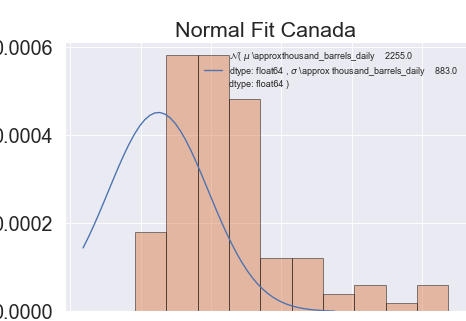

In [556]:
from scipy.stats import norm
from matplotlib import pyplot as plt
%matplotlib notebook

# Sample std and mu
std4 = np.std(canada_prod_to_consum_pivot, ddof=1)
mean4 = np.mean(canada_prod_to_consum_pivot)

# Plot
domain = np.linspace(np.min(canada_prod_to_consum_pivot), np.max(canada_prod_to_consum_pivot))
plt.plot(x, norm.pdf(domain, mean4, std4), 
        label= '$\mathcal{N} ' + f'$( $\mu$ \\approx{round(mean4)} , $\sigma$ \\approx {round(std4)} )')
plt.hist(canada_prod_to_consum_pivot, edgecolor='black', alpha=0.5, density=True)
plt.title("Normal Fit Canada")
plt.xlabel("value")
plt.ylabel("Density")
plt.legend(loc=1, prop={'size': 10})
plt.show()

## OECD

OECD stands for Organisation of Economic Cooperation and Development. According to Wikipedia, it is an intergovernmental economic organisation with 38 member countries, founded in 1961 to stimulate economic progress and world trade. Those countries consist of the U.S., much of Europe, and other world-leading, advanced countries. 

### Natural Gas

In [557]:
natural_gas_data = power_plant_data[((power_plant_data.primary_fuel == 'Gas'))]

In [558]:
# Making separate dataset for capacity_mw; will use later for combined table
natural_gas_subset = natural_gas_data[['country_long','capacity_mw']]

In [559]:
natural_gas_data = natural_gas_data.drop(columns='other_fuel1')
natural_gas_data = natural_gas_data.drop(columns='other_fuel2')
natural_gas_data = natural_gas_data.drop(columns='other_fuel3')

In [560]:
est_gen_gwh_natural_gas = natural_gas_data[['country_long','estimated_generation_gwh_2017']]

In [561]:
# eliminate NaN's
est_gen_gwh_natural_gas = est_gen_gwh_natural_gas[est_gen_gwh_natural_gas['estimated_generation_gwh_2017'].notna()]
est_gen_gwh_natural_gas = est_gen_gwh_natural_gas[est_gen_gwh_natural_gas['estimated_generation_gwh_2017'] != 'nan']

  country_long  estimated_generation_gwh_2017
0      Algeria                    2044.528065
1       Angola                       0.000000
2    Argentina                    1281.531404
3      Armenia                    3892.626667
4    Australia                     414.181940
country_long                     0.0
estimated_generation_gwh_2017    0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   country_long                   92 non-null     object 
 1   estimated_generation_gwh_2017  92 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB
None
       estimated_generation_gwh_2017
count                      92.000000
mean                     2066.755713
std                      2019.639603
min                         0.000000
25%                       703.906875
50%           

<IPython.core.display.Javascript object>


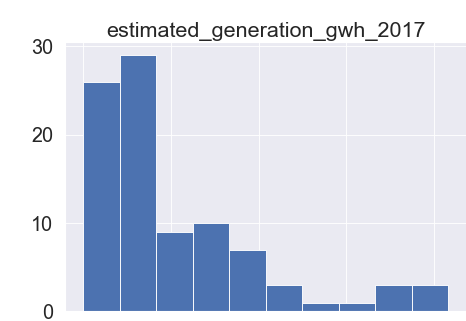

[[<AxesSubplot:title={'center':'estimated_generation_gwh_2017'}>]]


In [562]:
est_gen_gwh_natural_gas_avg = est_gen_gwh_natural_gas.groupby('country_long').mean().reset_index()
brief_summary(est_gen_gwh_natural_gas_avg)

#### Top 10 Countries with highest estimated generation gwh for 2017 - Natural Gas

In [563]:
top_gwh_2017_natural_gas = est_gen_gwh_natural_gas_avg.sort_values(['country_long', 'estimated_generation_gwh_2017'], ascending=False).groupby('country_long').head(10)
top_gwh_2017_natural_gas

country_long  estimated_generation_gwh_2017
91                     Yemen                    1422.820000
90                   Vietnam                    6760.998889
89                 Venezuela                     970.082647
88                Uzbekistan                    7980.733333
87  United States of America                    1059.952800
..                       ...                            ...
4                  Australia                     414.181940
3                    Armenia                    3892.626667
2                  Argentina                    1281.531404
1                     Angola                       0.000000
0                    Algeria                    2044.528065

[92 rows x 2 columns]